In [119]:
import pandas as pd
import numpy as np
import os

### Пропишем настройки для нашего алгоритма

In [156]:
# Настройка отсечки по малым пикам
min_intensity_threshold = 0.01  # отсечка по интенсивности (0.1 означает, что пики с интенсивностью ниже 10% от максимальной интенсивности будут игнорироваться)

# Настройка отхождения по частоте
frequency_tolerance = 3  # максимальное отклонение по частоте

# Настройка уникальности пиков
unique_peak_tolerance = 3  # максимальное отхождение по частоте для определения уникальности пика# Загрузка экспериментальных данных

#### Импорт файлов и обработка

In [157]:
exp_data = pd.read_csv('experimental_data.dpt', header=None, names=['Частота', 'Экспериментальная интенсивность'])

# Загрузка предсказанных данных спектров ИК-Фурье
predicted_data_dir = 'predicted_data'
predicted_files = [f for f in os.listdir(predicted_data_dir) if f.endswith('.txt')]

# Создание таблицы для хранения результатов
results = pd.DataFrame(columns=['Название вещества', 'Частота', 'Экспериментальная интенсивность'])


In [158]:
# Обработка предсказанных данных
for file in predicted_files:
    substance_name = file.split('.')[0]
    predicted_data = pd.read_csv(os.path.join(predicted_data_dir, file), sep='\t')
    
    # Переименование столбцов для удобства
    predicted_data = predicted_data.rename(columns={'Wavenumber / Raman shift (cm⁻¹)': 'Частота', 'IR Intensity': 'Интенсивность'})
    
    # Добавление столбца 'Название вещества'
    predicted_data['Название вещества'] = substance_name
    
    # Отсечение малых пиков
    predicted_data = predicted_data[predicted_data['Интенсивность'] > min_intensity_threshold * predicted_data['Интенсивность'].max()]
    
    # Сортировка по частоте
    predicted_data = predicted_data.sort_values(by='Частота')
    exp_data = exp_data.sort_values(by='Частота')
    
    # Поиск совпадений с экспериментальными данными с учетом отхождения
    matches = pd.merge_asof(predicted_data, exp_data, on='Частота', direction='nearest', tolerance=frequency_tolerance)
    
    # Удаление строк с пустыми значениями в столбце "Экспериментальная интенсивность"
    matches = matches.dropna(subset=['Экспериментальная интенсивность'])

    # Определение уникальности пиков
    matches['Уникальность'] = matches.apply(lambda row: 'Уникальный' if len(matches[(matches['Частота'] >= row['Частота'] - unique_peak_tolerance) & (matches['Частота'] <= row['Частота'] + unique_peak_tolerance)]) == 1 else ', '.join(matches[(matches['Частота'] >= row['Частота'] - unique_peak_tolerance) & (matches['Частота'] <= row['Частота'] + unique_peak_tolerance)]['Название вещества'].unique()), axis=1)
    
    # Добавление результатов в таблицу
    results = pd.concat([results, matches[['Название вещества', 'Частота', 'Экспериментальная интенсивность', 'Уникальность']]], ignore_index=True)# Сохранение результатов в файл

C:\Users\SHESTUPA\AppData\Local\Temp\ipykernel_15988\3968203260.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, matches[['Название вещества', 'Частота', 'Экспериментальная интенсивность', 'Уникальность']]], ignore_index=True)# Сохранение результатов в файл


#### Определение уникальности 

In [159]:
# Создание списка всех частот
frequencies = results['Частота'].unique()

# Обработка каждой частоты
for frequency in frequencies:
    # Поиск пересекающихся частот
    intersecting_frequencies = frequencies[(frequencies >= frequency - unique_peak_tolerance) & (frequencies <= frequency + unique_peak_tolerance)]
    
    # Если найдены пересекающиеся частоты, то объедините списки веществ
    if len(intersecting_frequencies) > 1:
        substances = []
        for intersecting_frequency in intersecting_frequencies:
            substances.extend(results[results['Частота'] == intersecting_frequency]['Название вещества'].unique())
        results.loc[results['Частота'] == frequency, 'Уникальность'] = ', '.join(substances)
    # Если нет пересекающихся частот, то пометьте частоту как "Уникальный"
    else:
        results.loc[results['Частота'] == frequency, 'Уникальность'] = 'Уникальный'

# Сохранение результатов в файл
results.to_csv('results.csv', index=False)

### Посмотрим таблицу результатов

In [160]:
results

Название вещества  Частота  Экспериментальная интенсивность  \
0        Acetaldehyde    728.4                          0.00140   
1        Acetaldehyde    991.0                          0.01121   
2        Acetaldehyde   1053.1                          0.02104   
3        Acetaldehyde   1079.6                          0.02095   
4        Acetaldehyde   1352.8                          0.01971   
..                ...      ...                              ...   
458          Xanthine   1755.3                          0.00497   
459          Xanthine   1775.4                          0.00947   
460          Xanthine   3403.6                          0.04061   
461          Xanthine   3446.8                          0.03509   
462          Xanthine   3471.0                          0.03119   

                                          Уникальность  
0                      Acetaldehyde, Caffeine, Thiamin  
1    Acetaldehyde, Caffeine, Putrescine, Spermine, ...  
2                               Acetaldehyde, Spermine  
3                   Acetaldehyde, Quinic acid, Thiamin  
4    Acetaldehyde, Quinic acid, Scopoletin, Spermidine  
..                                                 ...  
458                                         Уникальный  
459                                         Уникальный  
460                                         Уникальный  
461                         Chlorogenic acid, Xanthine  
462                                         Уникальный  

[463 rows x 4 columns]

#### Анализ и визуализация данных

Визуализируем пики на нашем эксперименте

Введите настройку показа веществ (all, only, или список веществ через запятую):  all
Введите настройку показа частот (all, only, или список пересечений веществ через запятую):  Acetaldehyde, Spermine


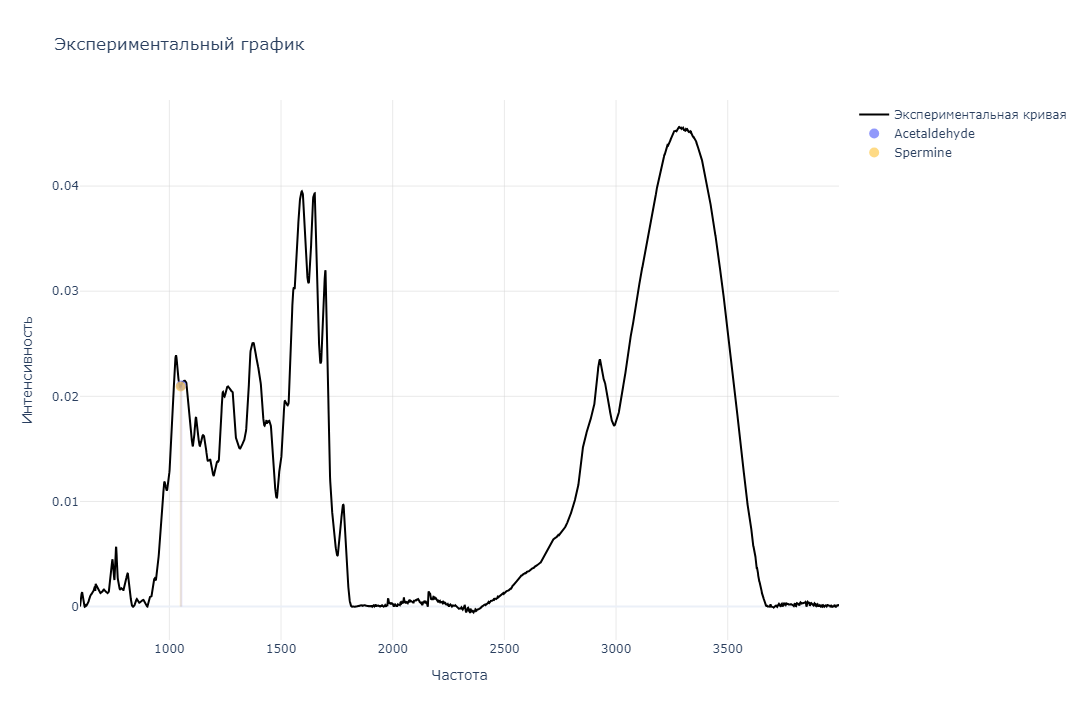

In [184]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Настройки
show_substances = input("Введите настройку показа веществ (all, only, или список веществ через запятую): ")
show_frequencies = input("Введите настройку показа частот (all, only, или список пересечений веществ через запятую): ")

# Загрузка экспериментальных данных
exp_data = pd.read_csv('experimental_data.dpt', header=None, names=['Частота', 'Экспериментальная интенсивность'])

# Создание графика
fig = go.Figure()

# Добавление экспериментальной кривой
fig.add_trace(go.Scatter(
    x=exp_data['Частота'], 
    y=exp_data['Экспериментальная интенсивность'], 
    mode='lines', 
    line=dict(color='black'),
    name='Экспериментальная кривая'
))

# Показ точек из переменной results
if show_substances == 'all':
    substances = results['Название вещества'].unique()
elif show_substances == 'only':
    substances = results[results['Уникальность'] == 'Уникальный']['Название вещества'].unique()
else:
    substances = [substance.strip() for substance in show_substances.split(',')]

if show_frequencies == 'all':
    frequencies = results['Частота'].unique()
elif show_frequencies == 'only':
    frequencies = results[results['Уникальность'] == 'Уникальный']['Частота'].unique()
else:
    frequencies = results[results['Уникальность'] == show_frequencies]['Частота'].unique()

# Определяем ширину прямоугольников
dx = 10  # Вы можете изменить это значение на нужное

# Цветовая палитра
colors = px.colors.qualitative.Plotly

# Добавление точек и закрашивание прямоугольников под ними
for idx, substance in enumerate(substances):
    substance_data = results[results['Название вещества'] == substance]
    if show_frequencies != 'all':
        substance_data = substance_data[substance_data['Частота'].isin(frequencies)]
    
    color = colors[idx % len(colors)]  # Использование цвета из палитры
    
    fig.add_trace(go.Scatter(
        x=substance_data['Частота'], 
        y=substance_data['Экспериментальная интенсивность'], 
        mode='markers',
        marker=dict(size=10, opacity=0.7, color=color),
        name=substance
    ))

    for index, row in substance_data.iterrows():
        fig.add_shape(
            type="rect",
            x0=row['Частота'] - dx / 2,
            x1=row['Частота'] + dx / 2,
            y0=0,
            y1=row['Экспериментальная интенсивность'],
            fillcolor=color,
            opacity=0.2,
            line=dict(width=0)
        )

# Настройки сетки и осей
fig.update_layout(
    title='Экспериментальный график',
    xaxis_title='Частота',
    yaxis_title='Интенсивность',
    template='plotly_white',
    xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='LightGray'),
    width=1200,  # Увеличение ширины
    height=720   # Увеличение высоты
)

# Показ графика
fig.show()

статиченый график

Введите настройку показа веществ (all, only, или список веществ через запятую):  all
Введите настройку показа частот (all, only, или список пересечений веществ через запятую):  only


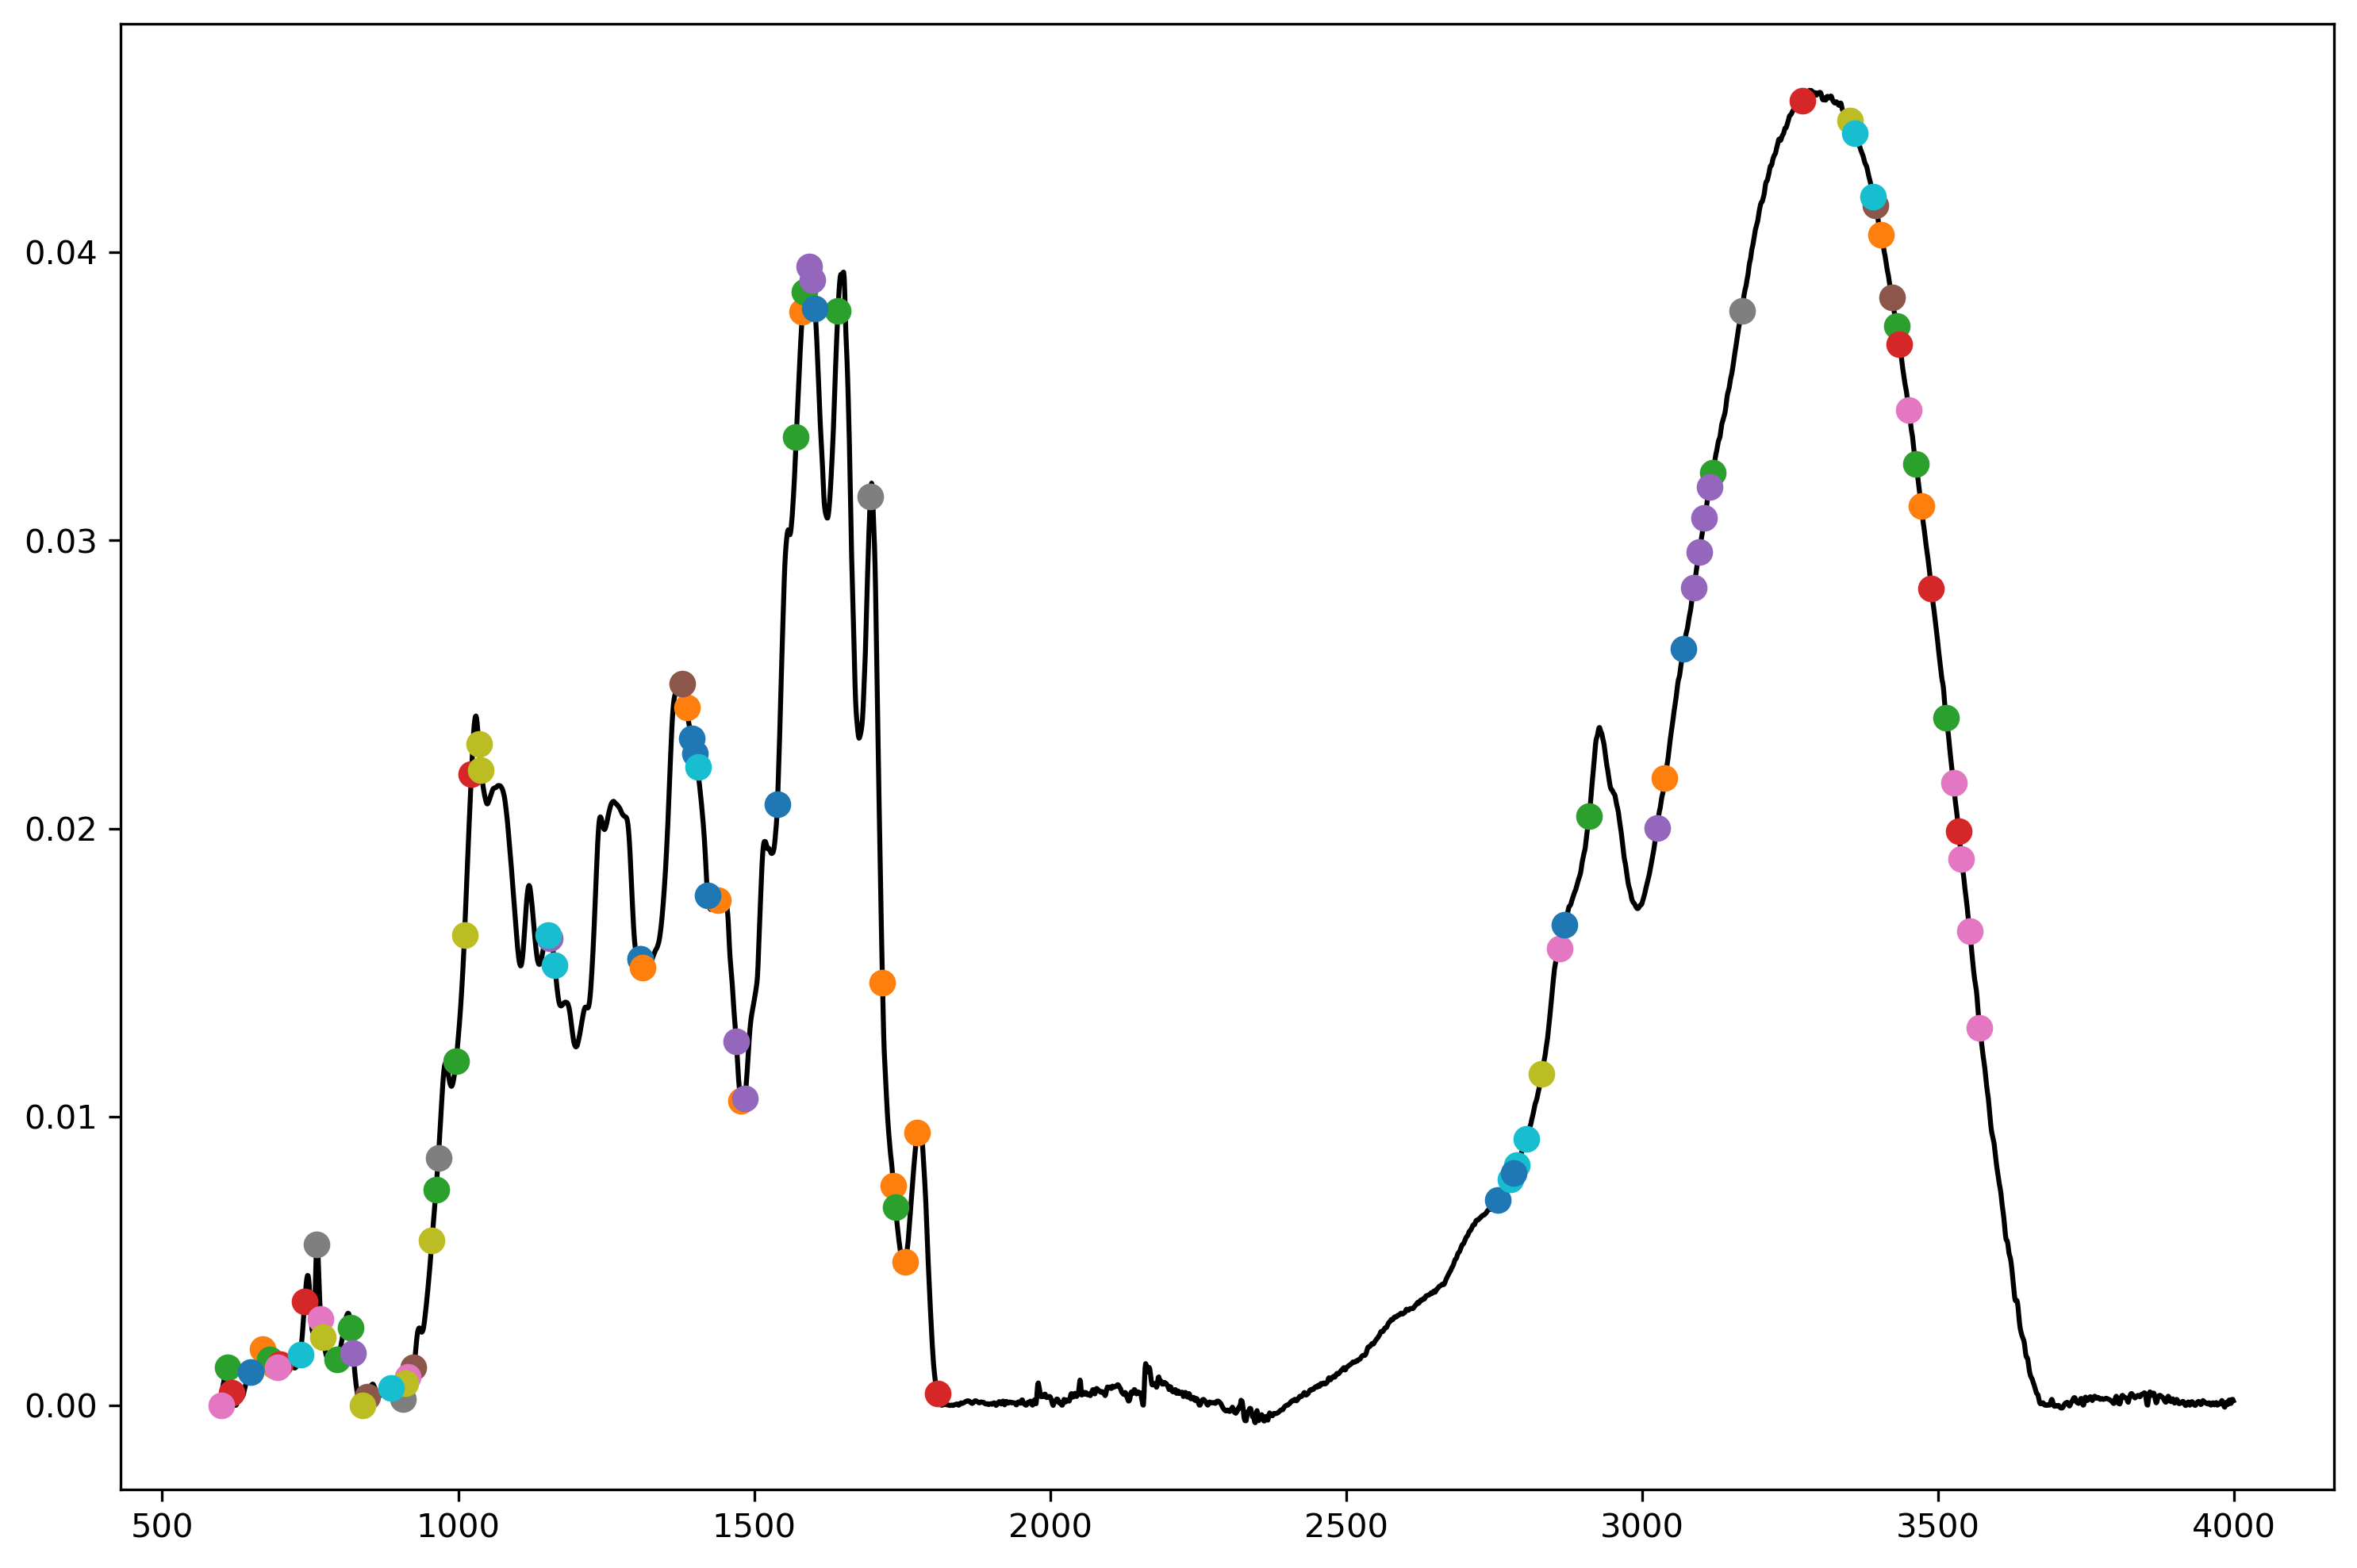

In [164]:
import matplotlib.pyplot as plt
import pandas as pd

# Настройки
show_substances = input("Введите настройку показа веществ (all, only, или список веществ через запятую): ")
show_frequencies = input("Введите настройку показа частот (all, only, или список пересечений веществ через запятую): ")

# Загрузка экспериментальных данных
exp_data = pd.read_csv('experimental_data.dpt', header=None, names=['Частота', 'Экспериментальная интенсивность'])

# Показ экспериментальной кривой
plt.figure(figsize=(12, 8), dpi=300)  # Увеличение разрешения
plt.plot(exp_data['Частота'], exp_data['Экспериментальная интенсивность'], color='black')  # Линия экспериментальной кривой черная

# Показ точек из переменной results
if show_substances == 'all':
    substances = results['Название вещества'].unique()
elif show_substances == 'only':
    substances = results[results['Уникальность'] == 'Уникальный']['Название вещества'].unique()
else:
    substances = [substance.strip() for substance in show_substances.split(',')]

if show_frequencies == 'all':
    frequencies = results['Частота'].unique()
elif show_frequencies == 'only':
    frequencies = results[results['Уникальность'] == 'Уникальный']['Частота'].unique()
else:
    frequencies = results[results['Уникальность'] == show_frequencies]['Частота'].unique()

for substance in substances:
    substance_data = results[results['Название вещества'] == substance]
    if show_frequencies!= 'all':
        substance_data = substance_data[substance_data['Частота'].isin(frequencies)]
    plt.scatter(substance_data['Частота'], substance_data['Экспериментальная интенсивность'], label=substance, s=50, marker='o', zorder=10)  # Закрашивание полосы под точ

#### Анализ результатов наложения

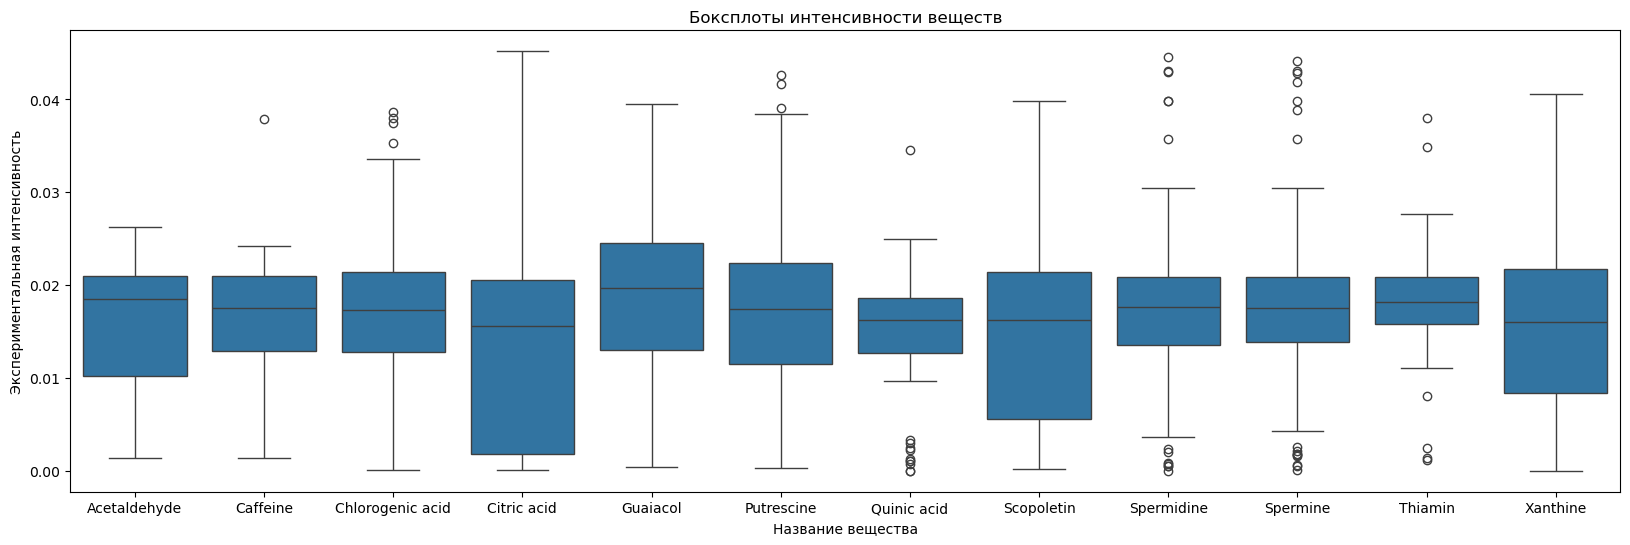

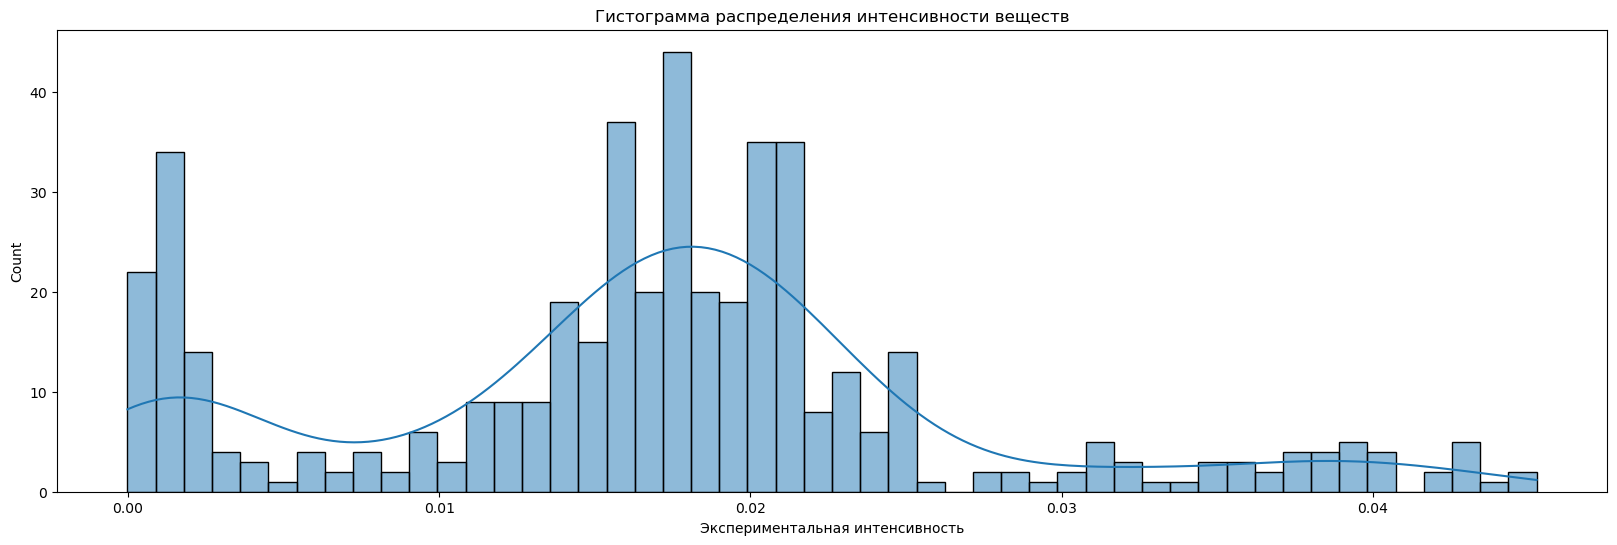

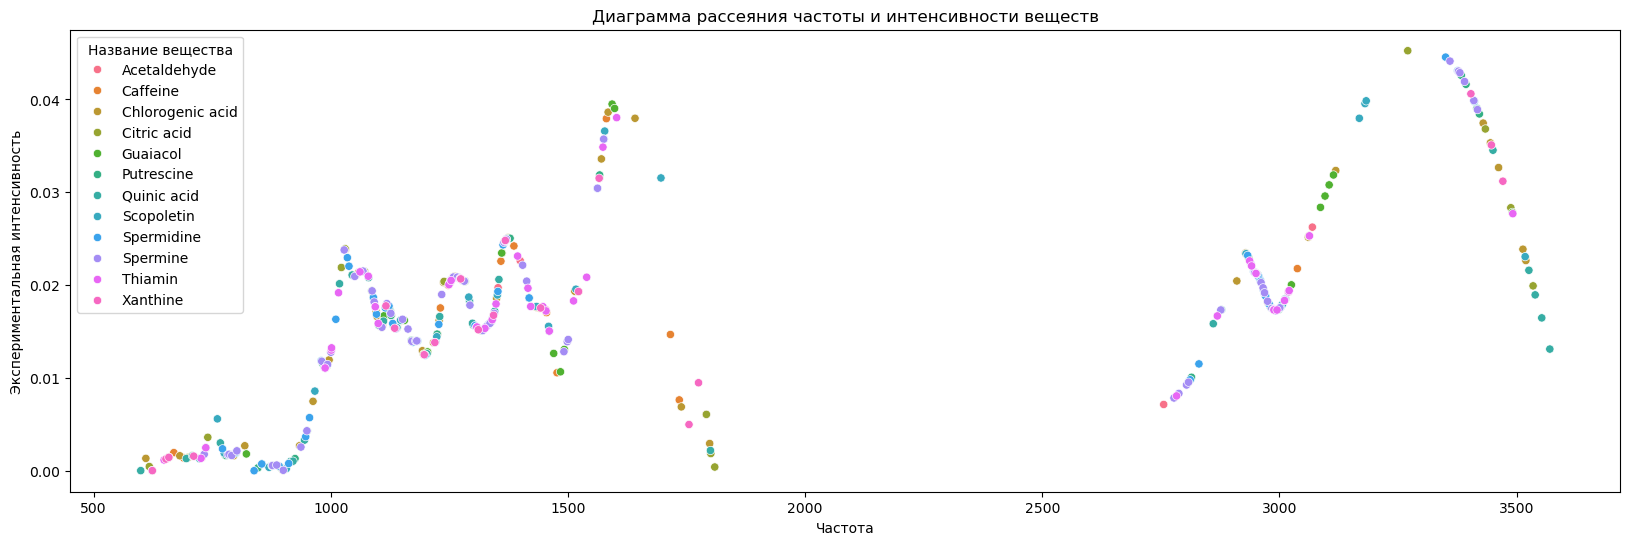

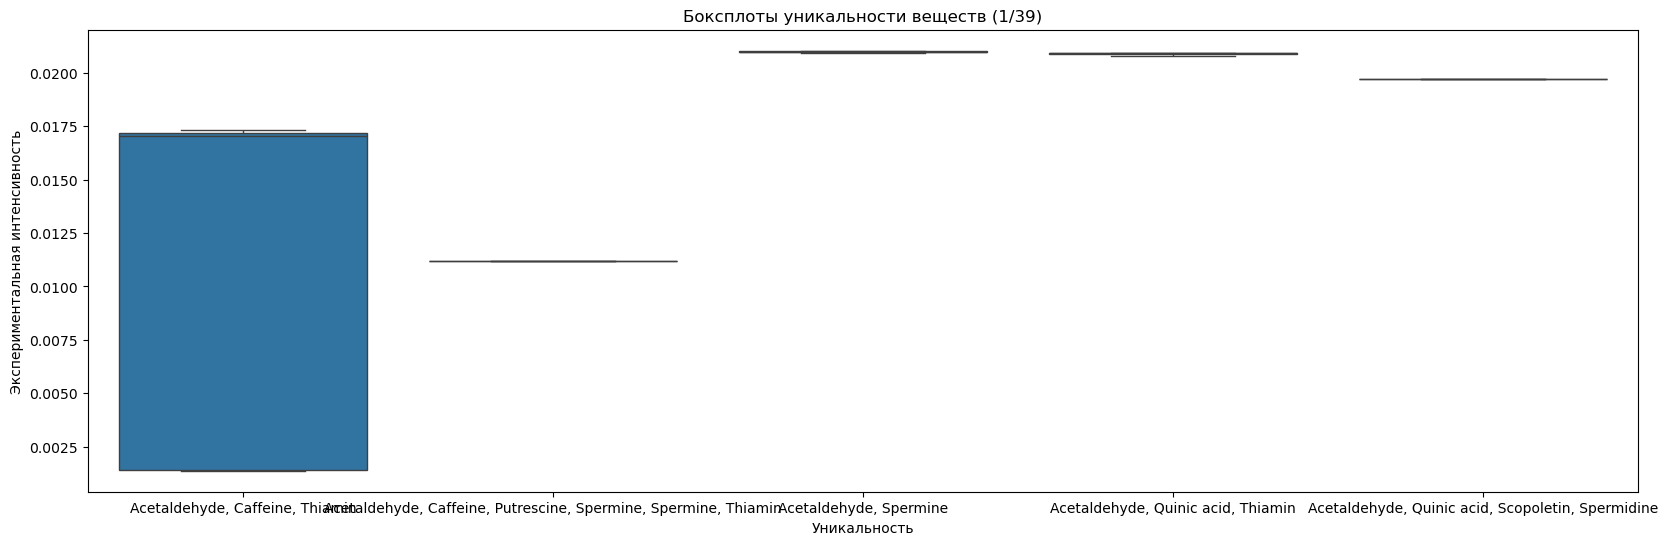

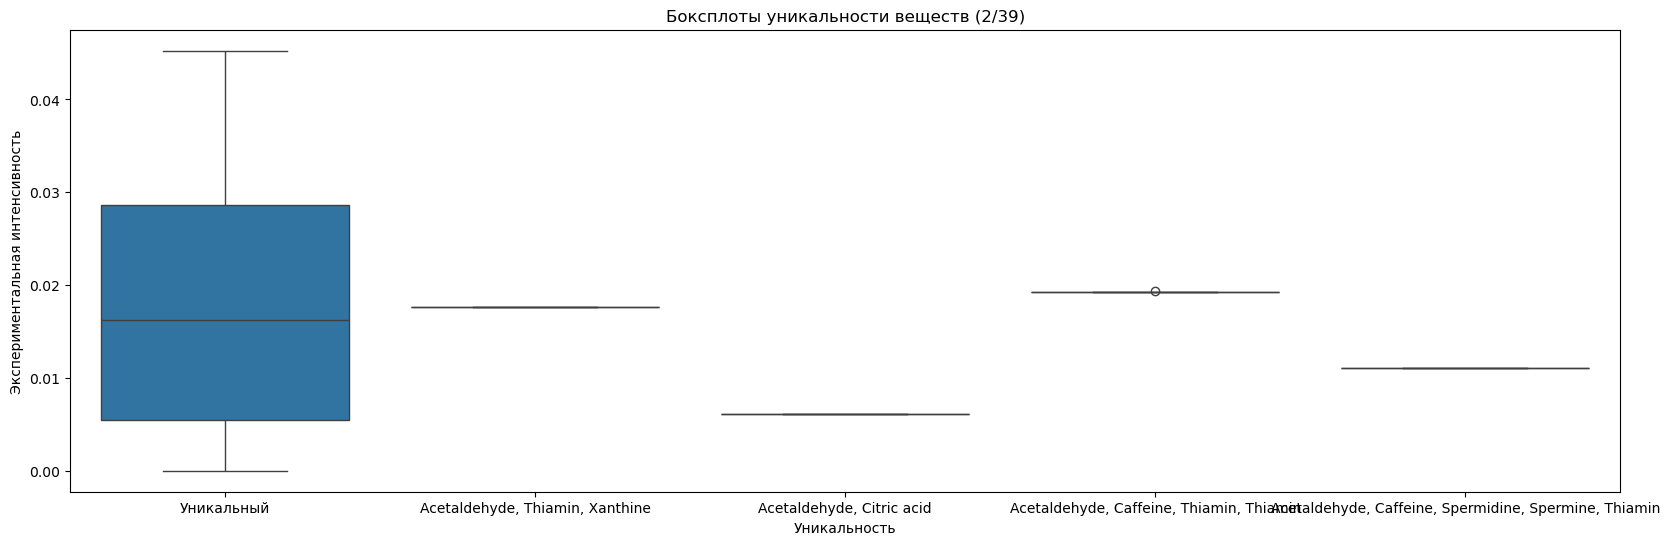

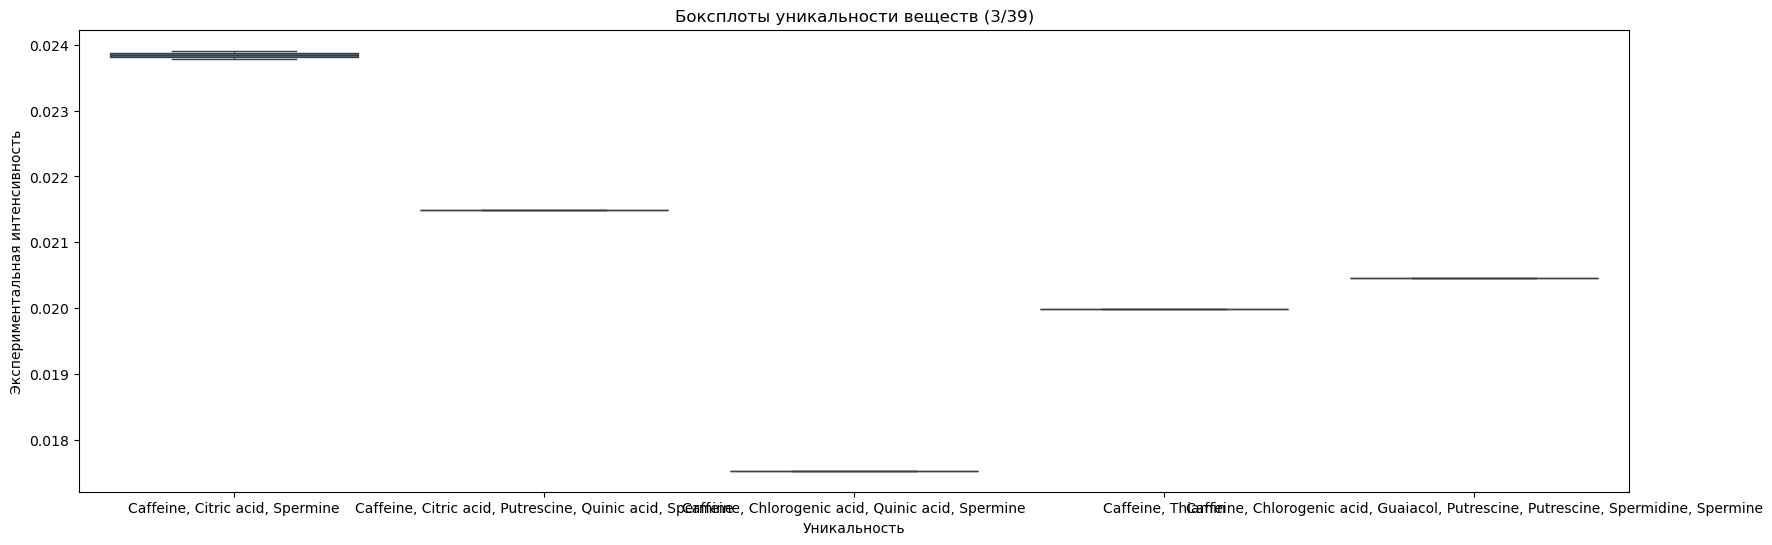

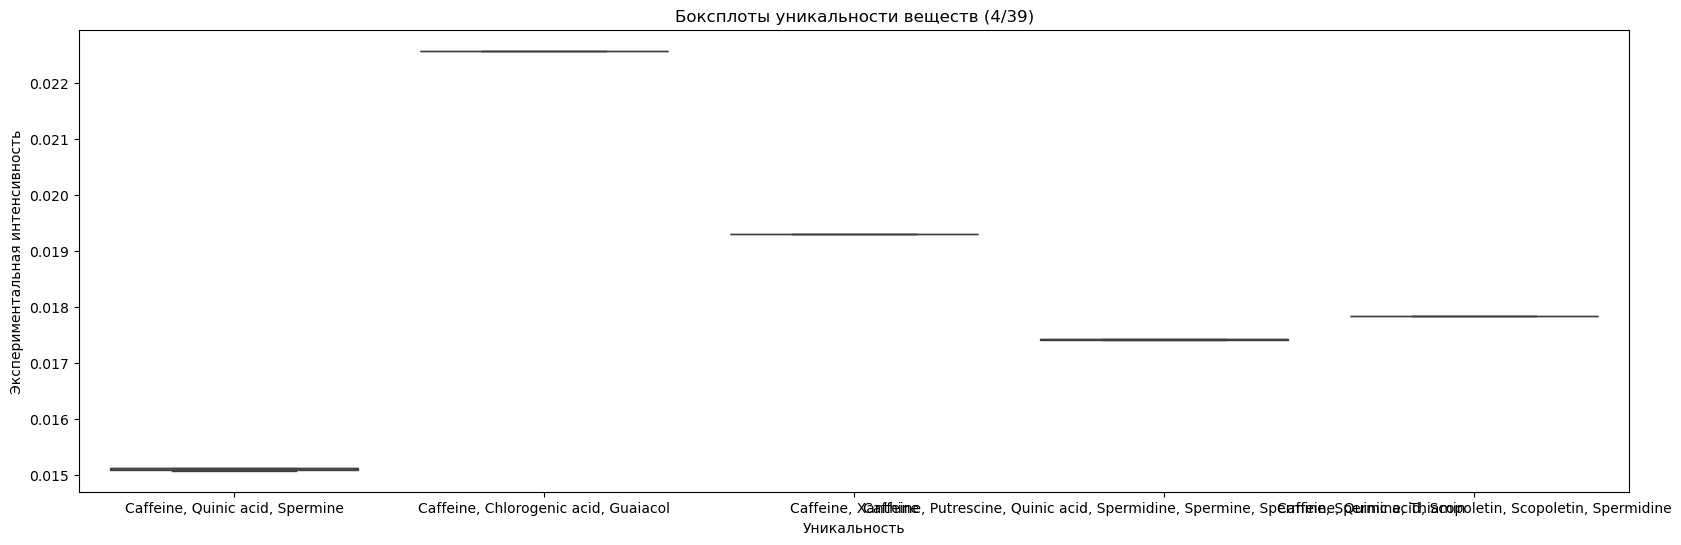

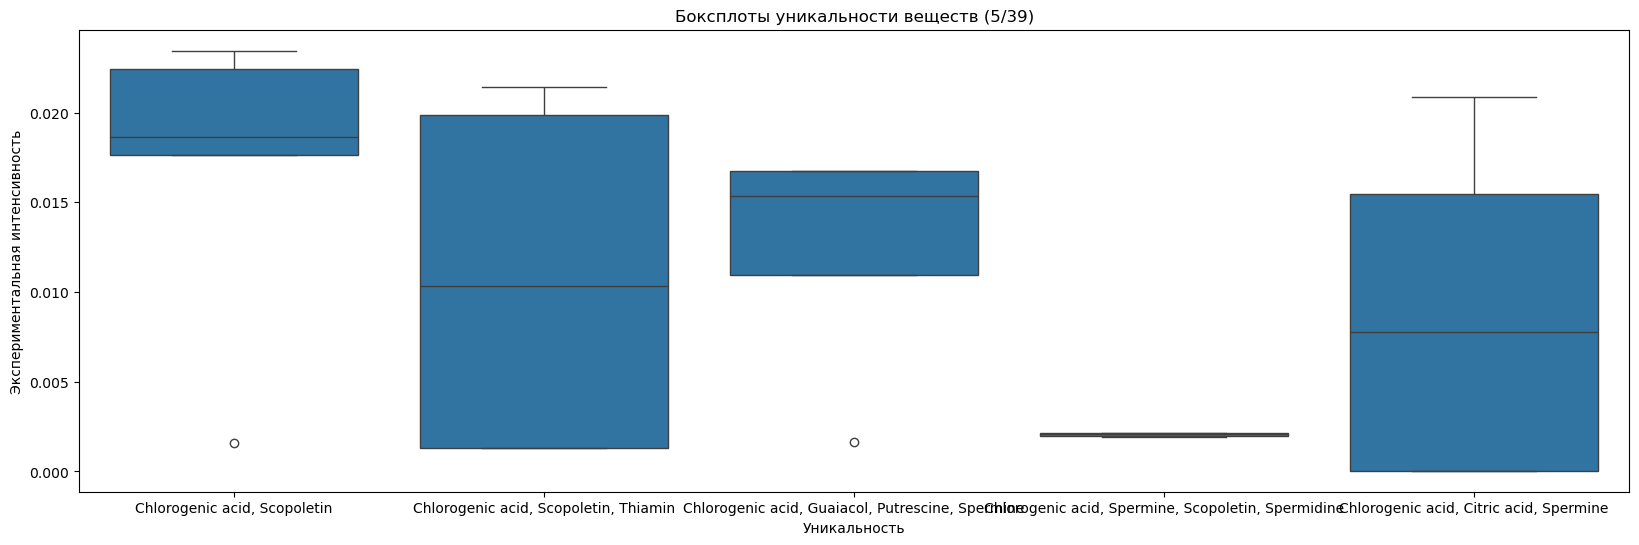

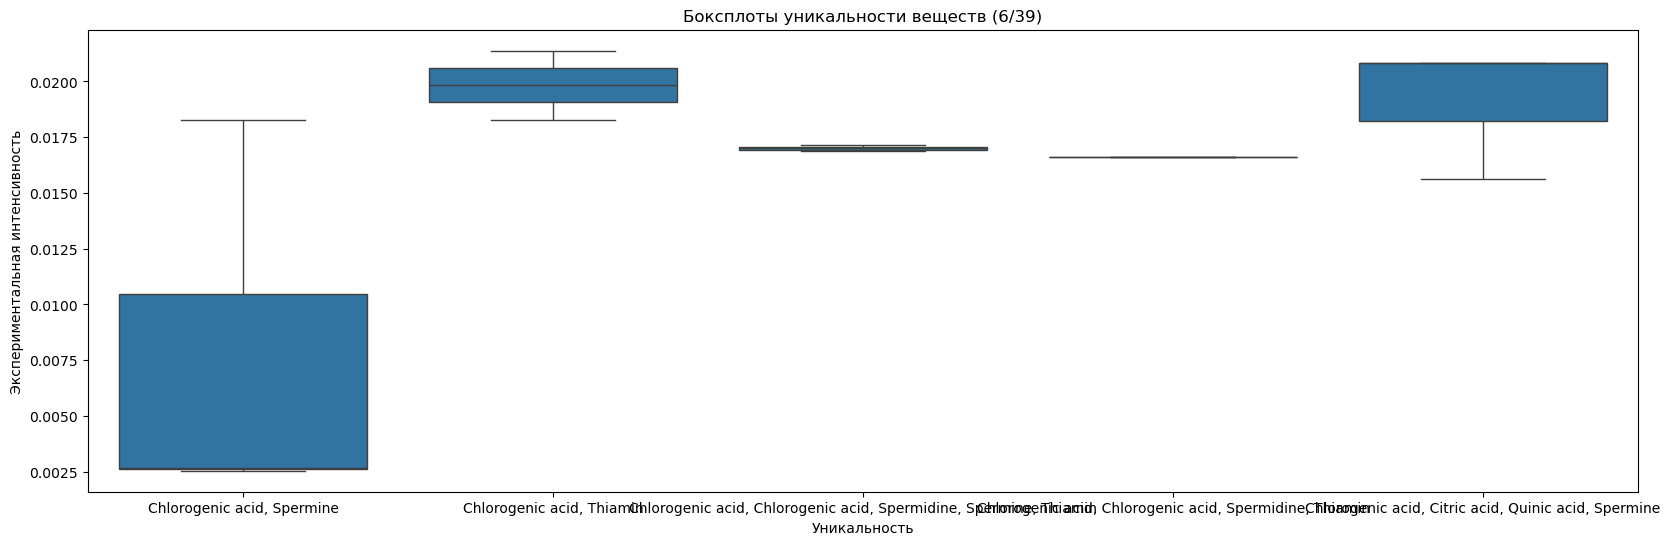

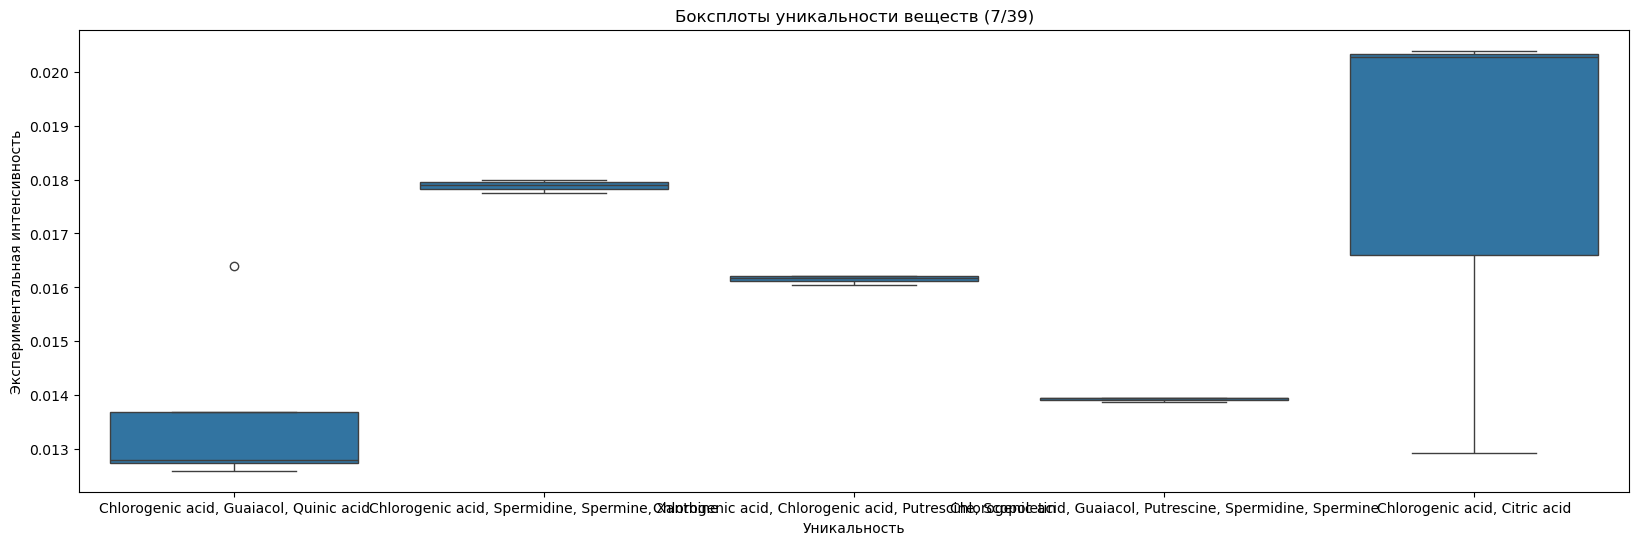

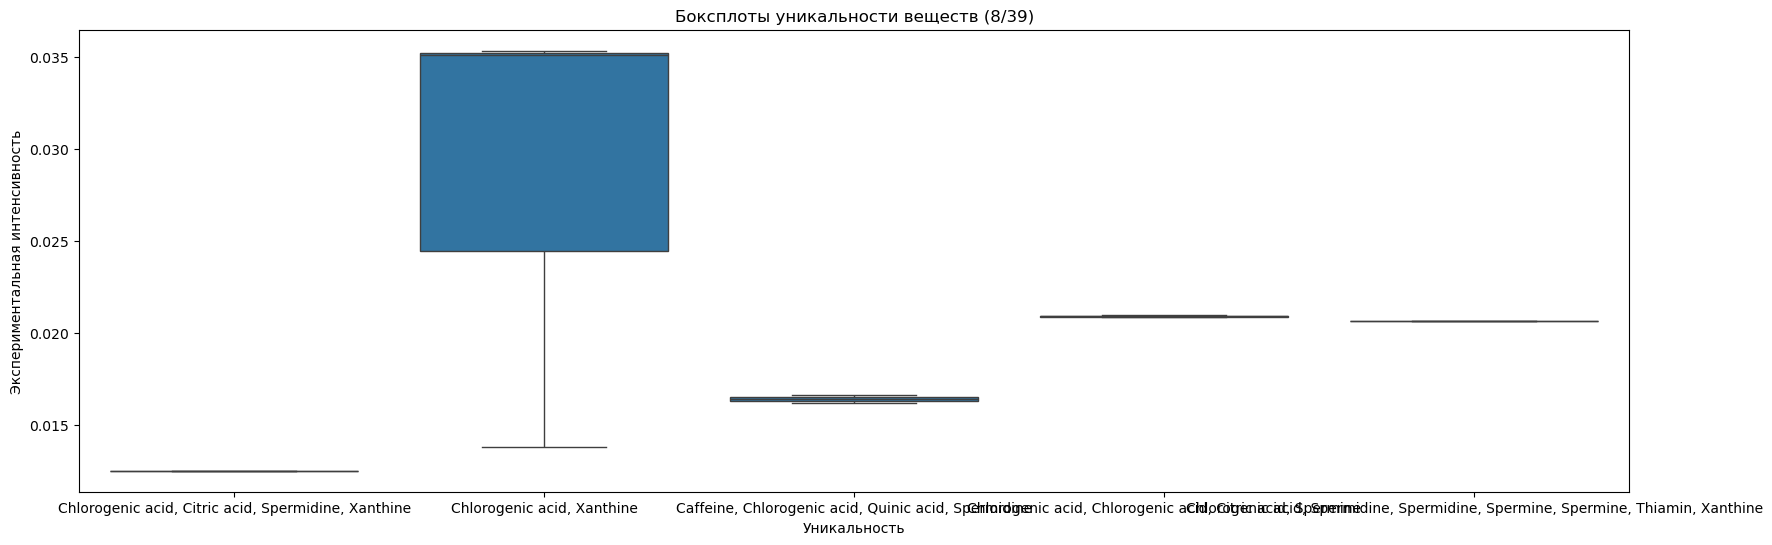

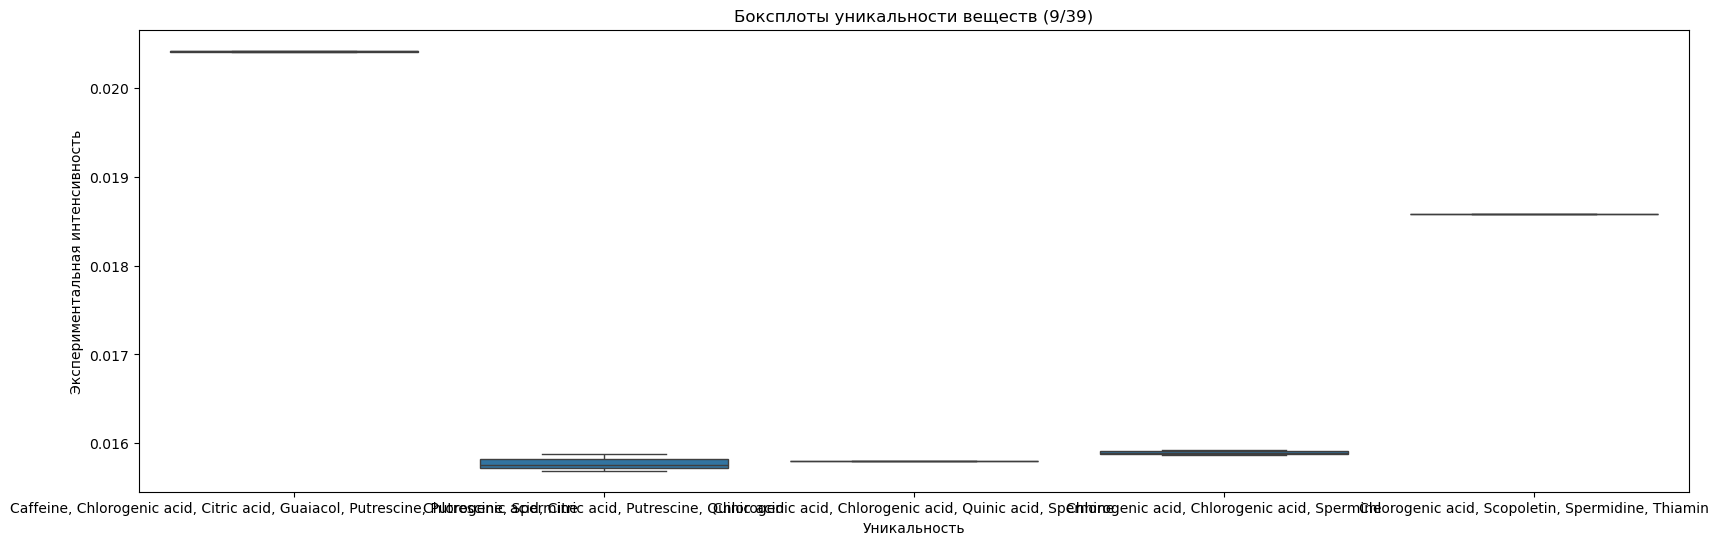

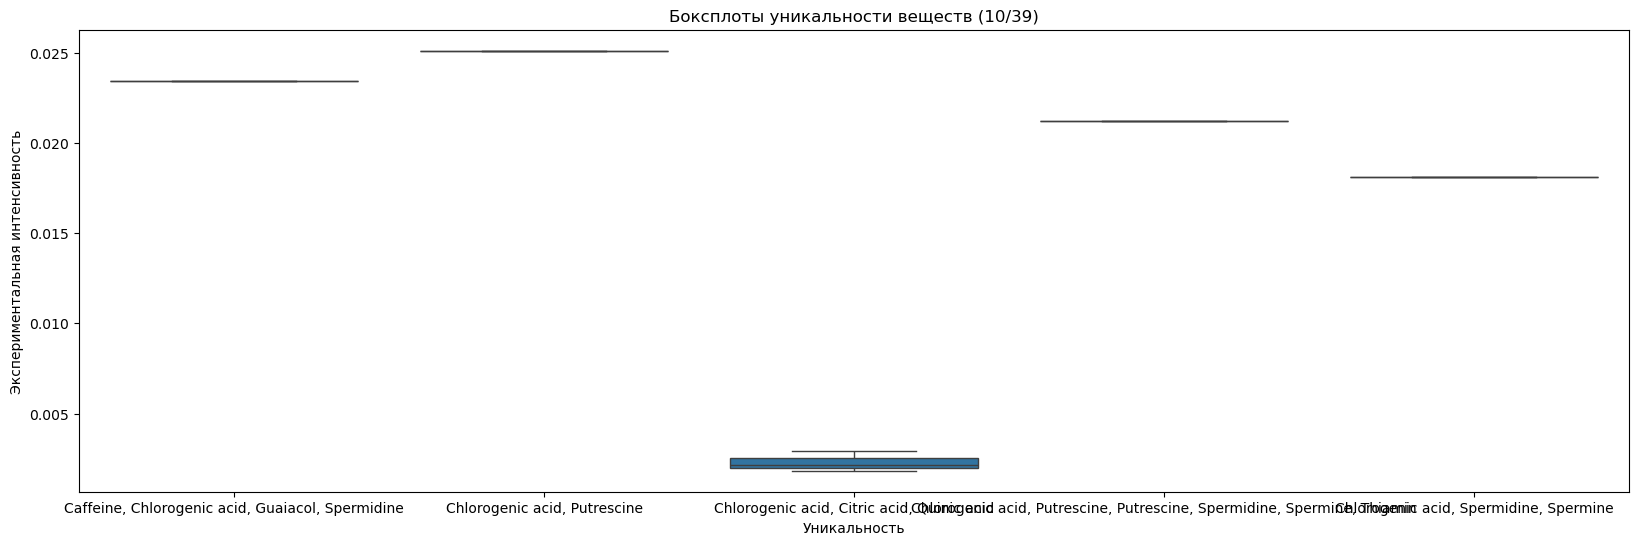

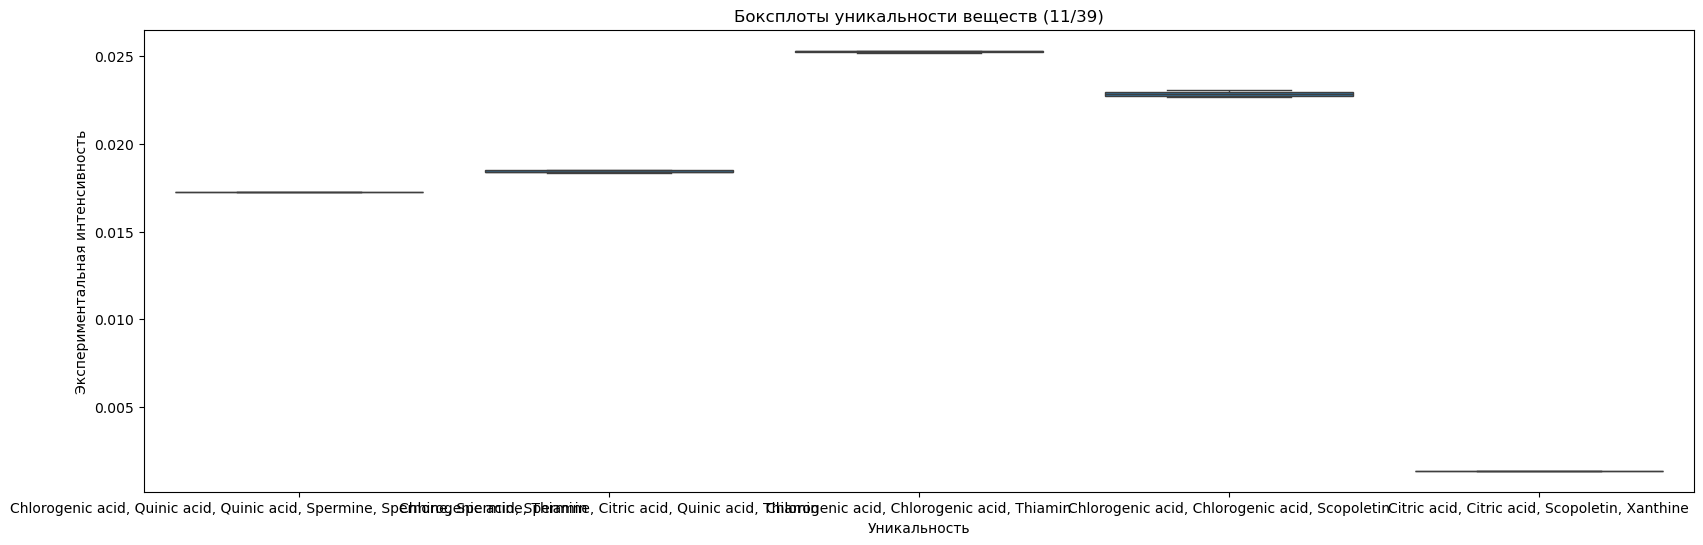

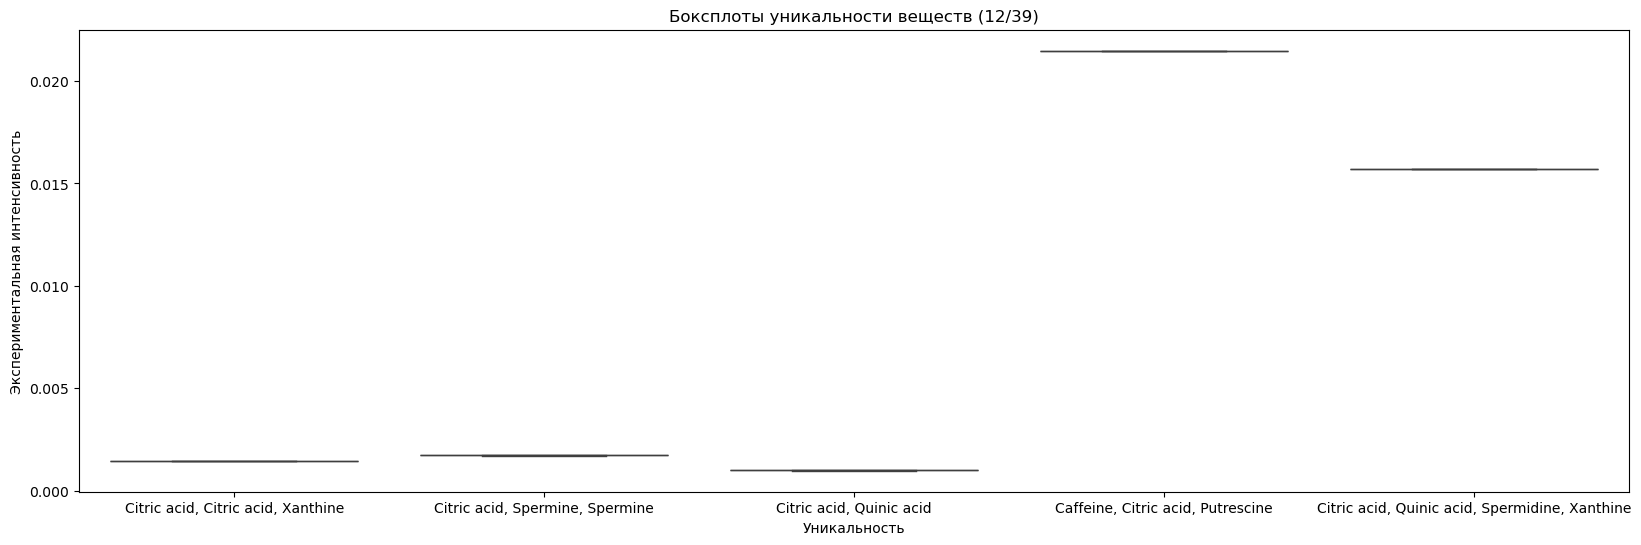

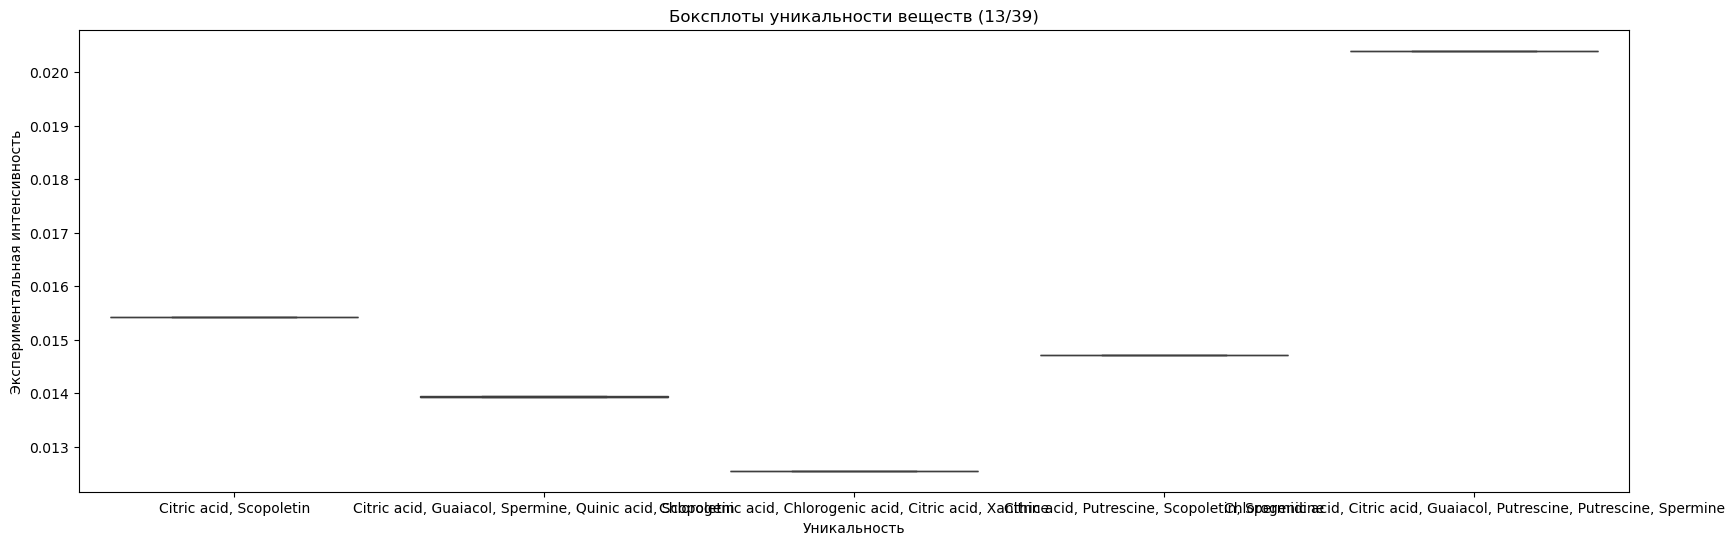

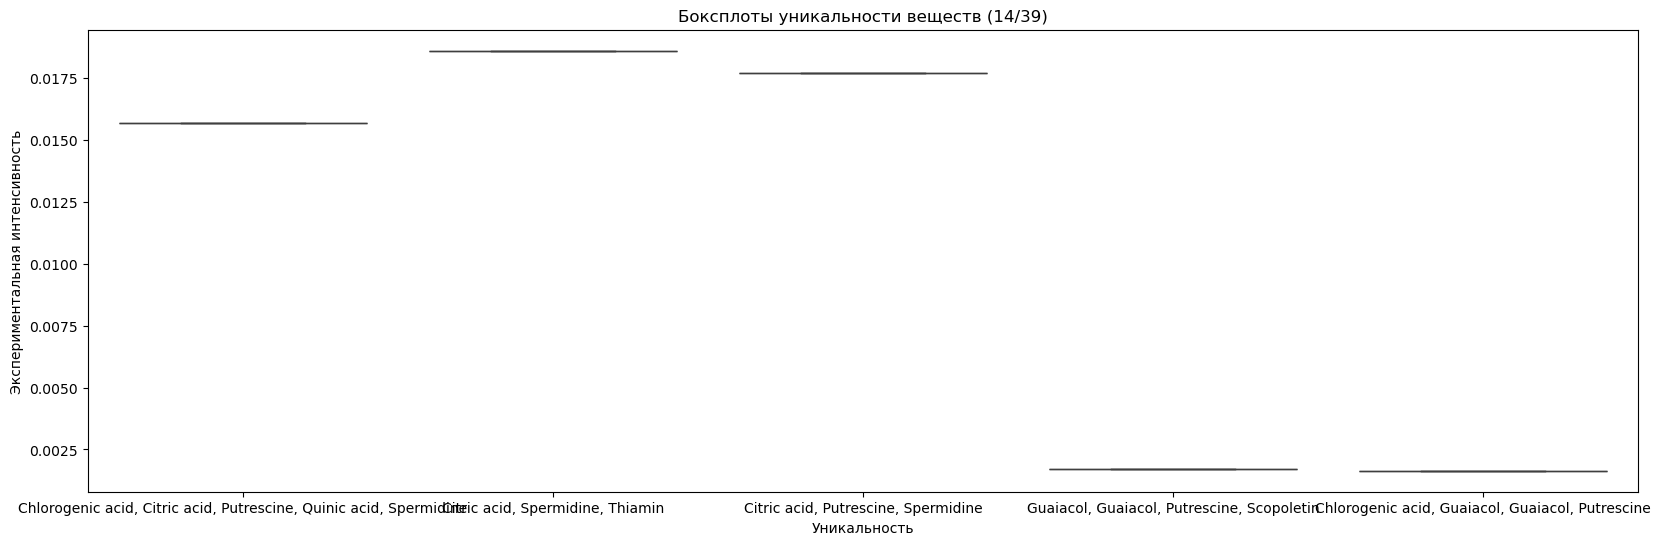

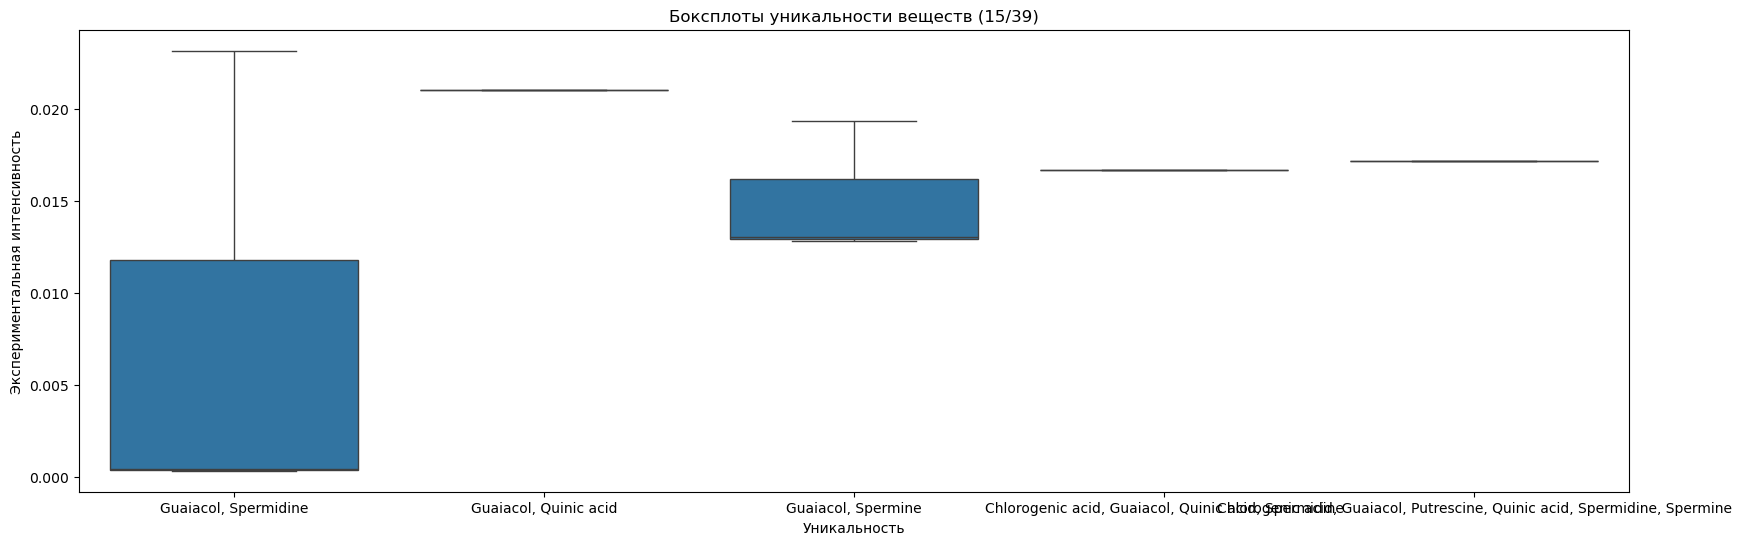

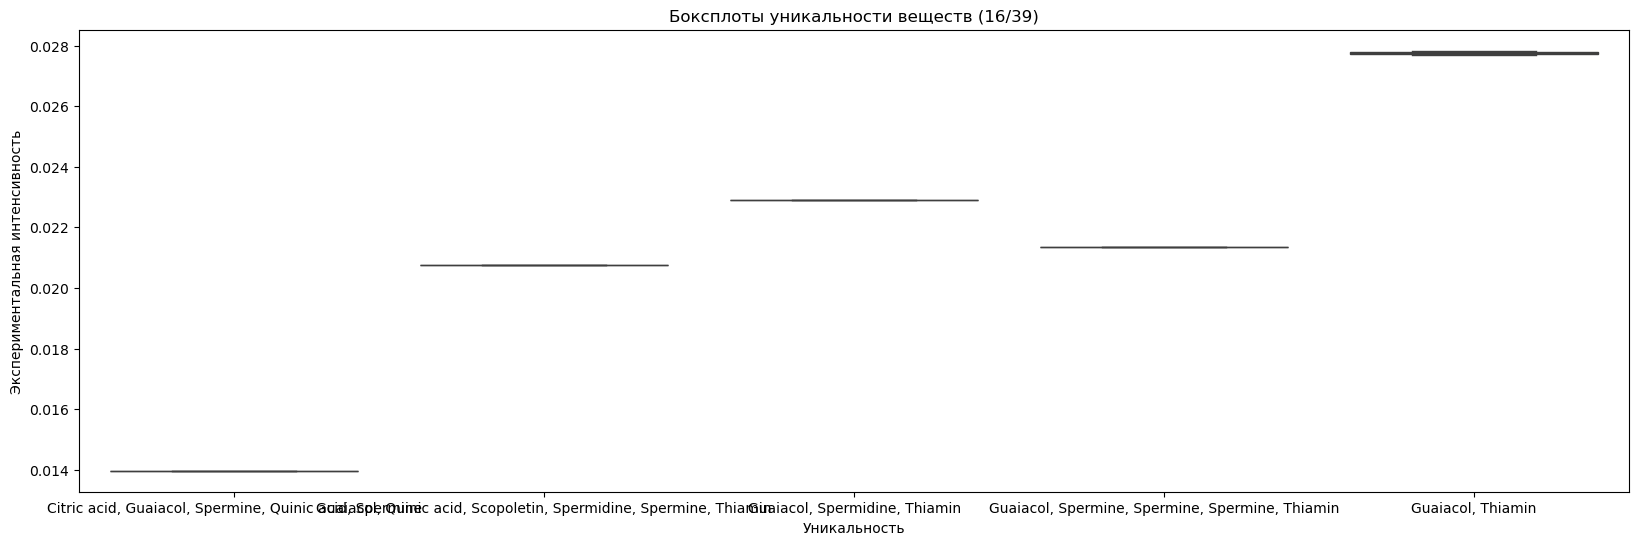

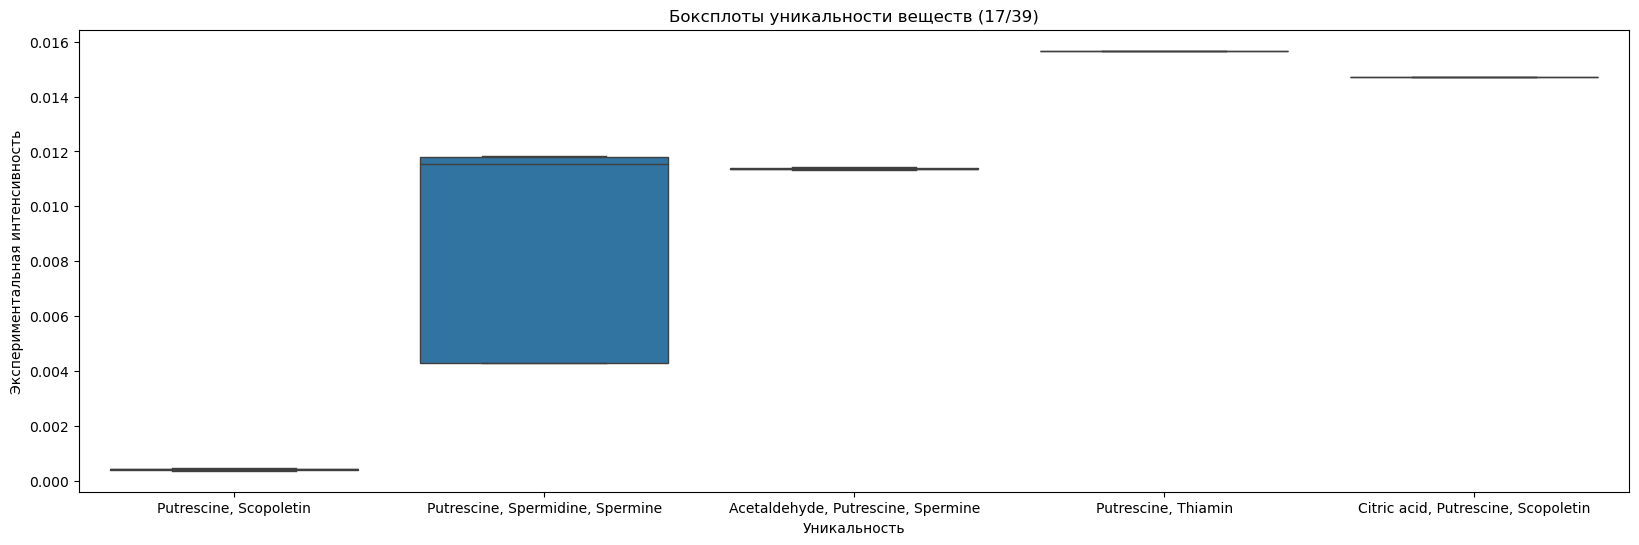

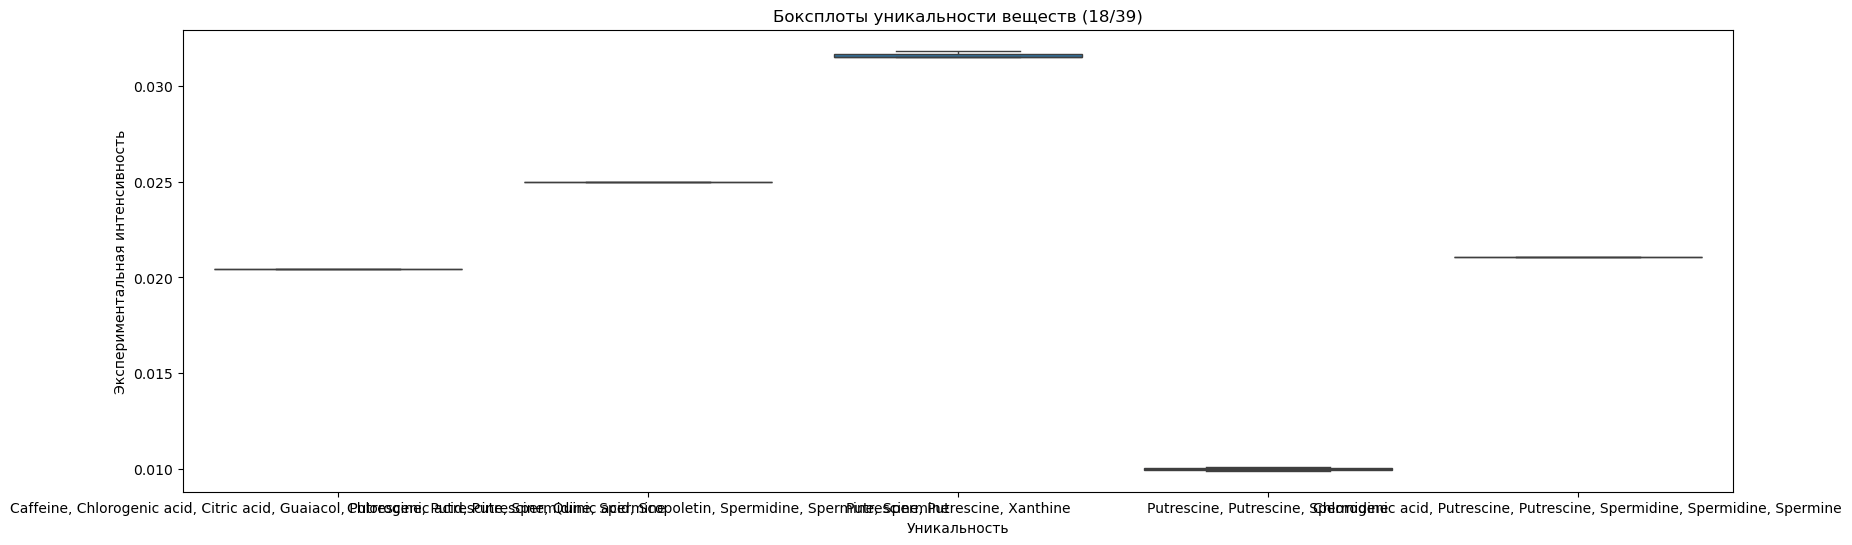

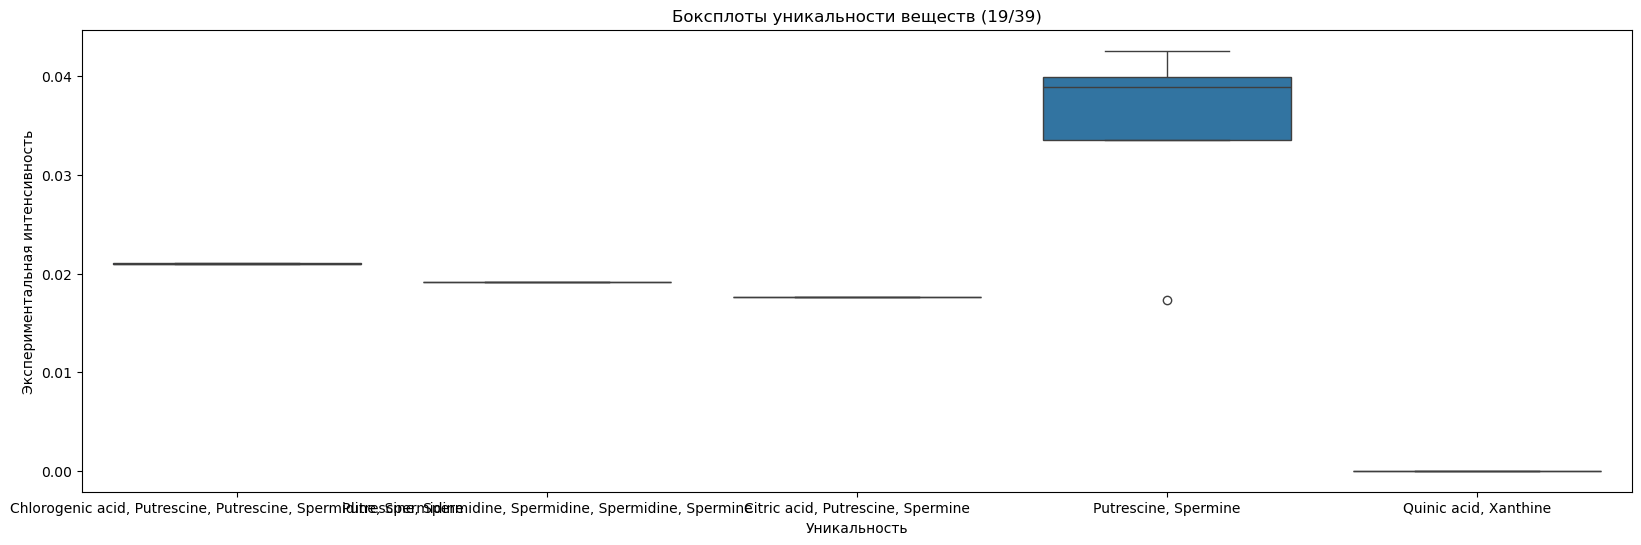

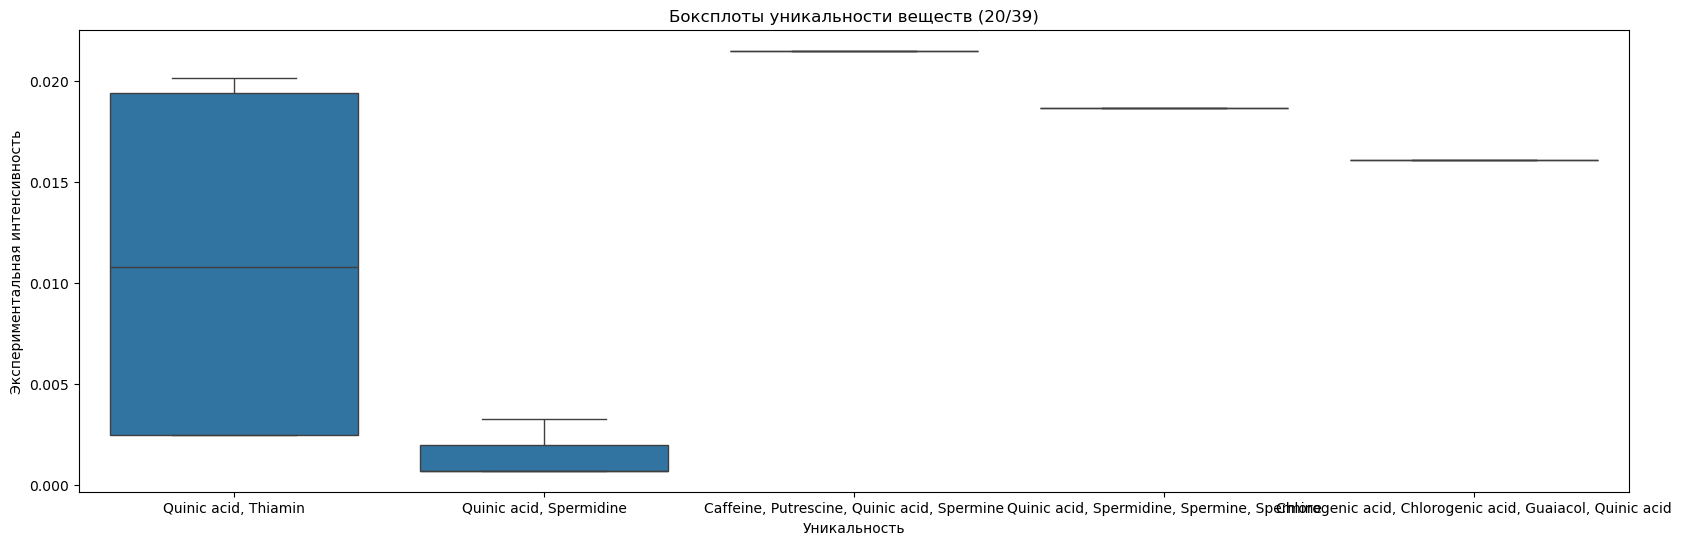

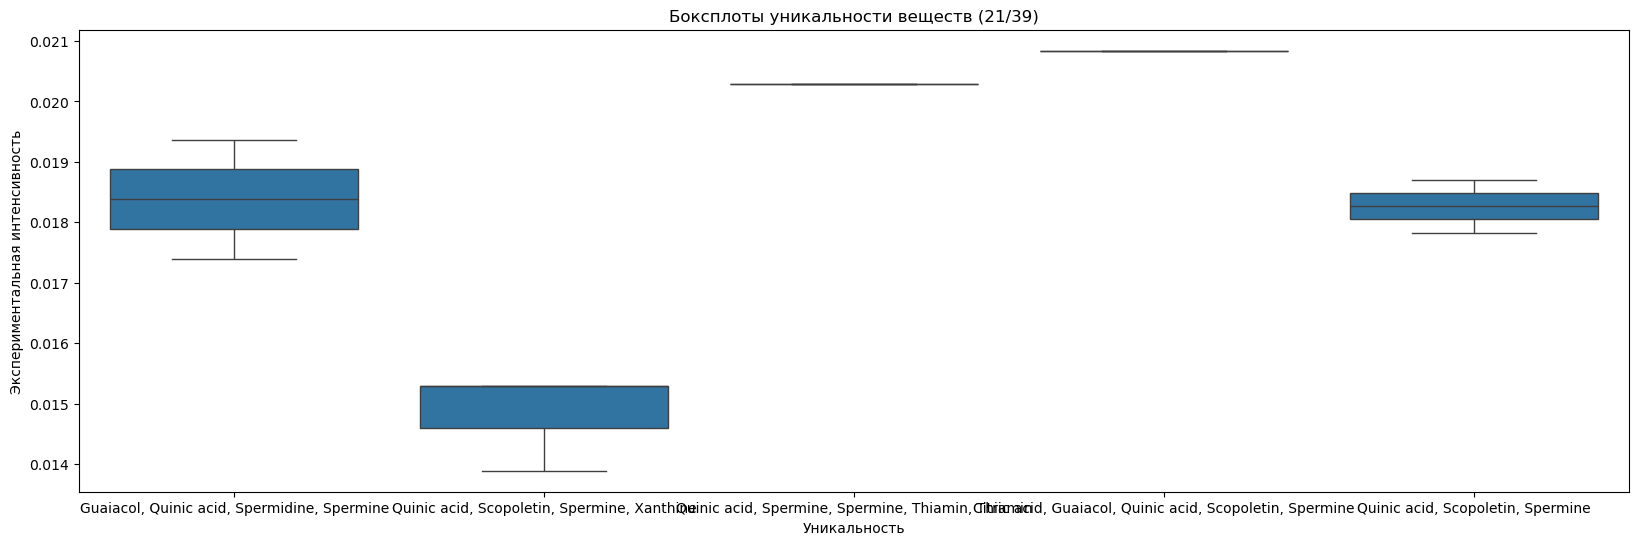

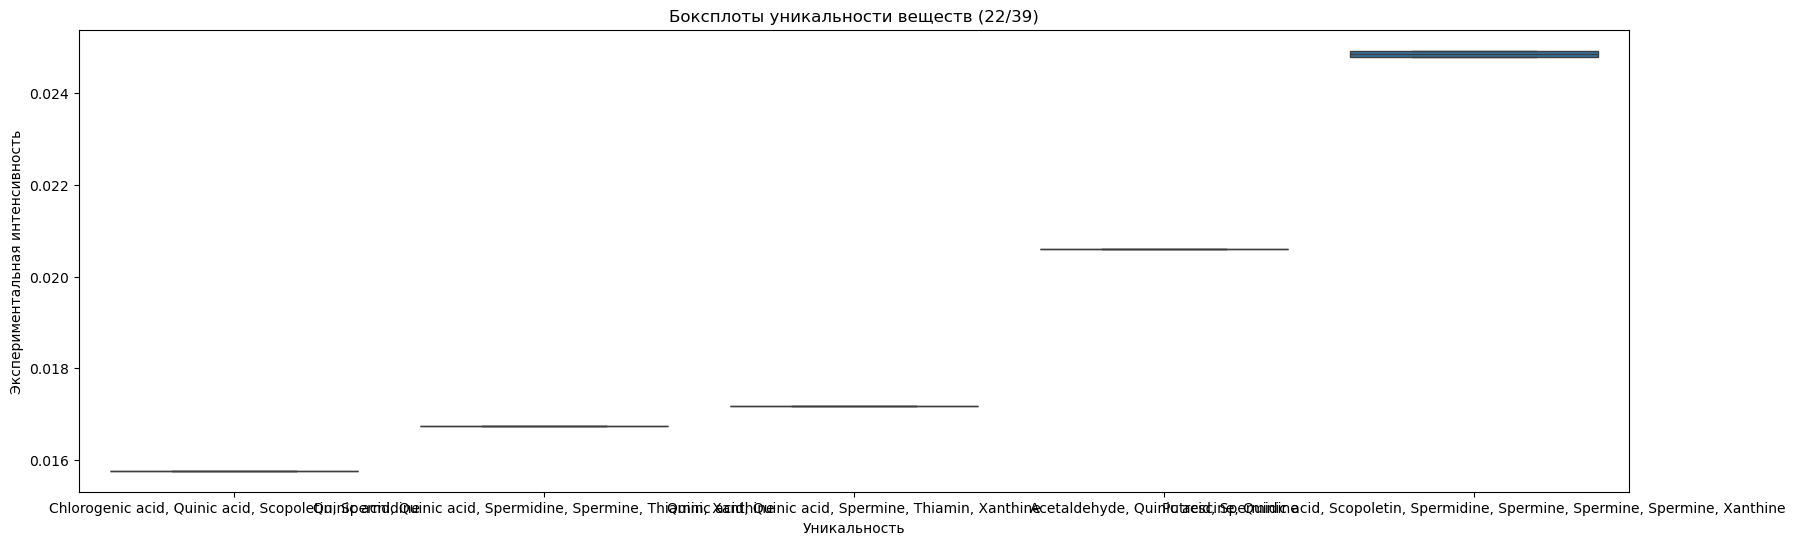

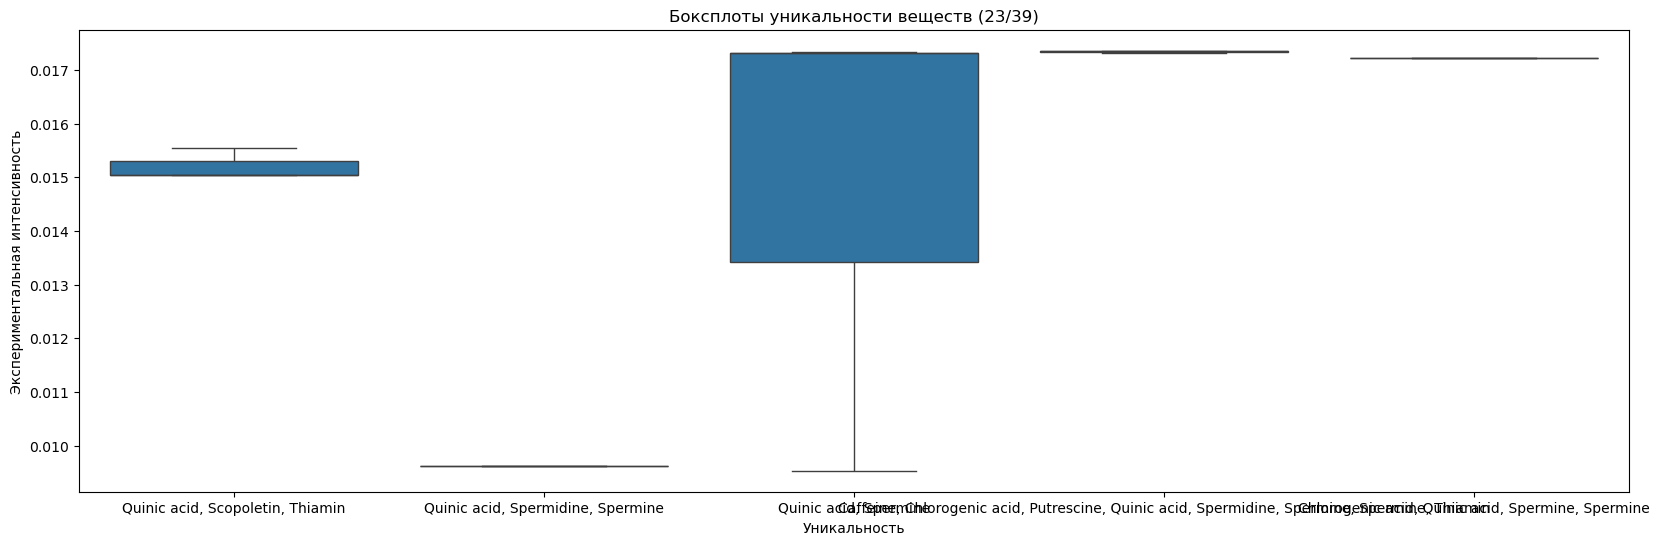

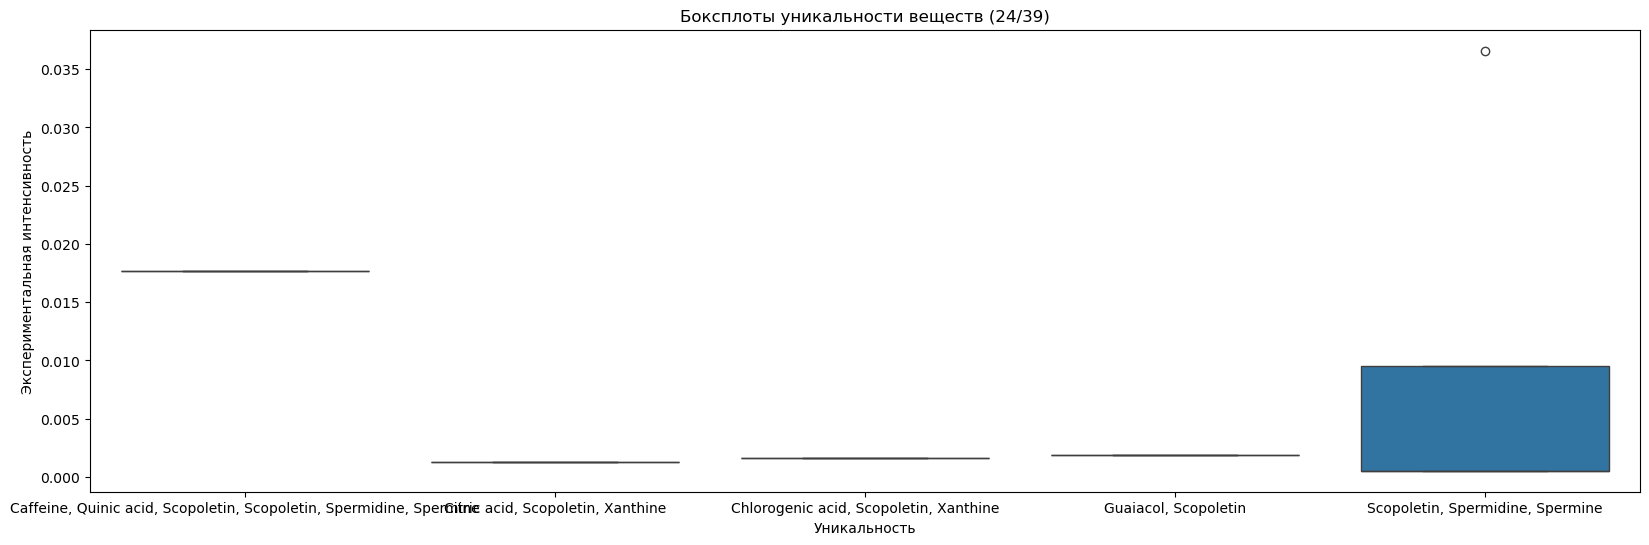

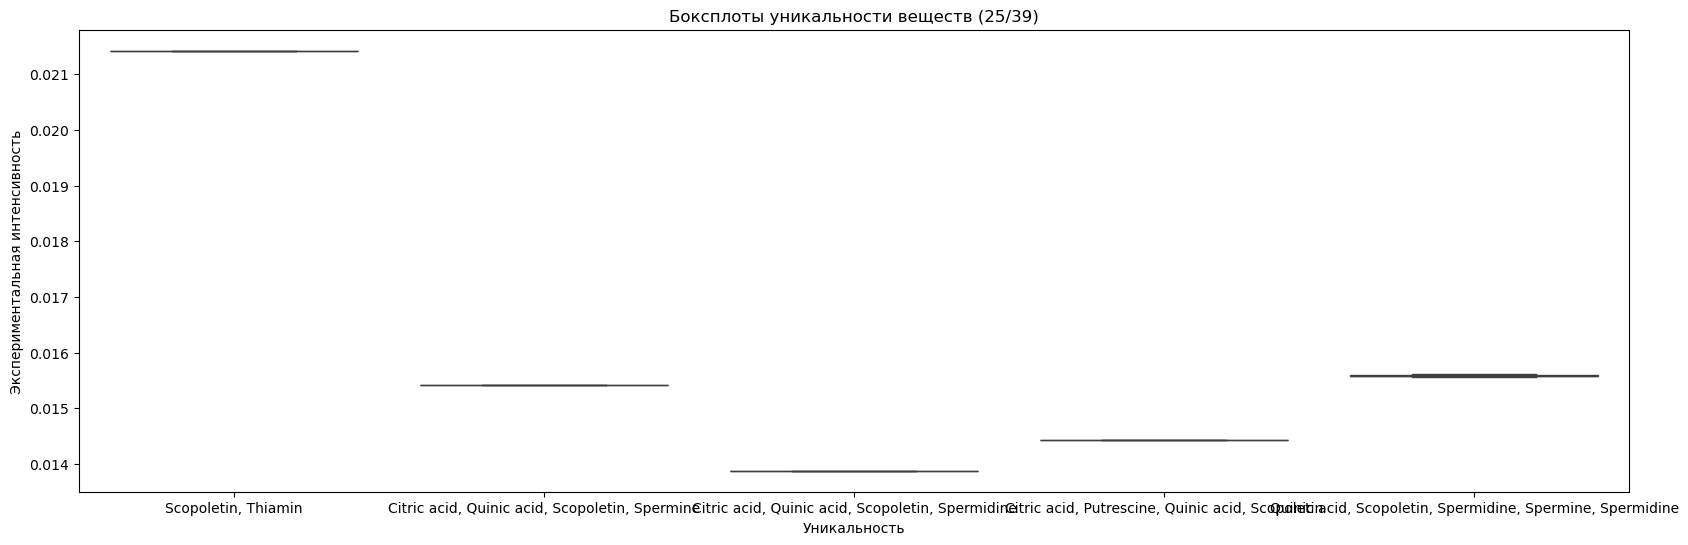

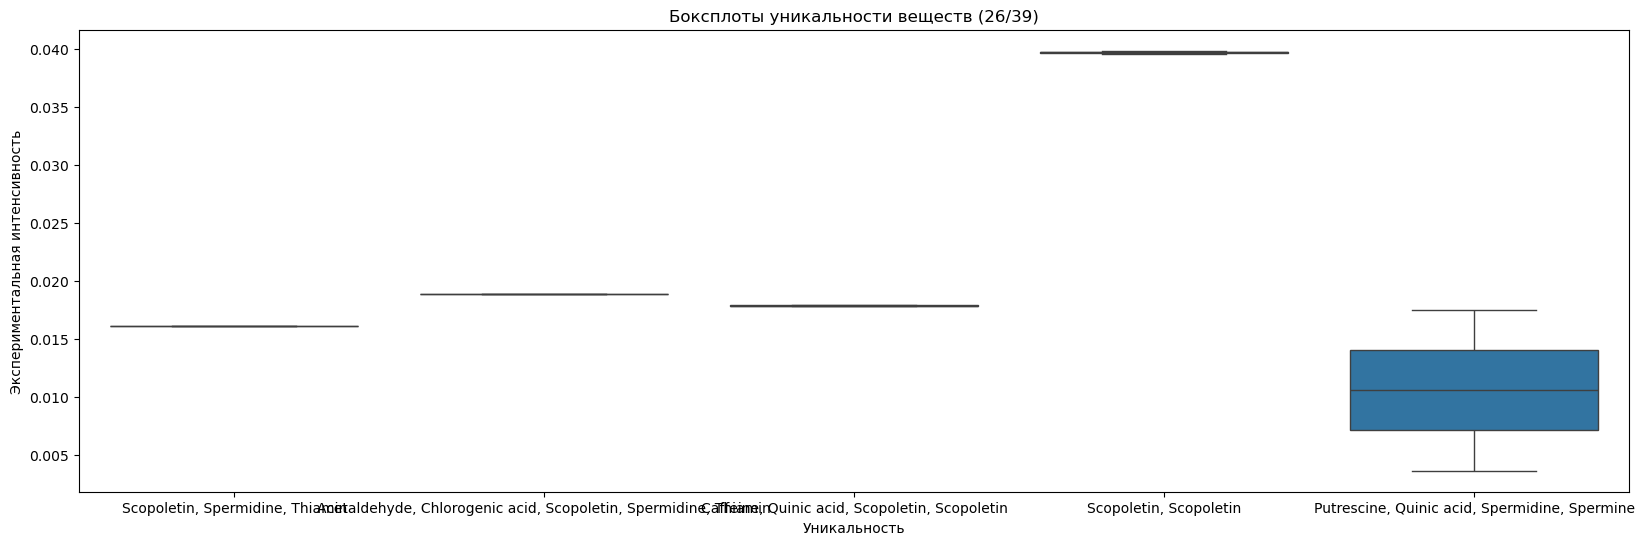

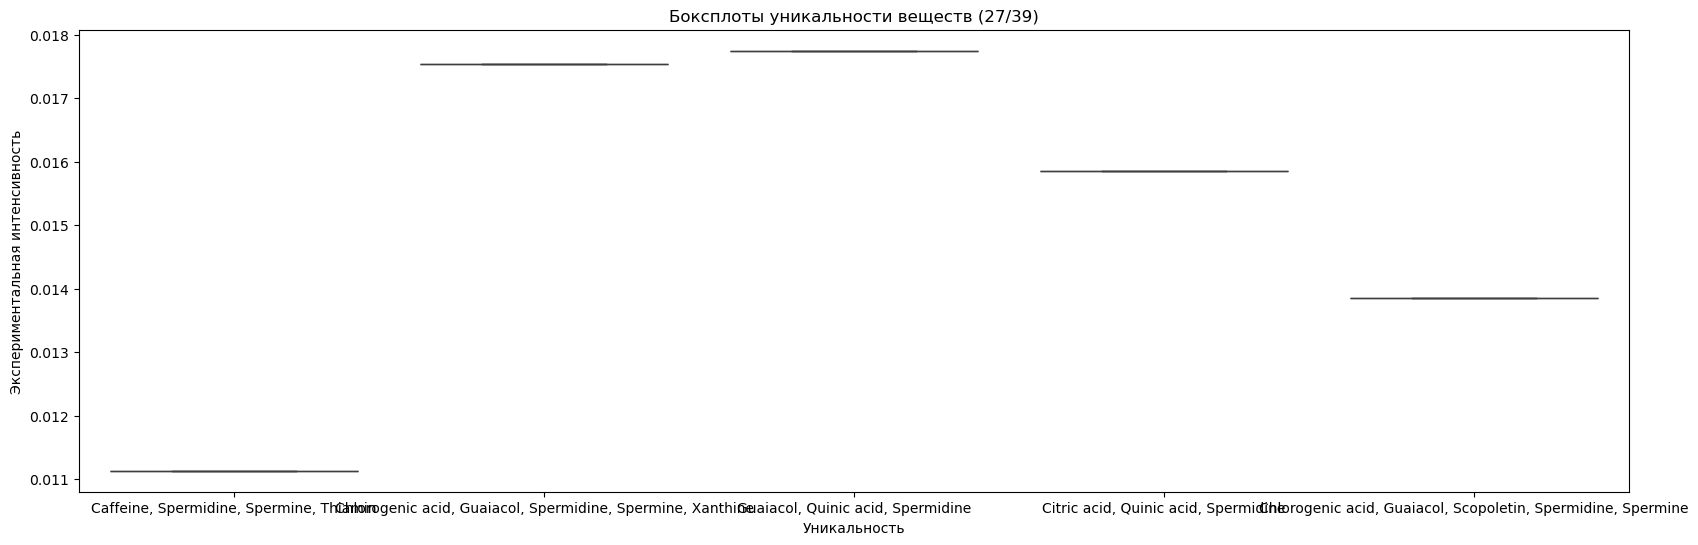

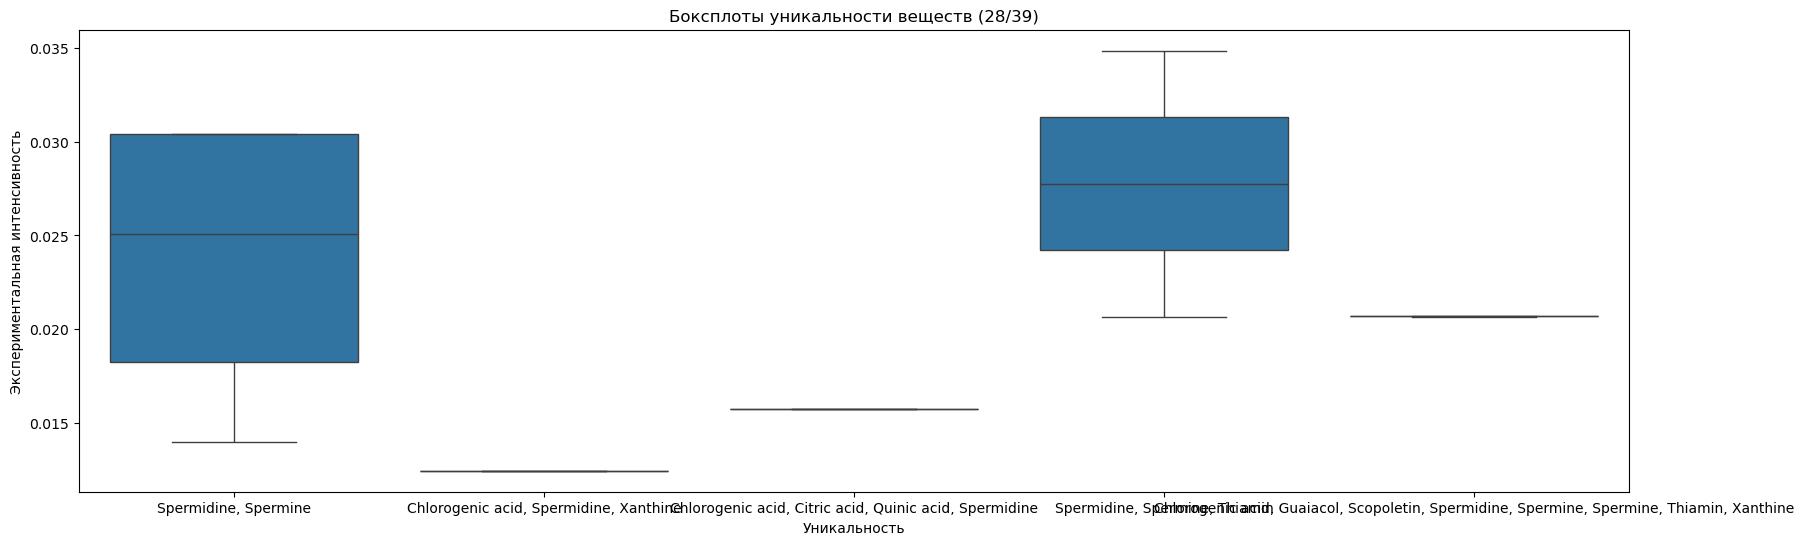

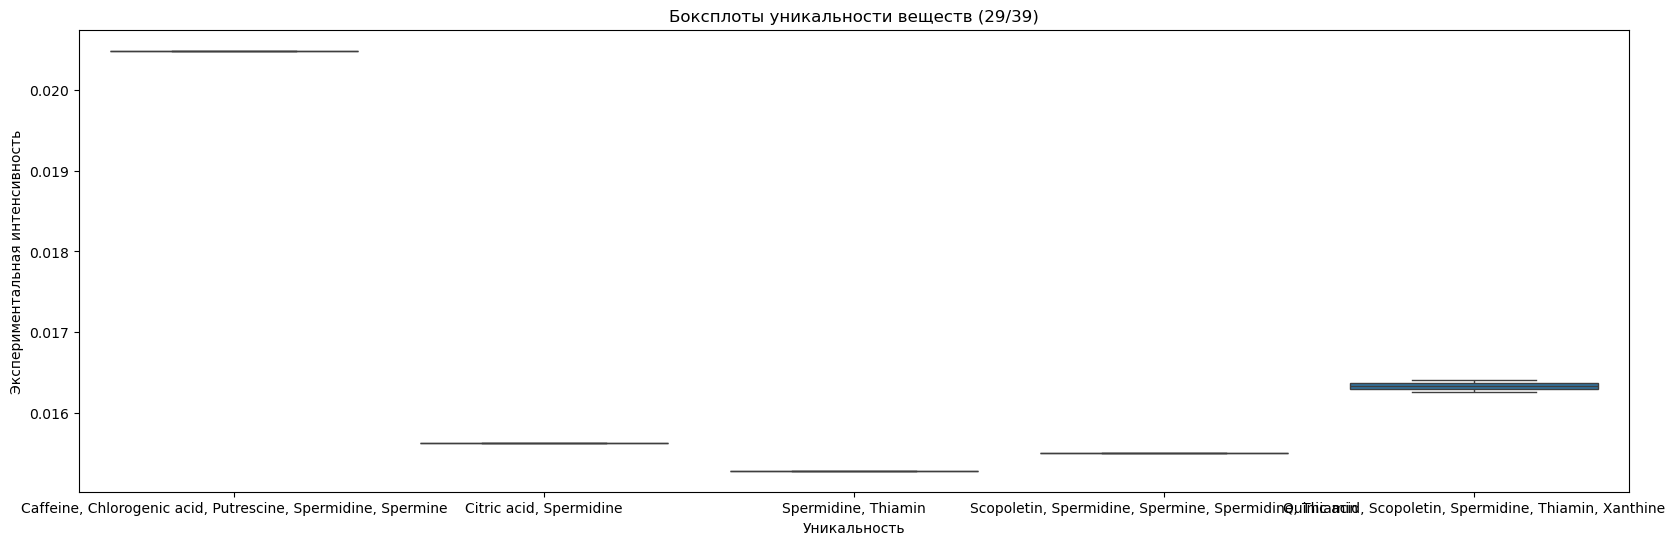

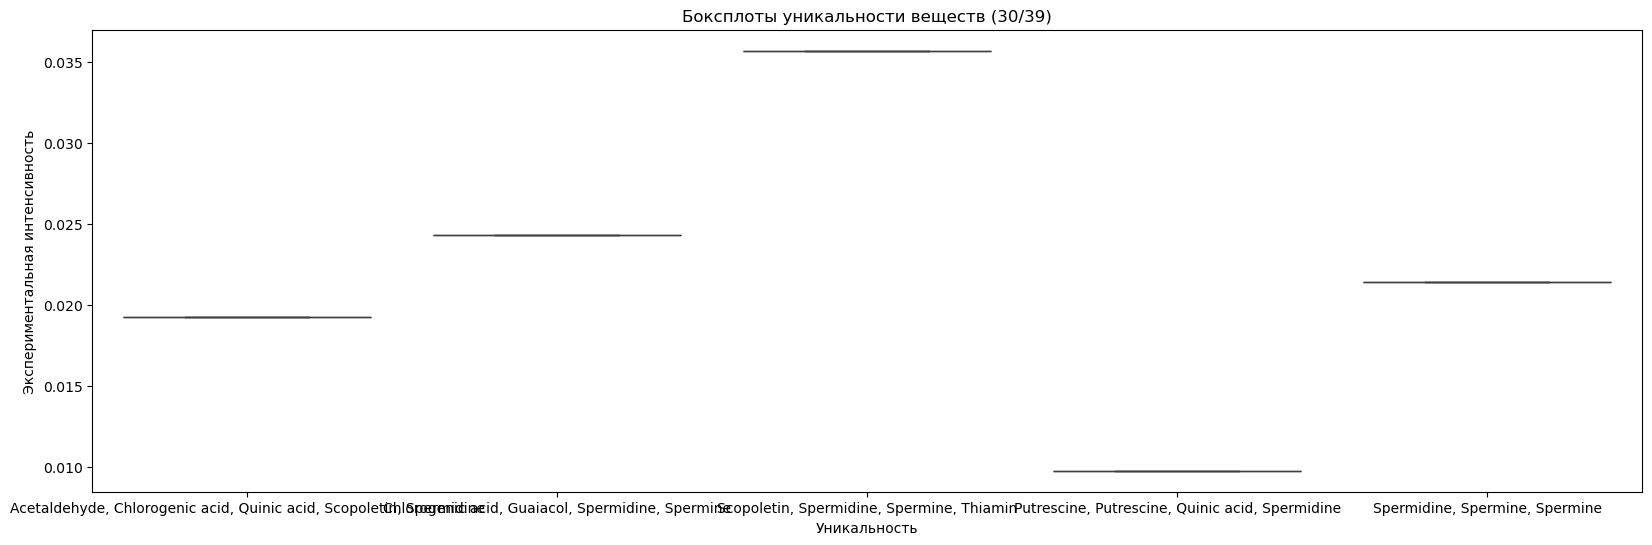

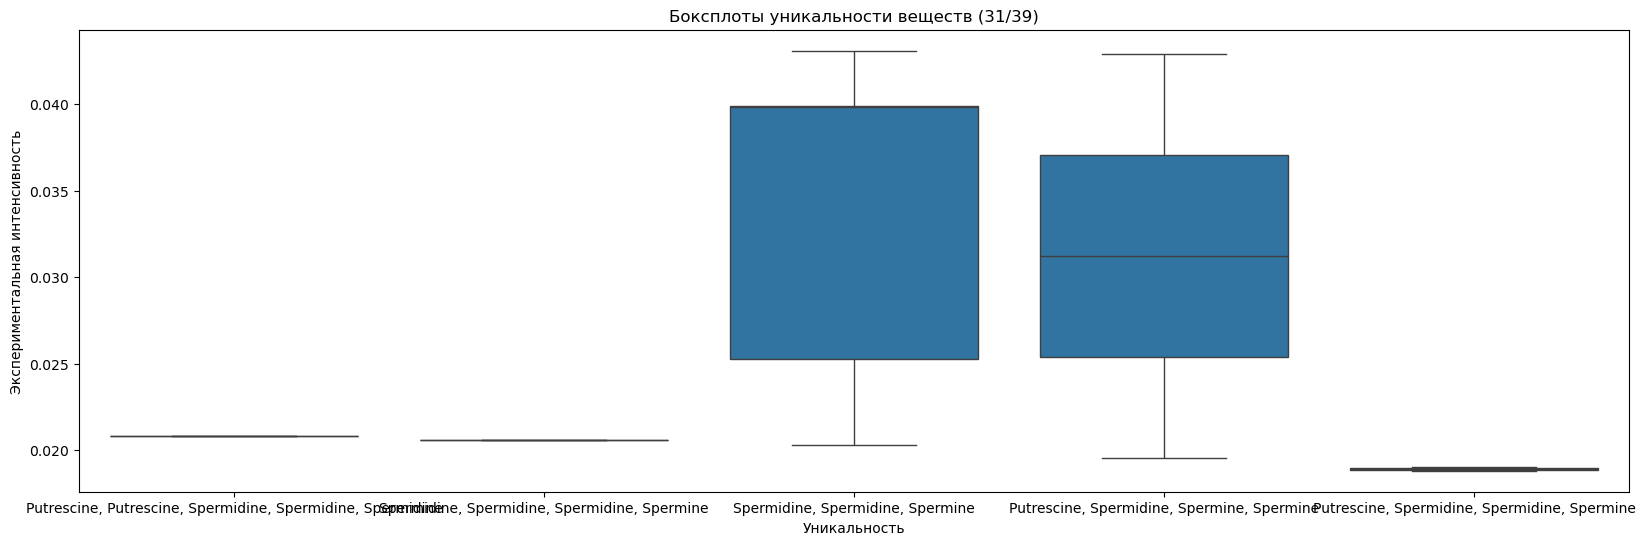

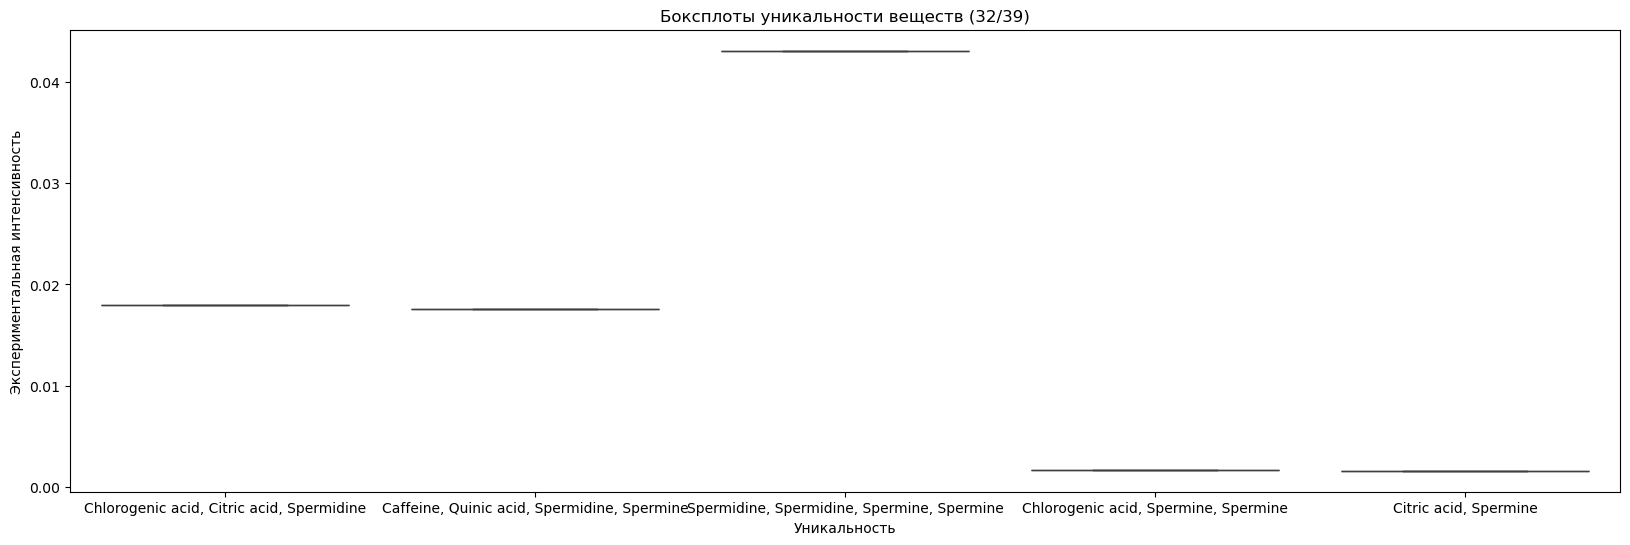

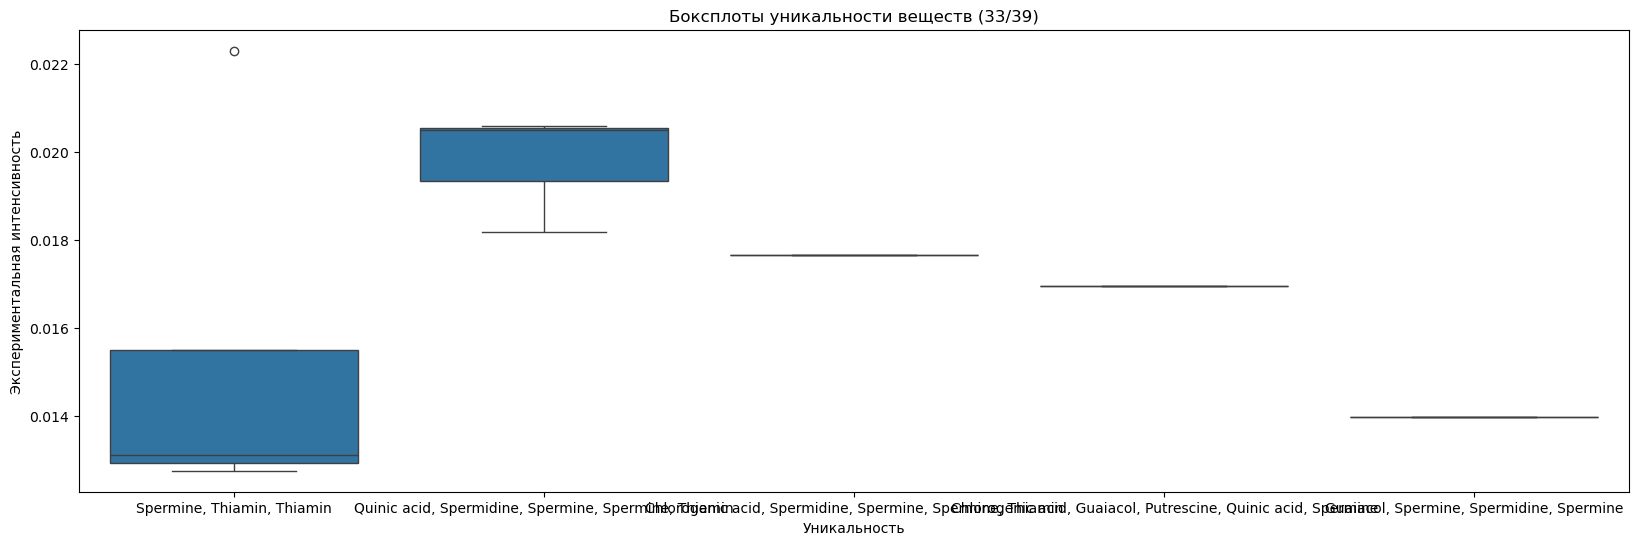

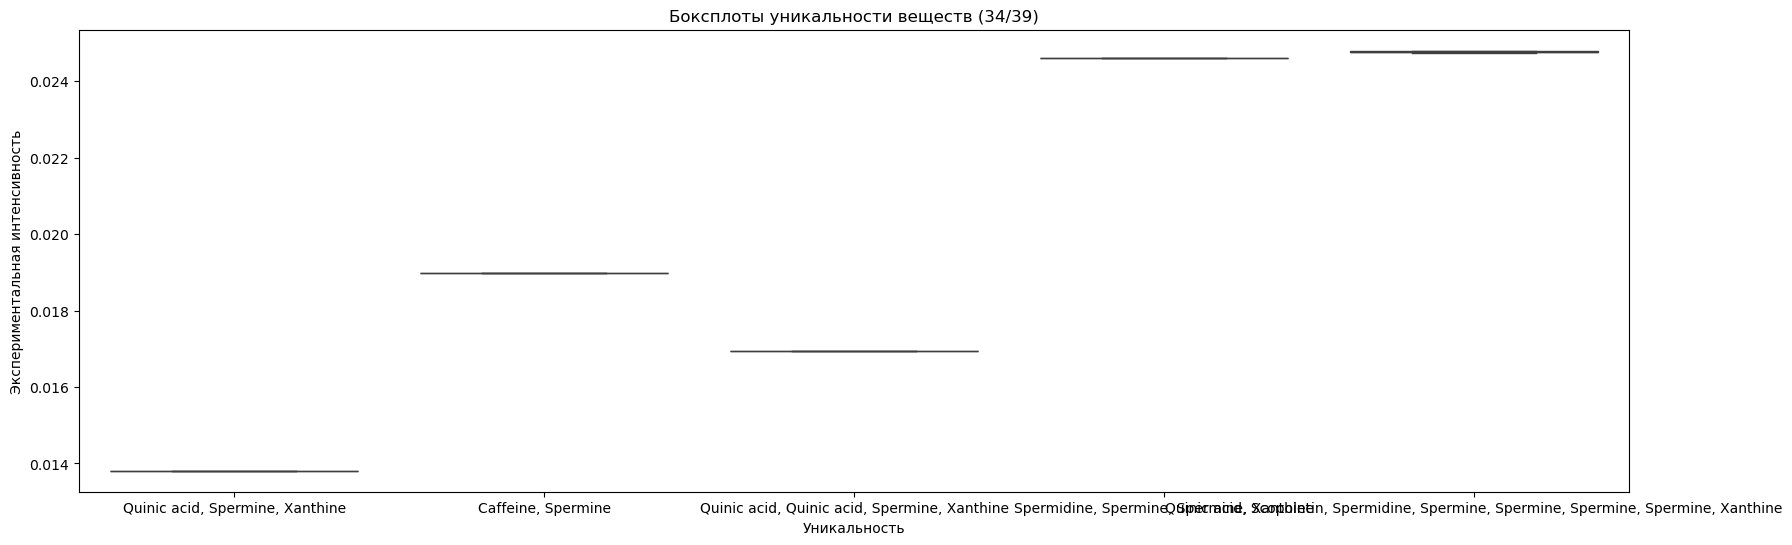

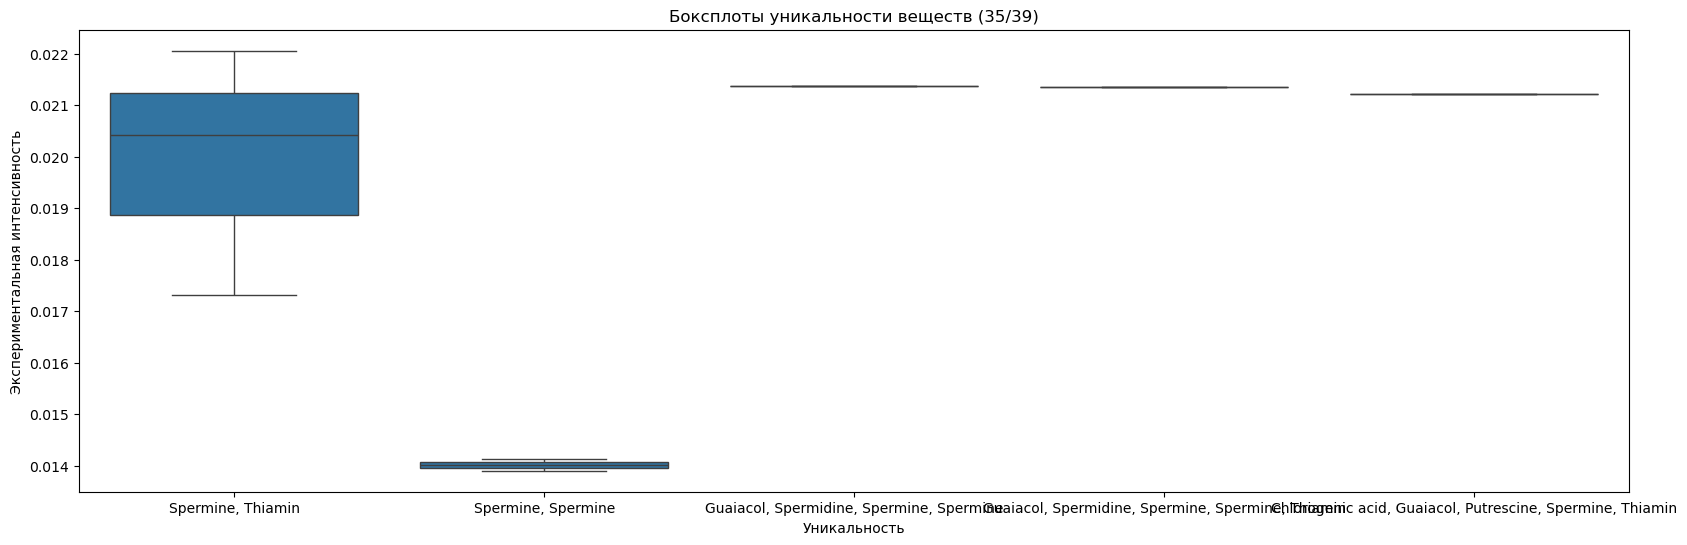

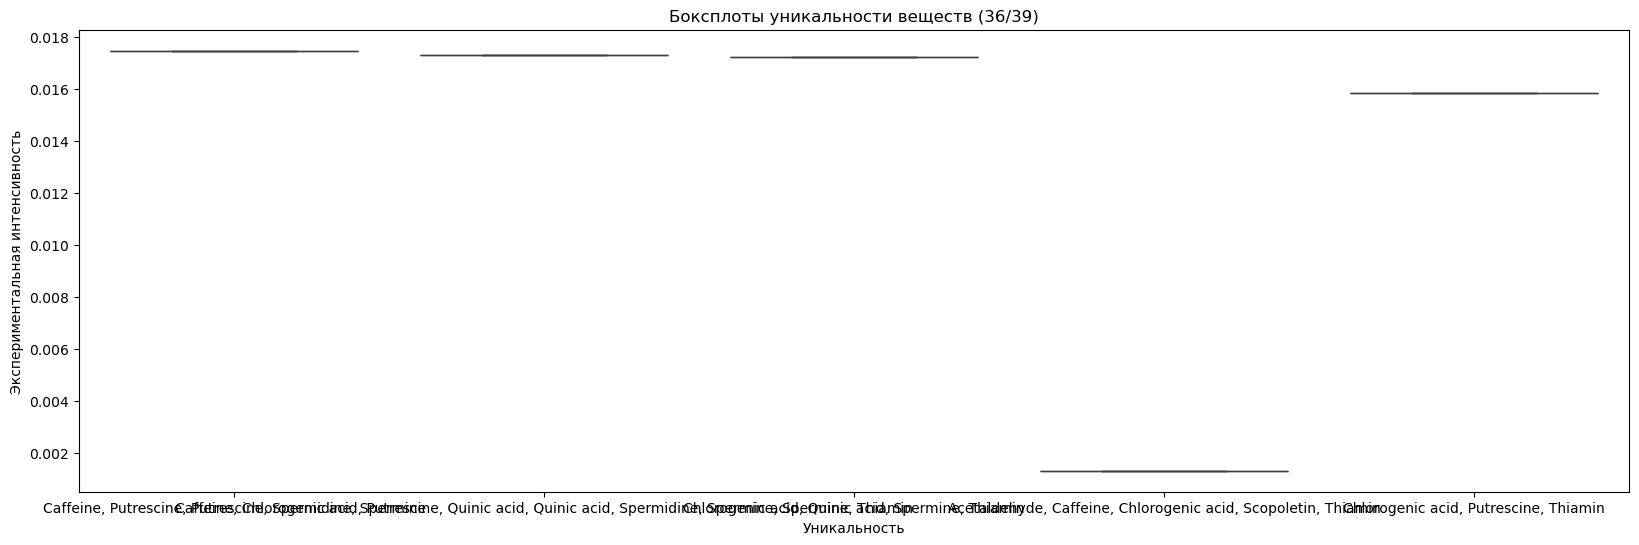

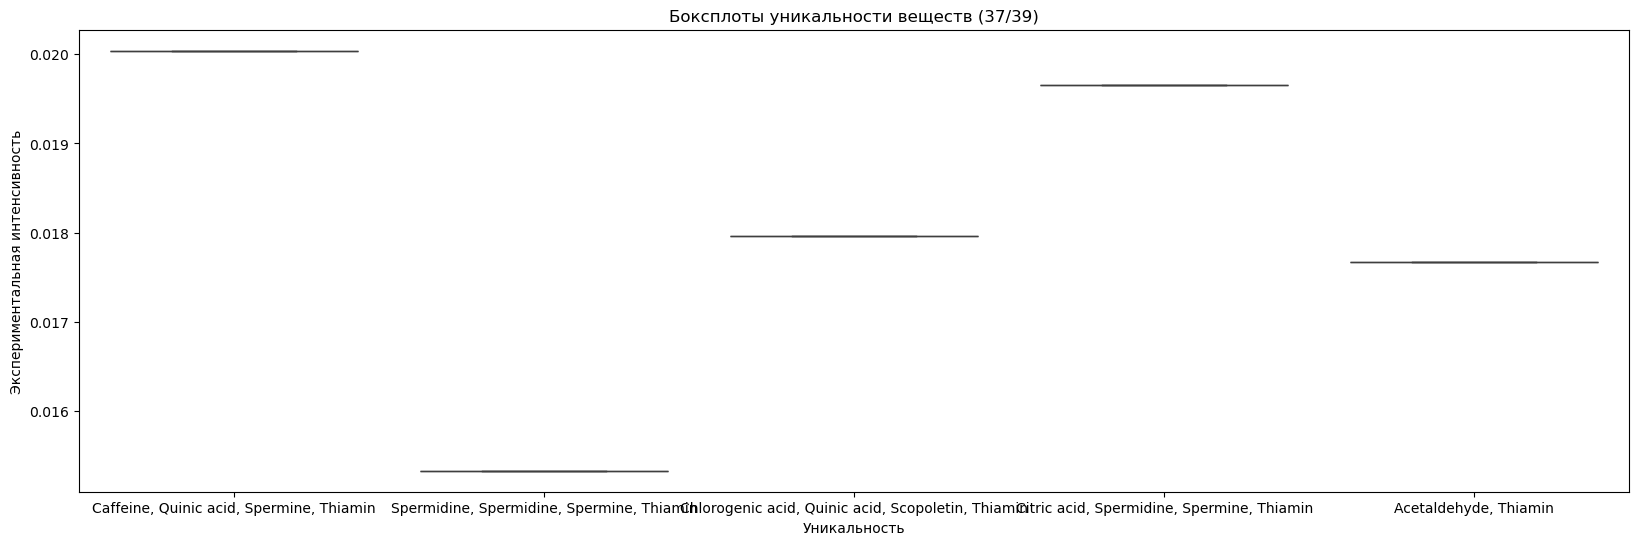

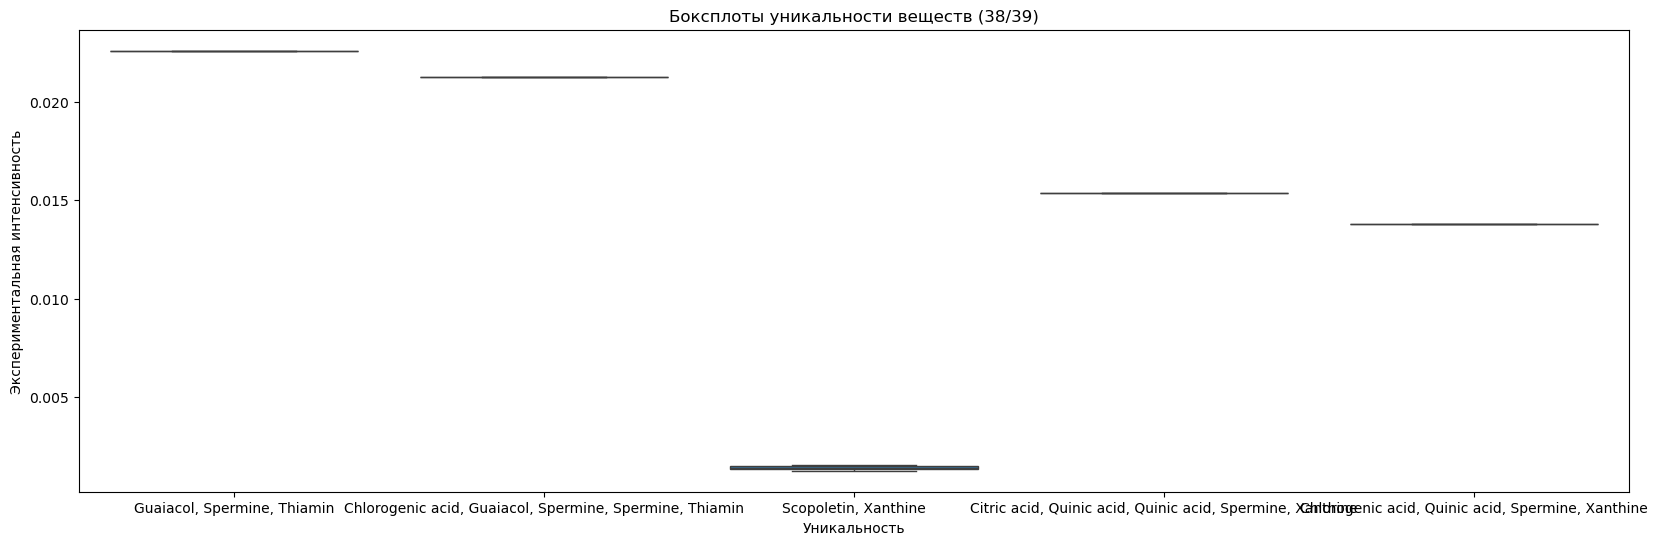

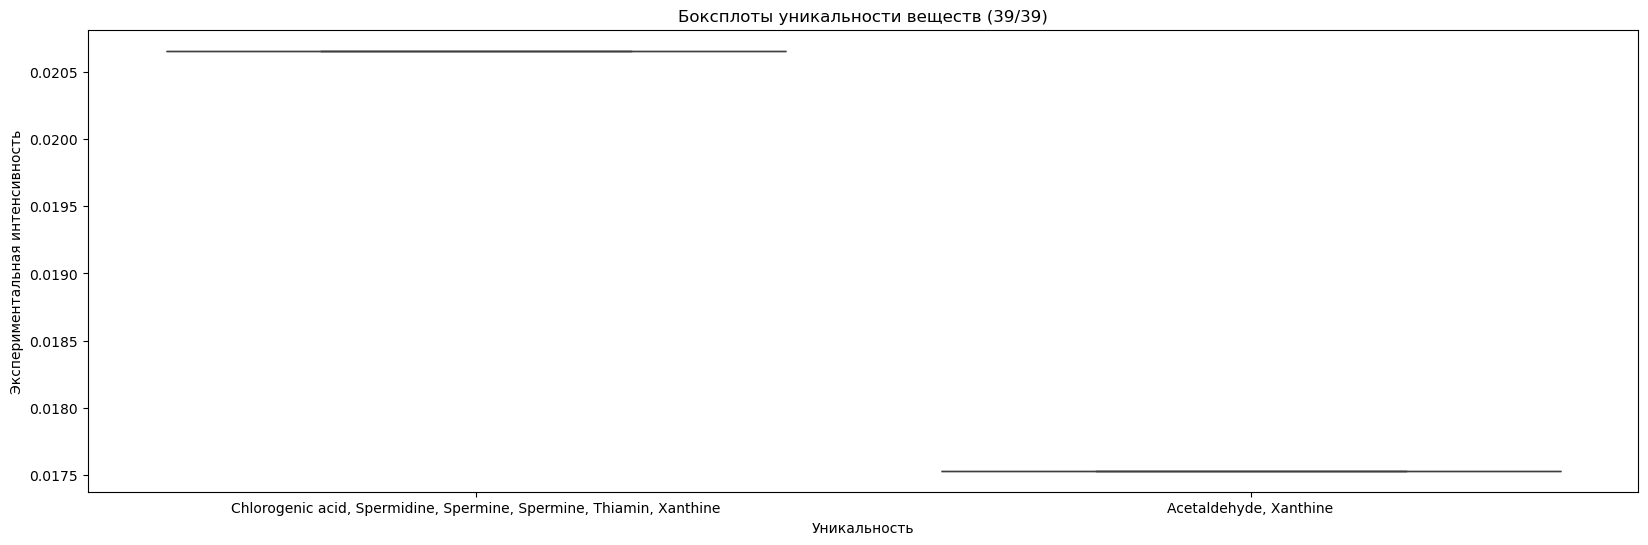

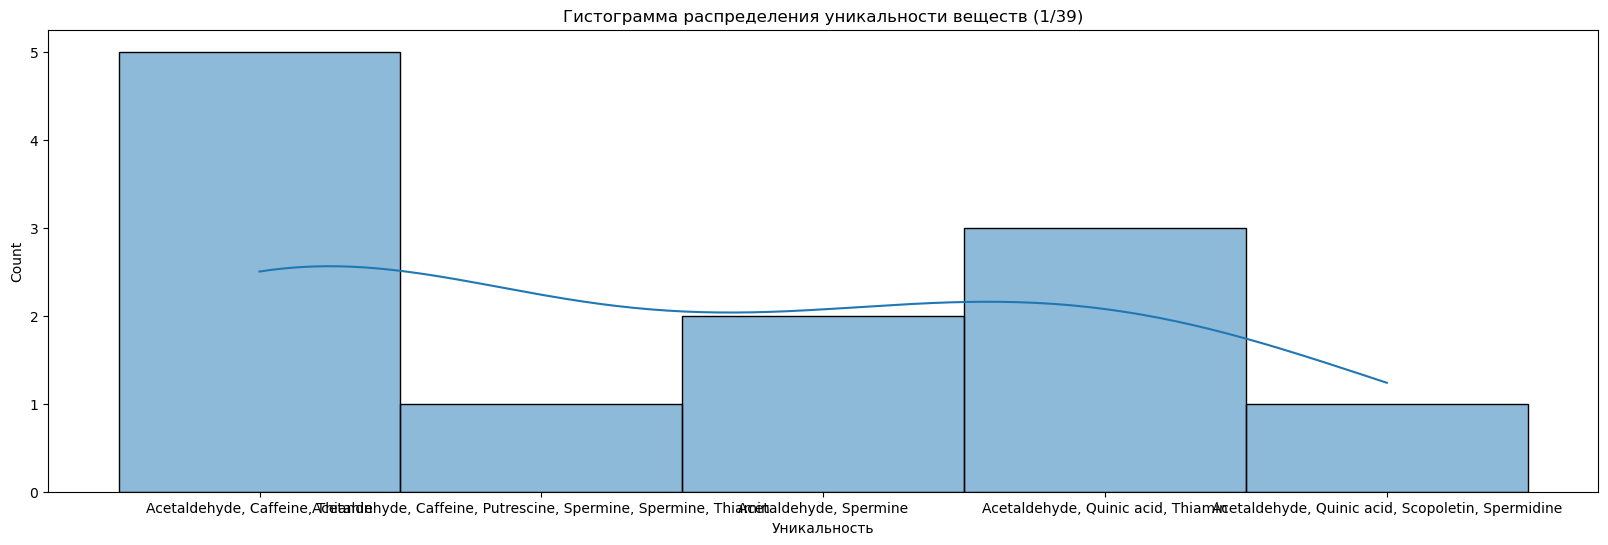

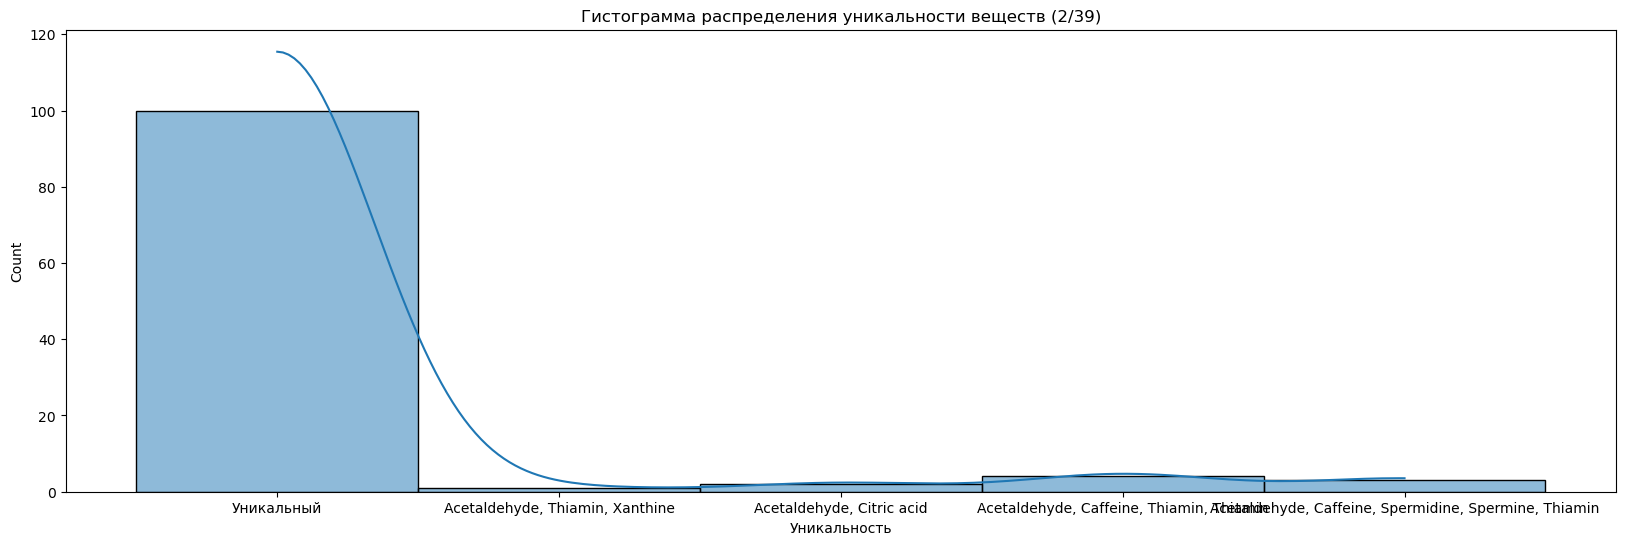

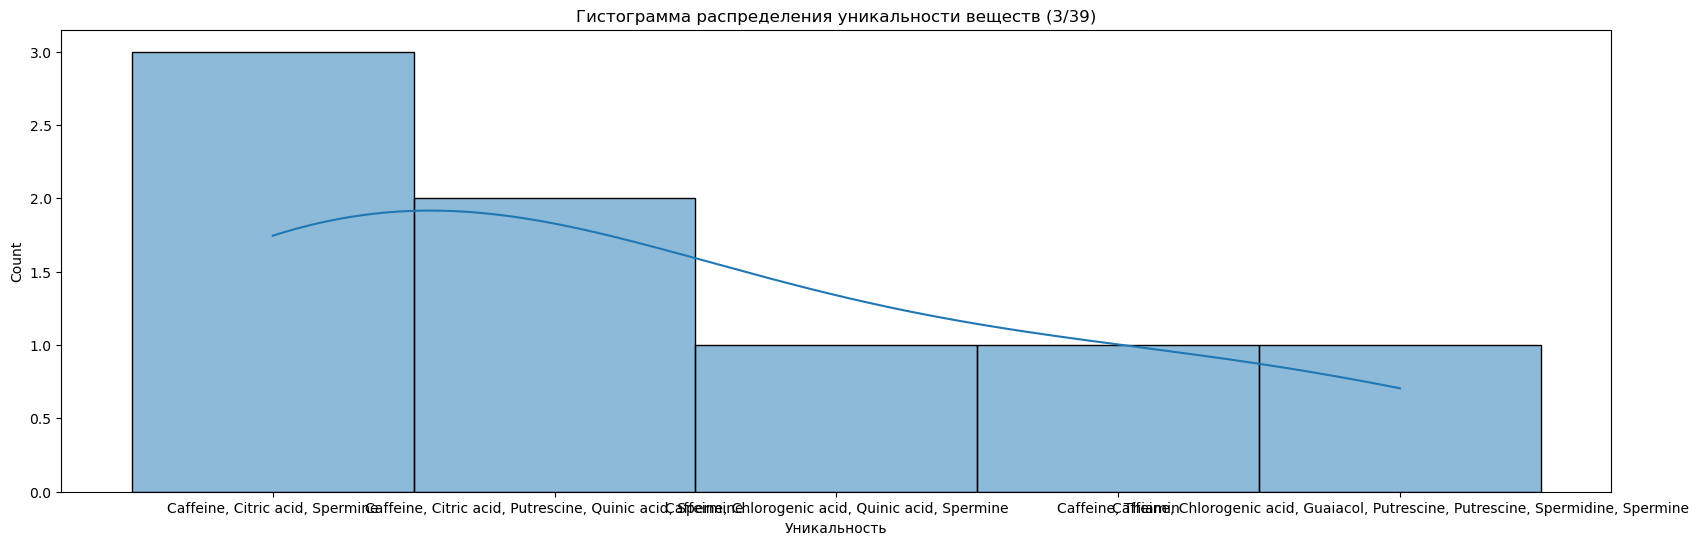

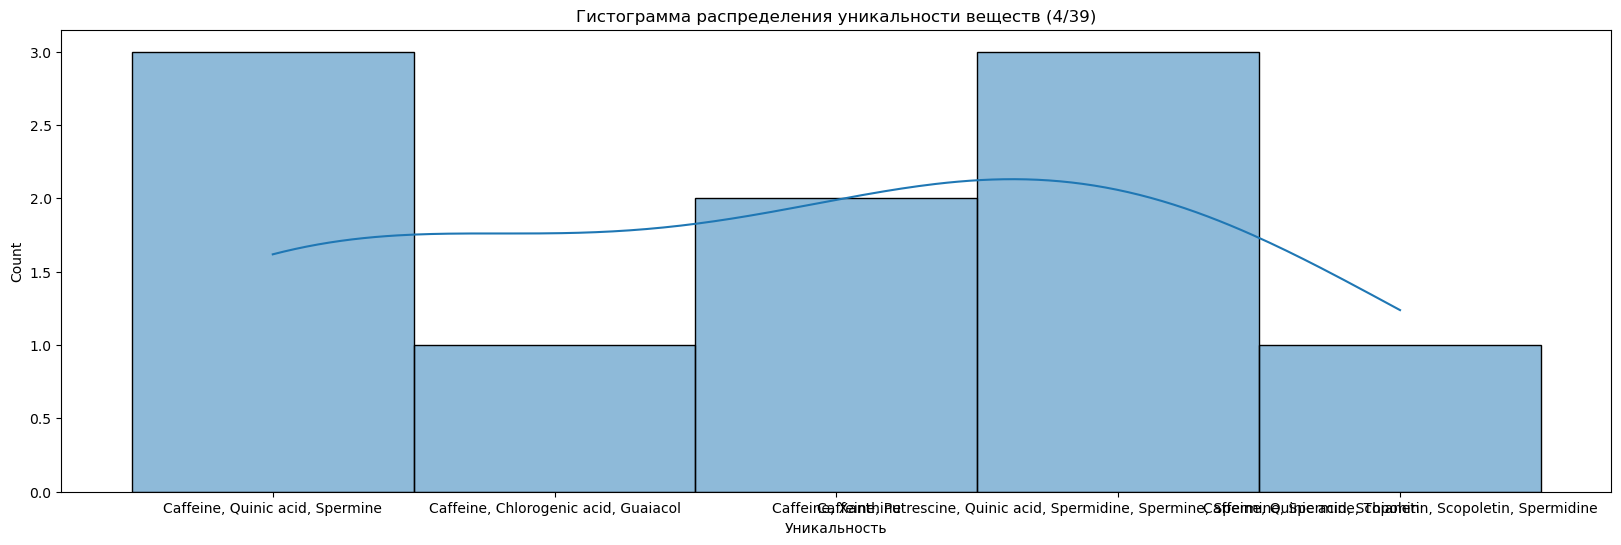

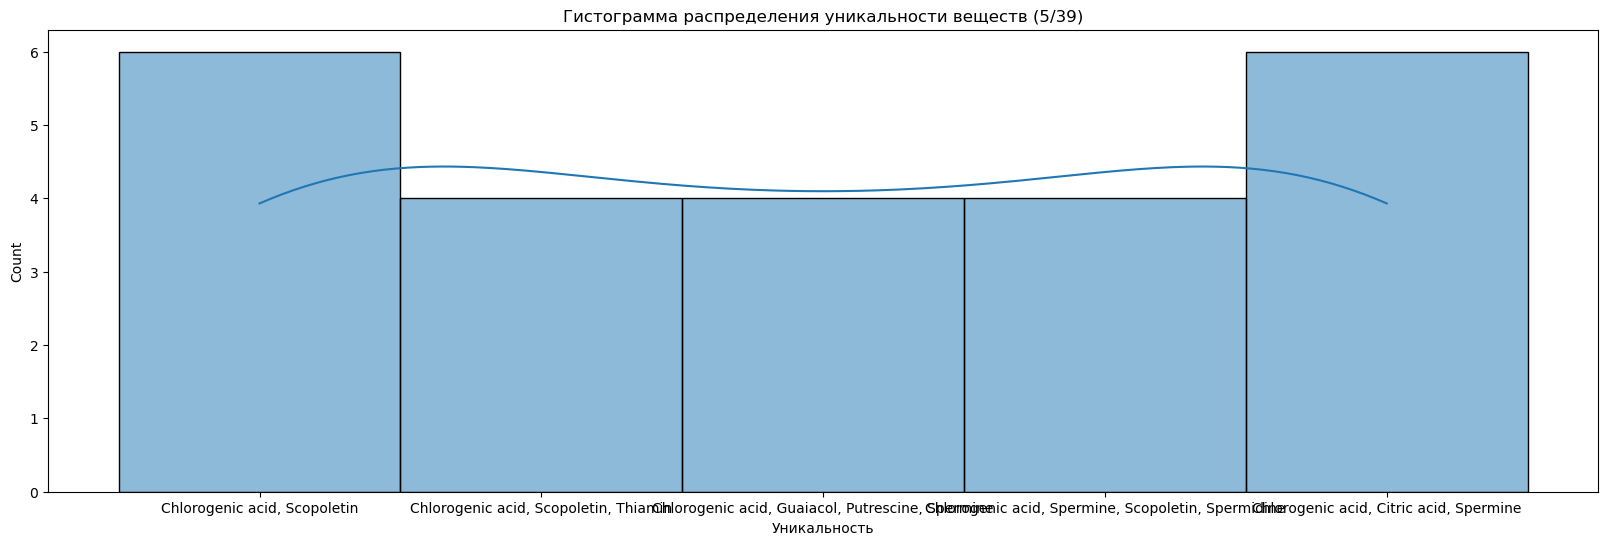

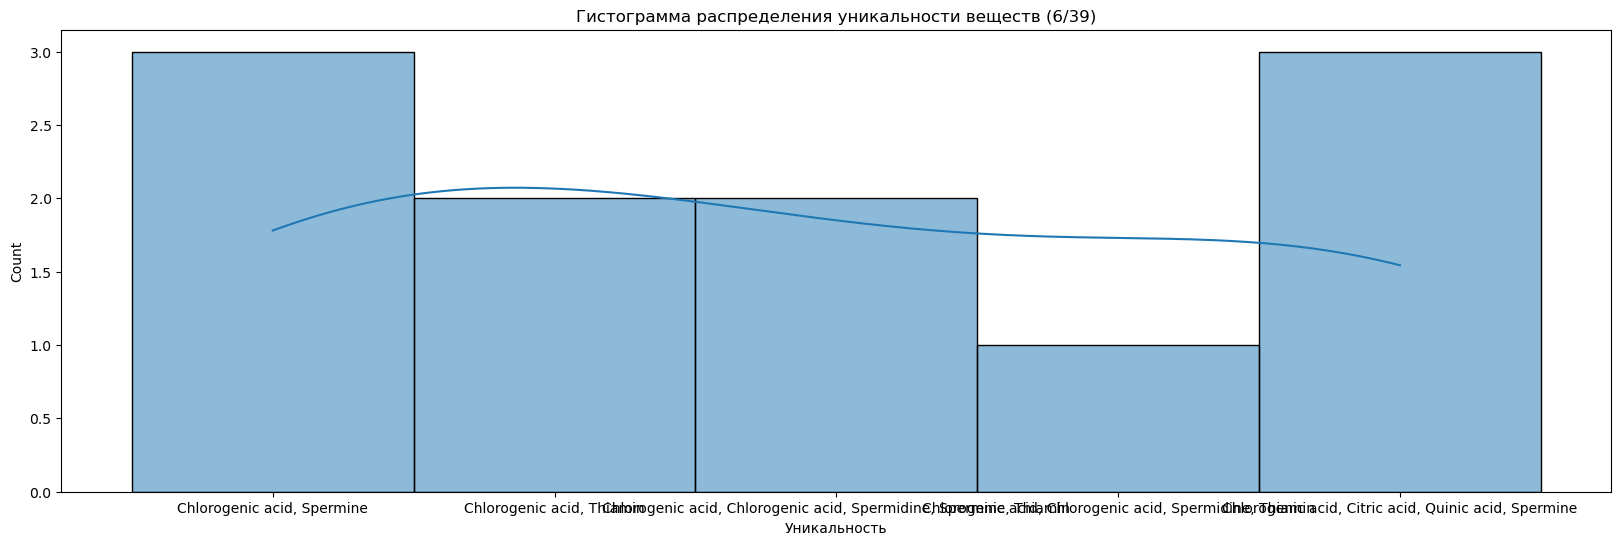

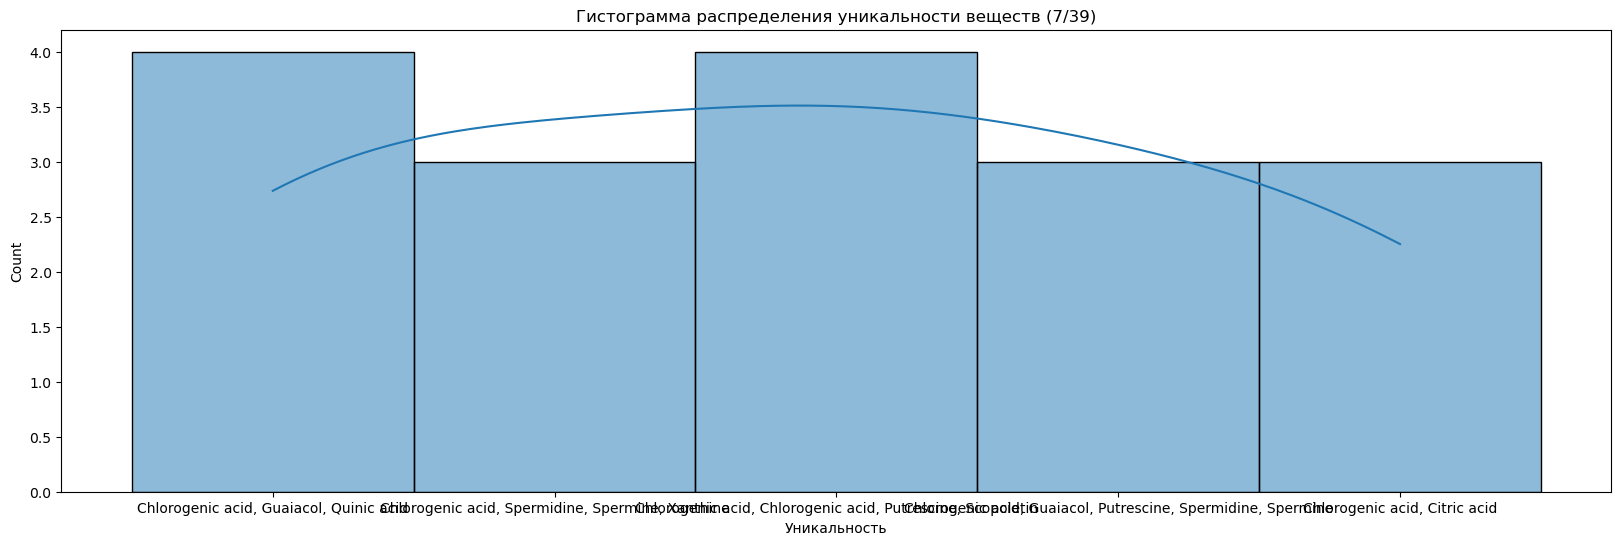

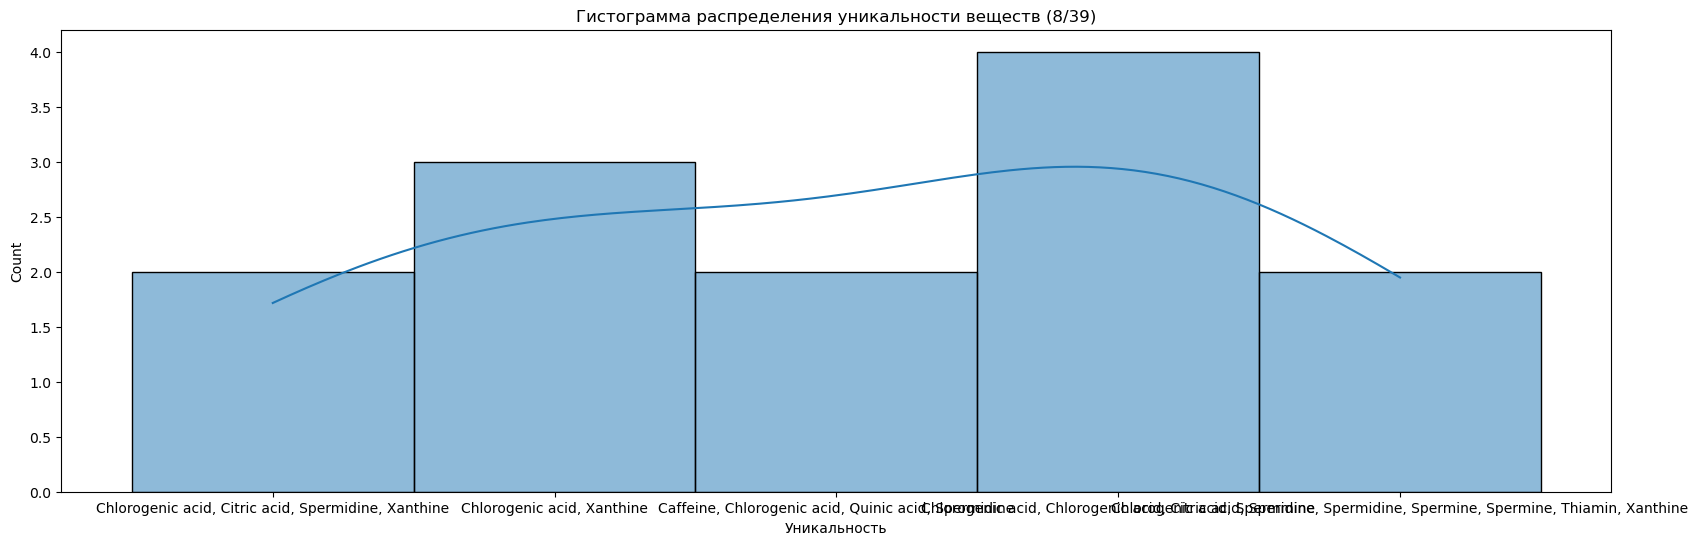

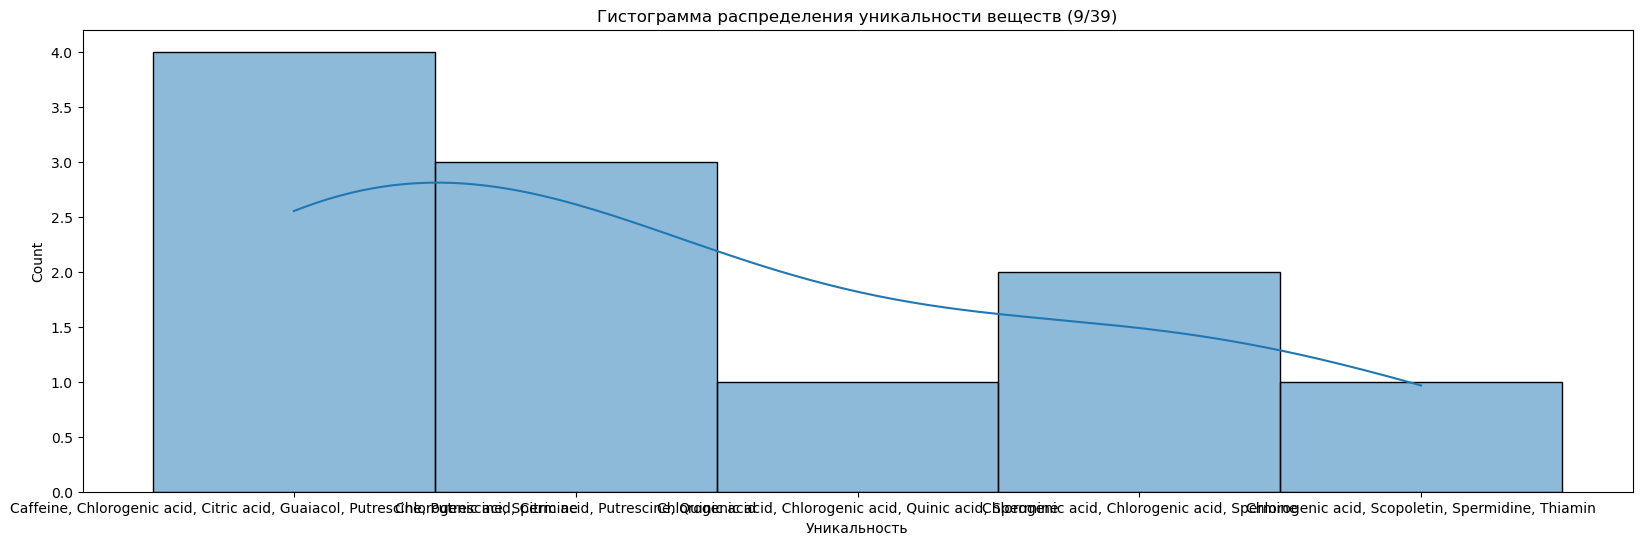

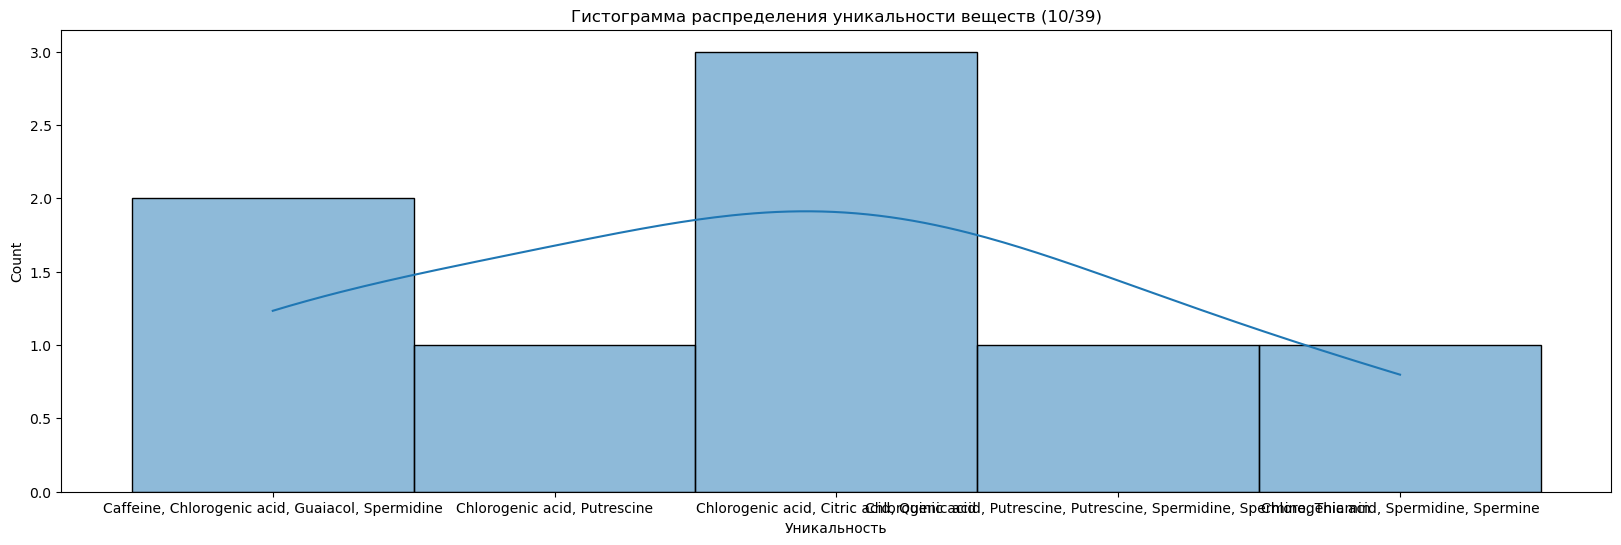

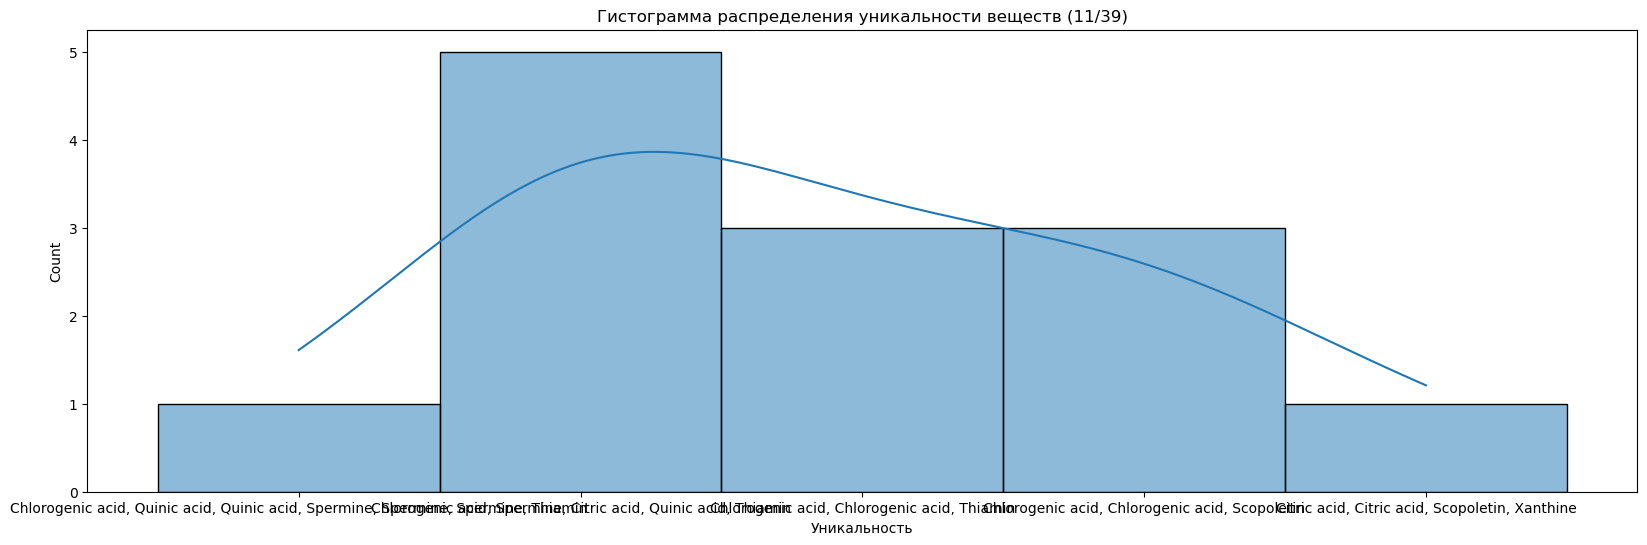

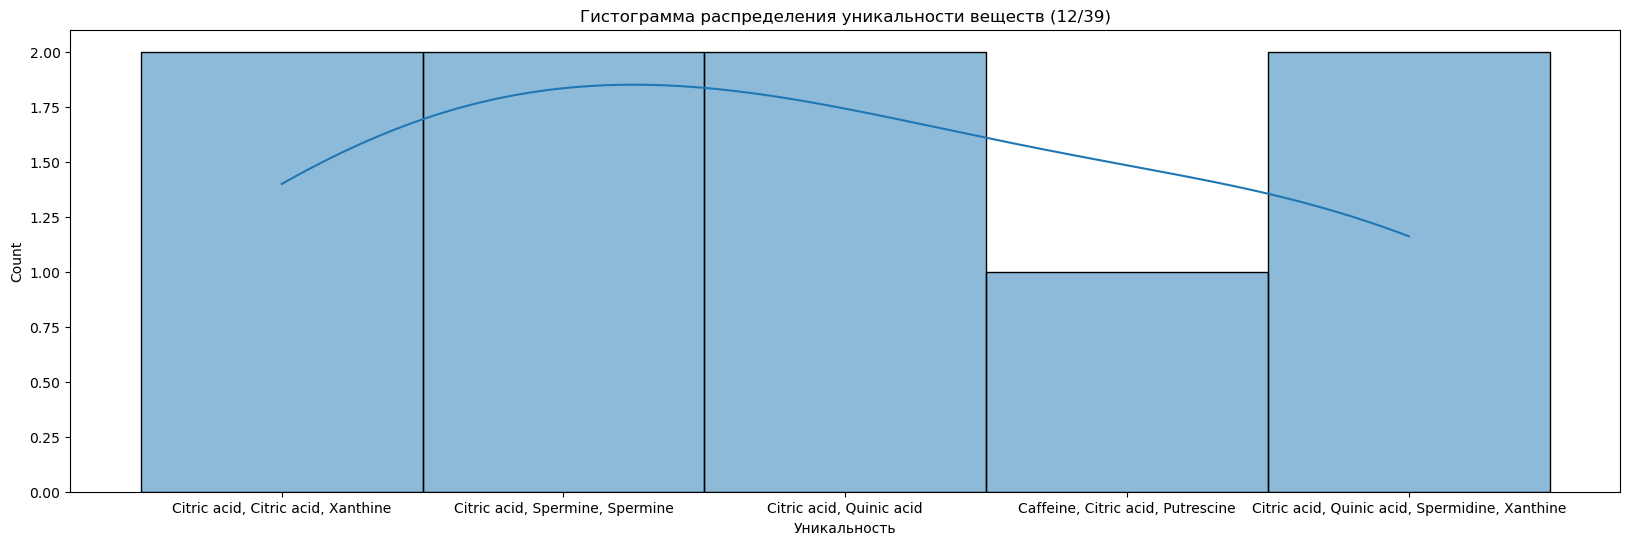

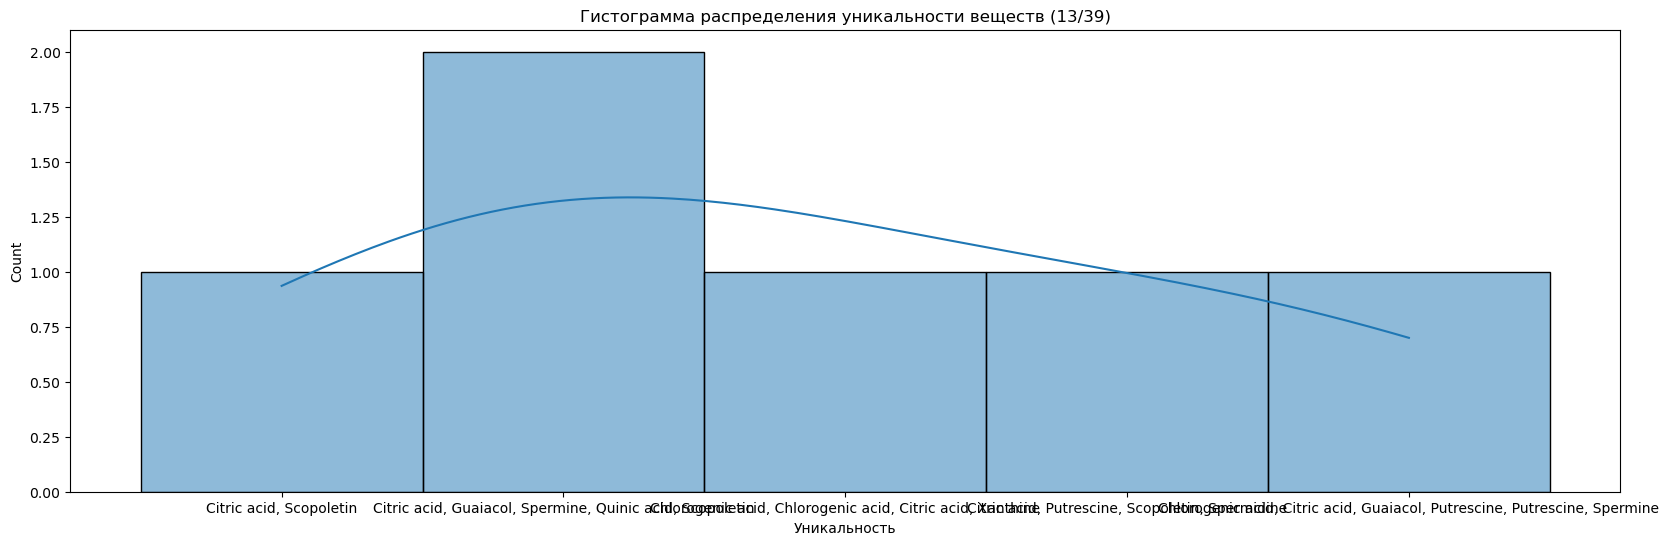

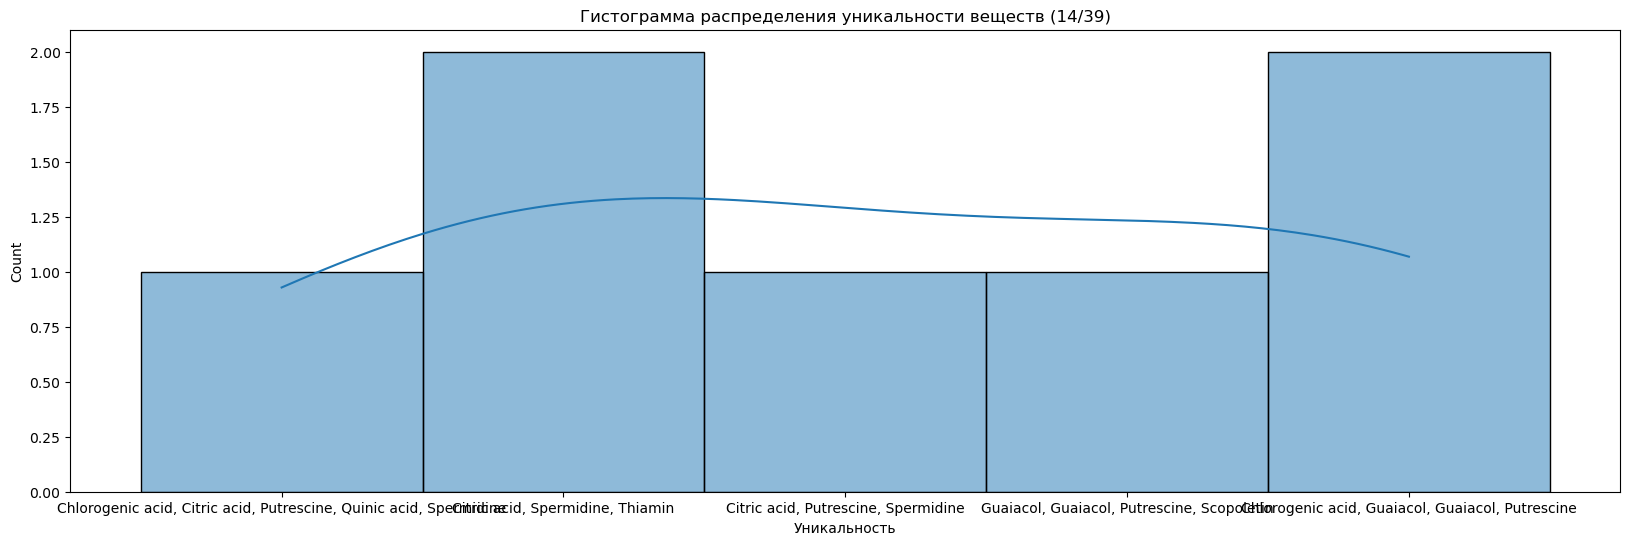

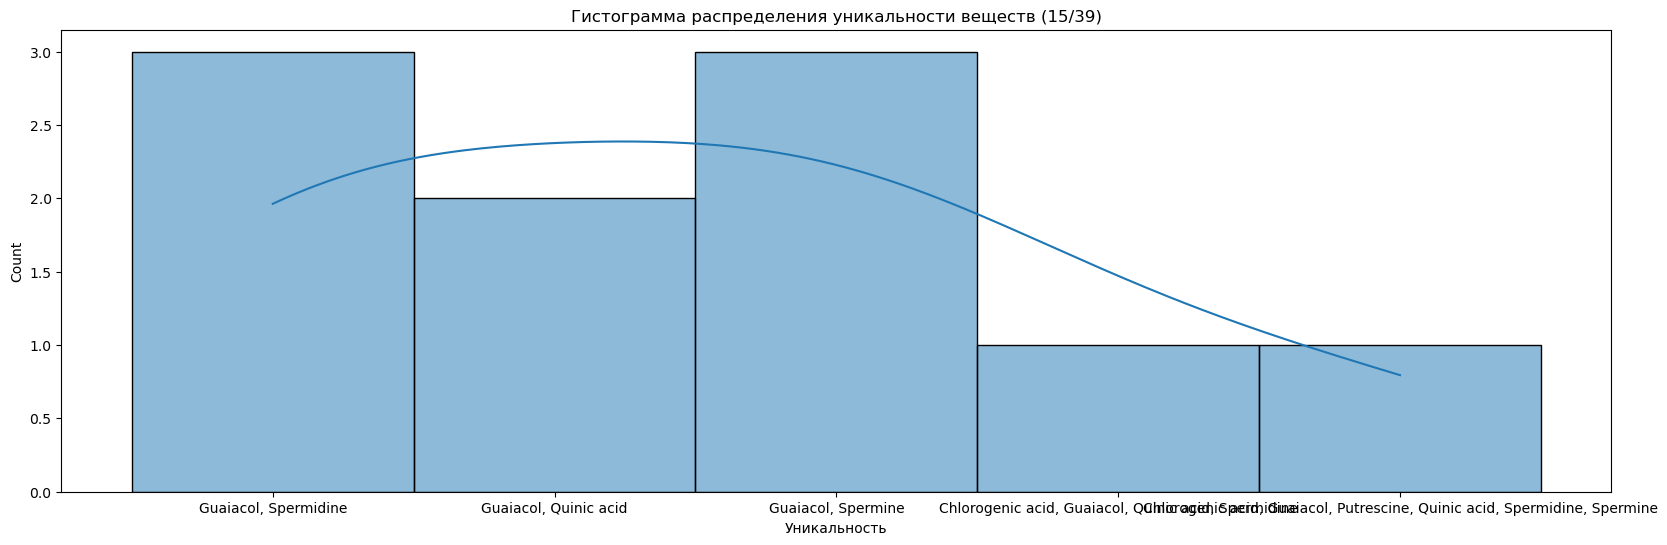

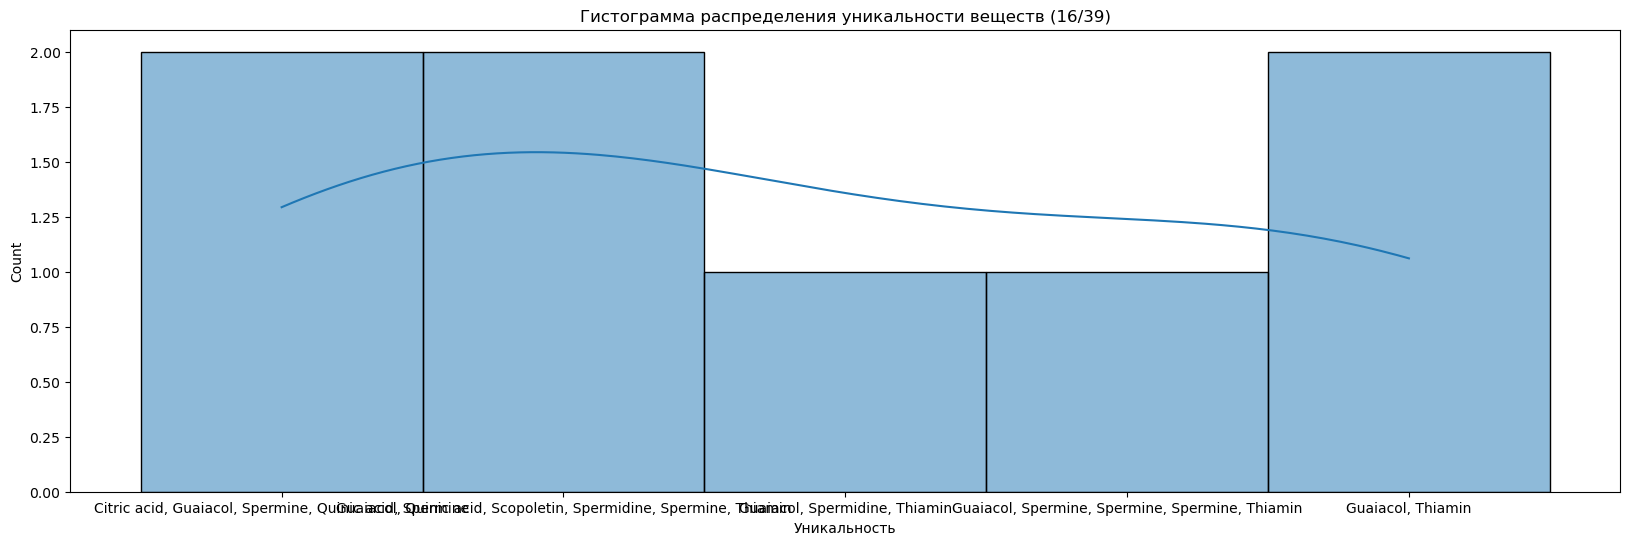

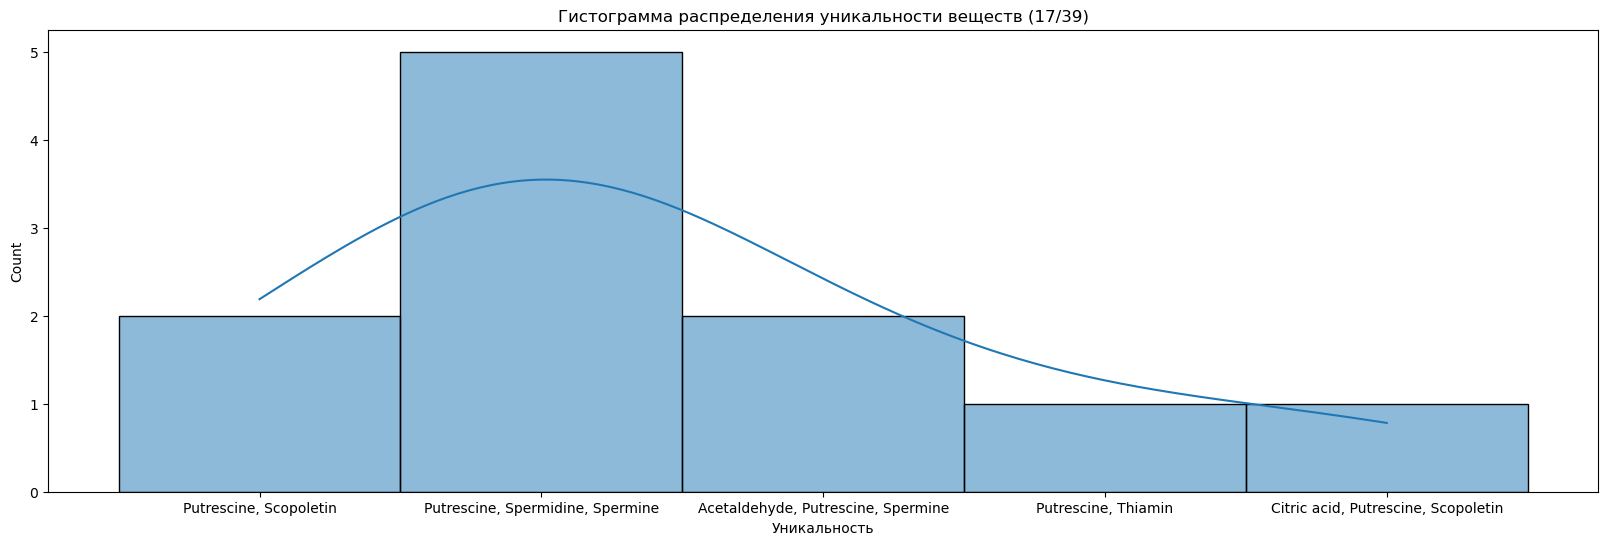

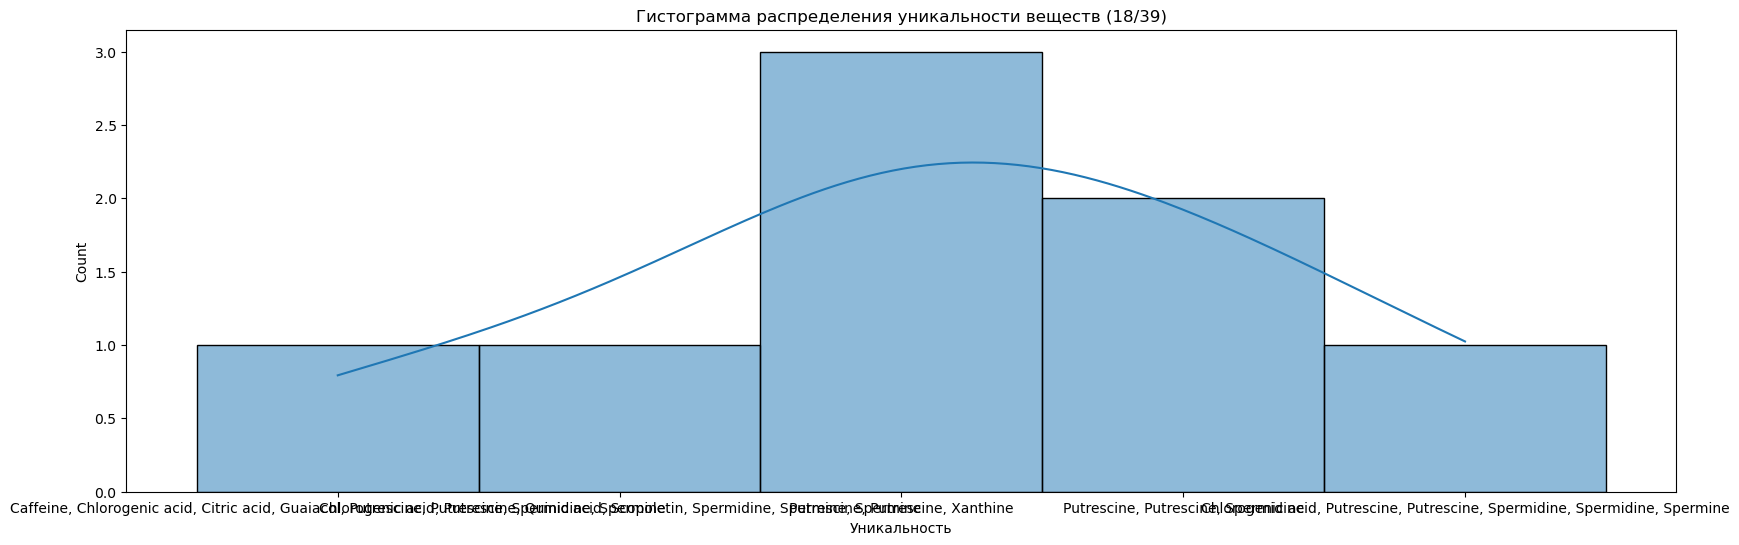

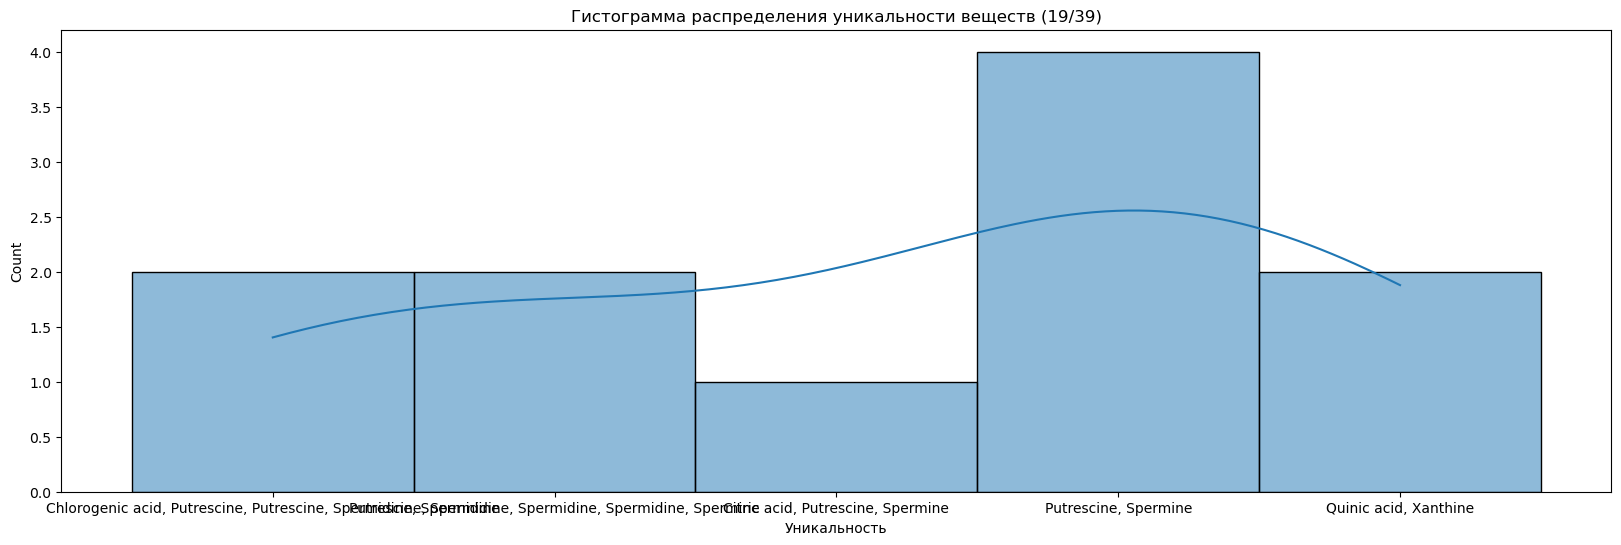

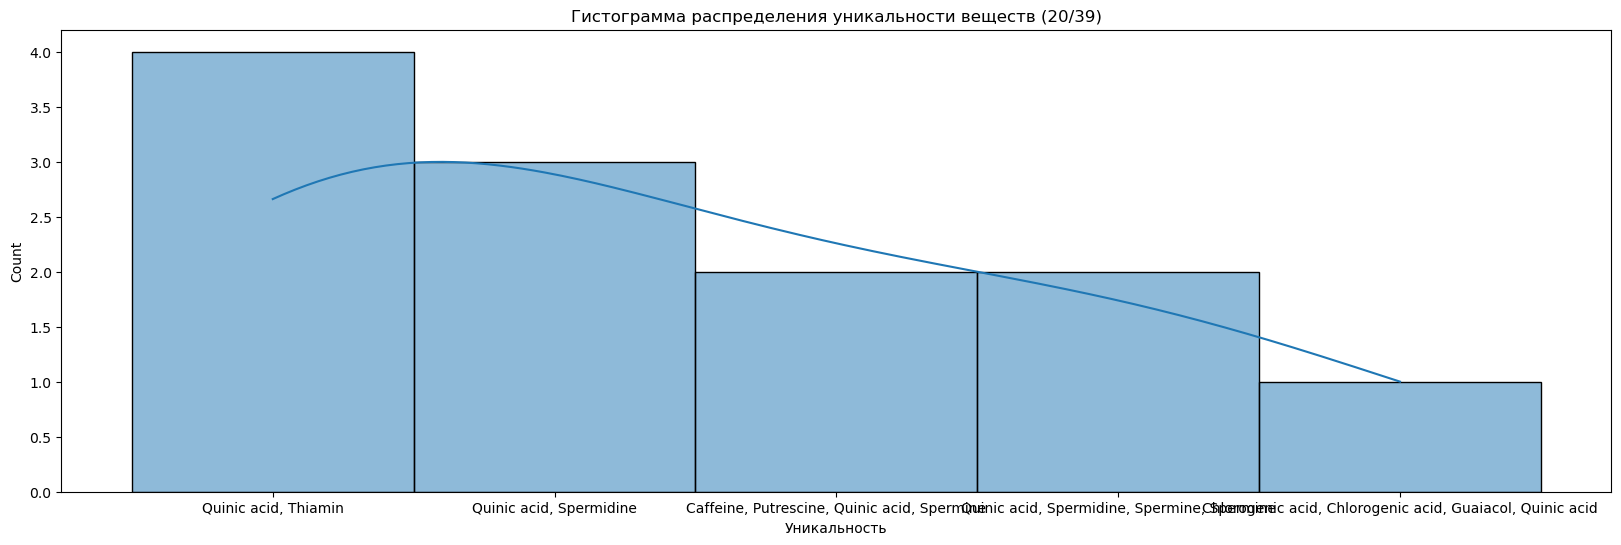

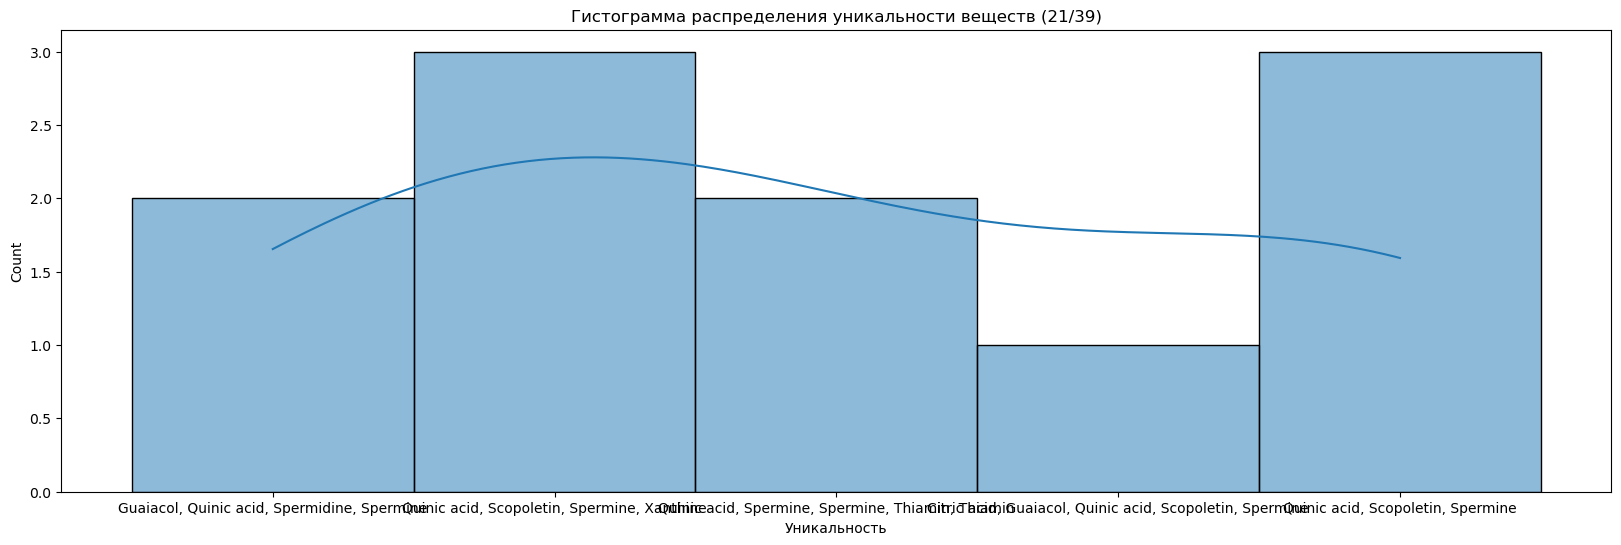

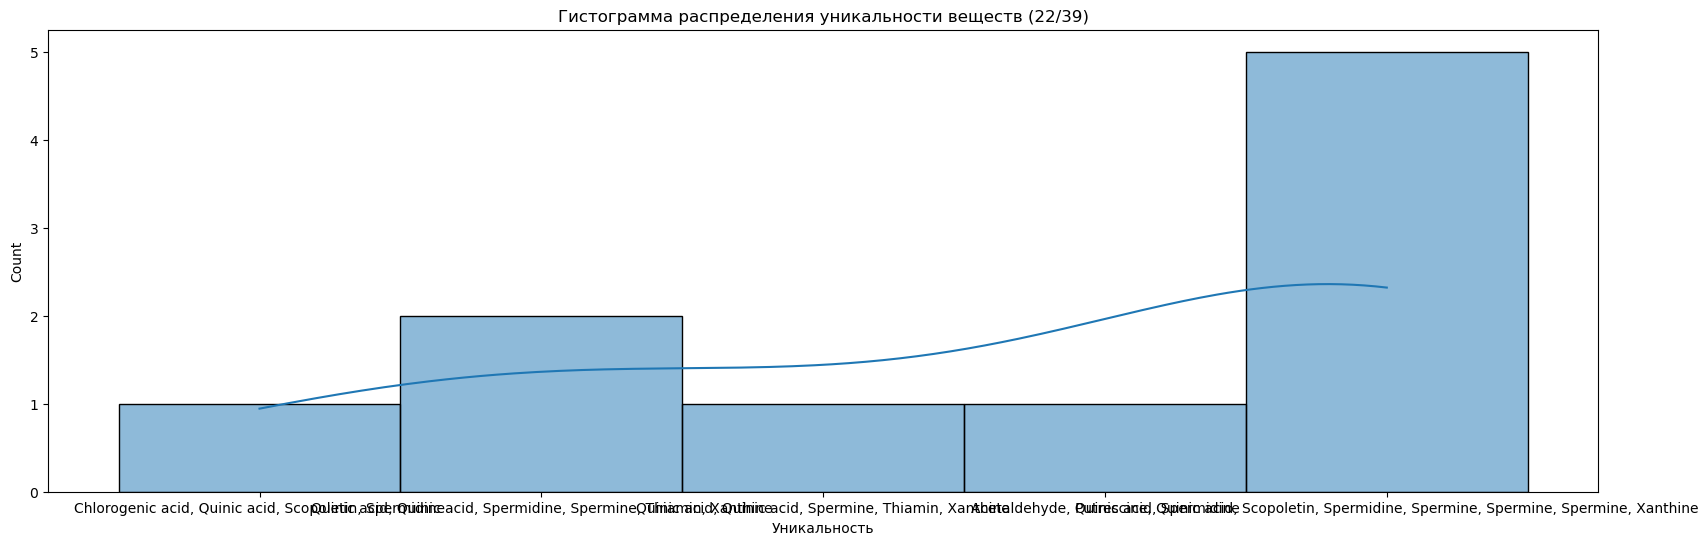

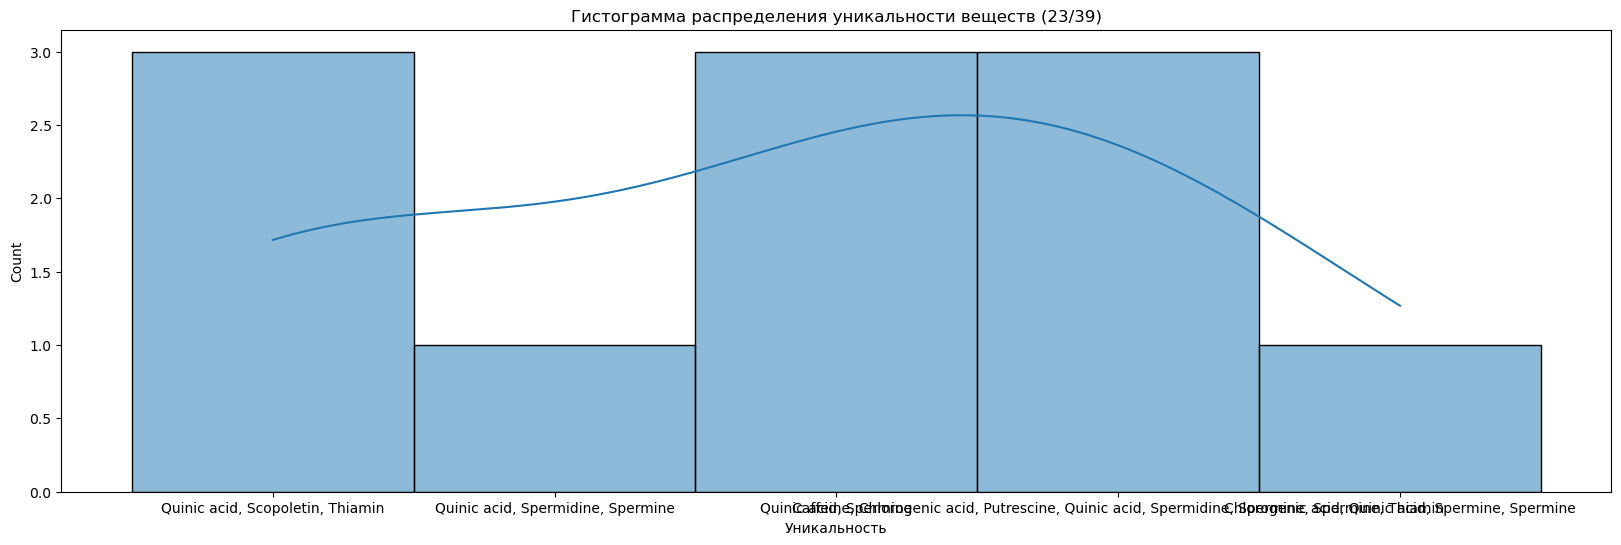

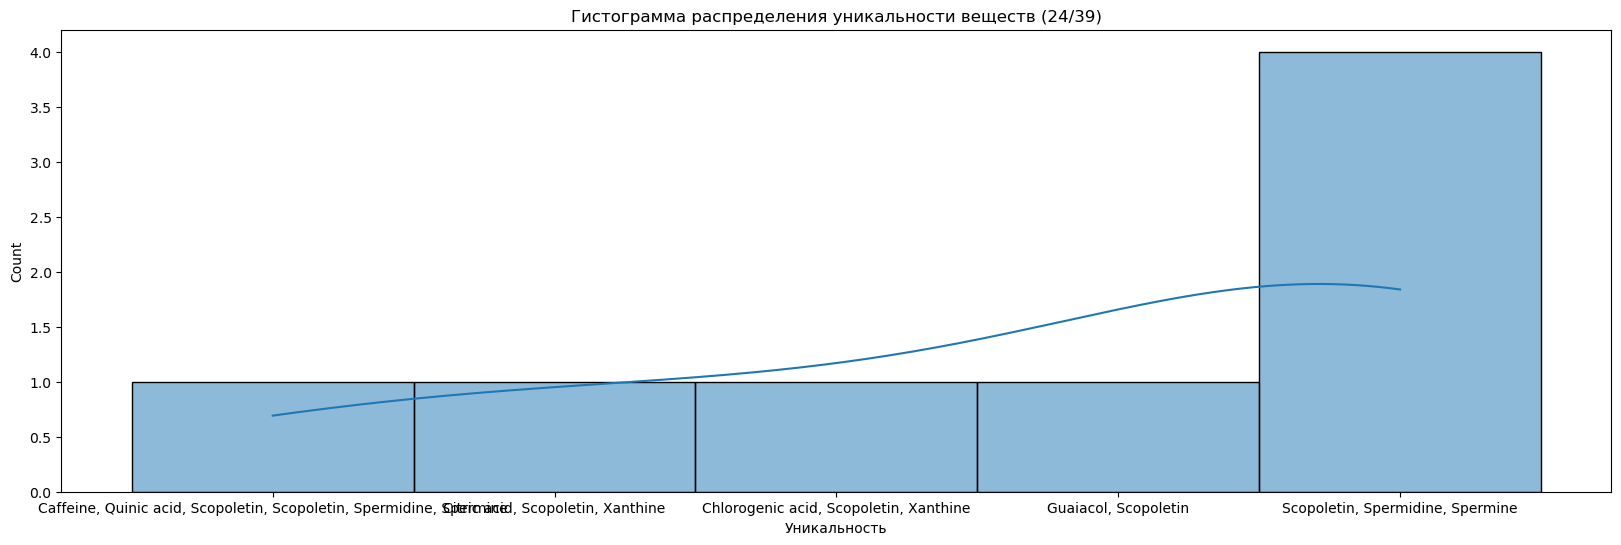

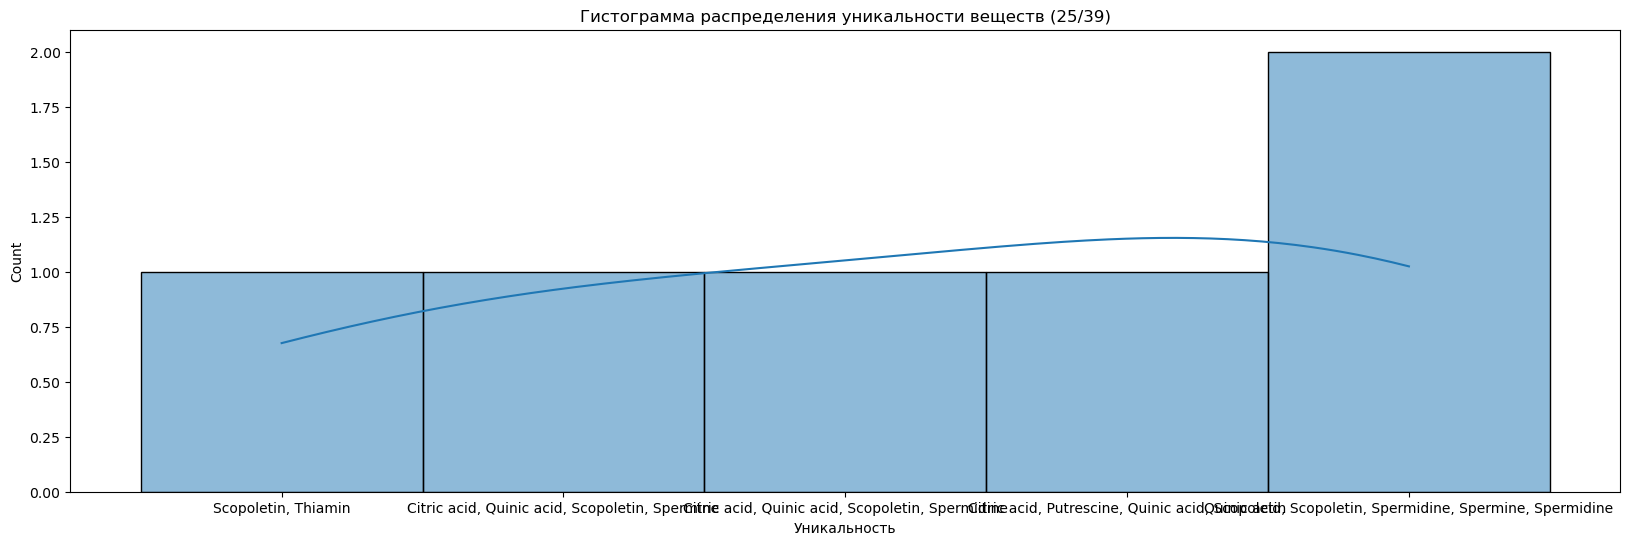

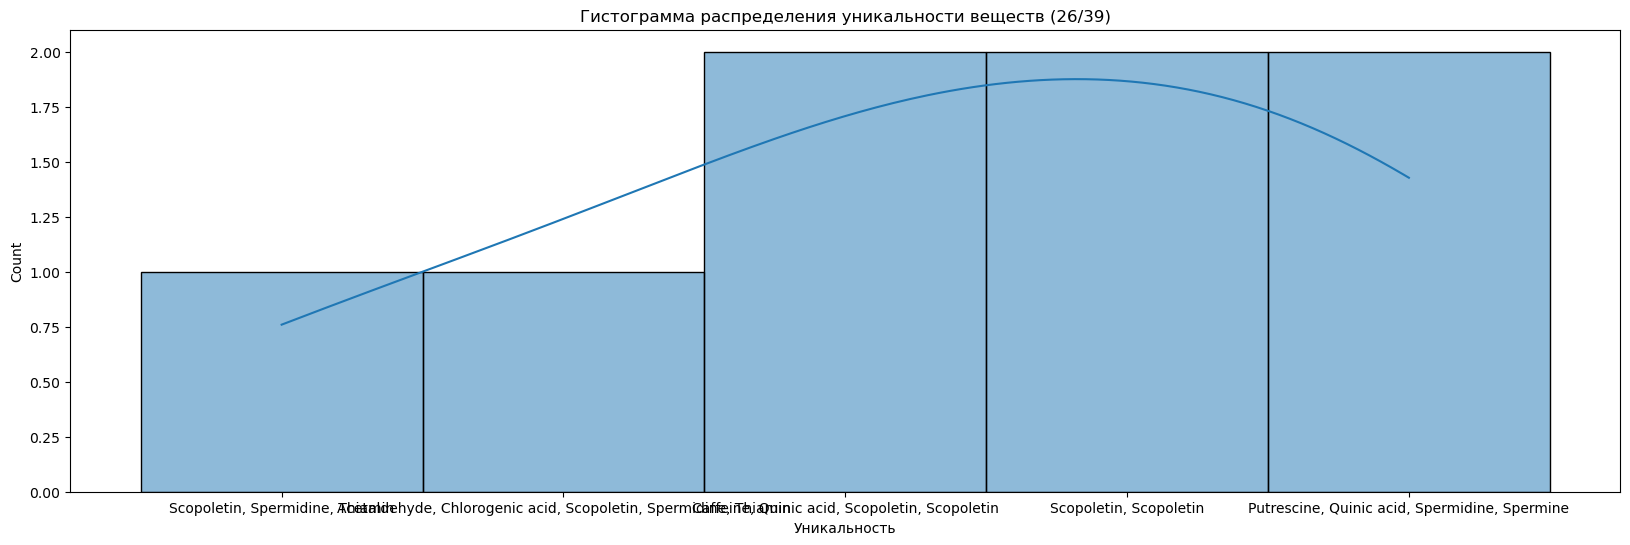

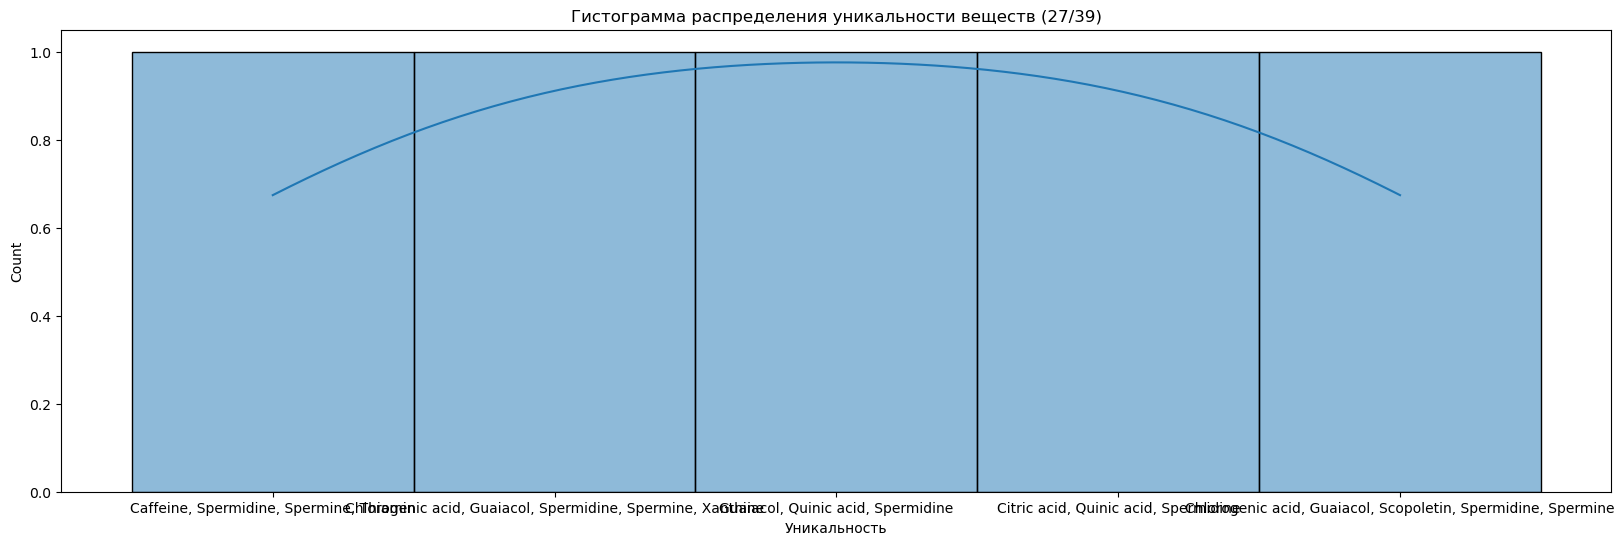

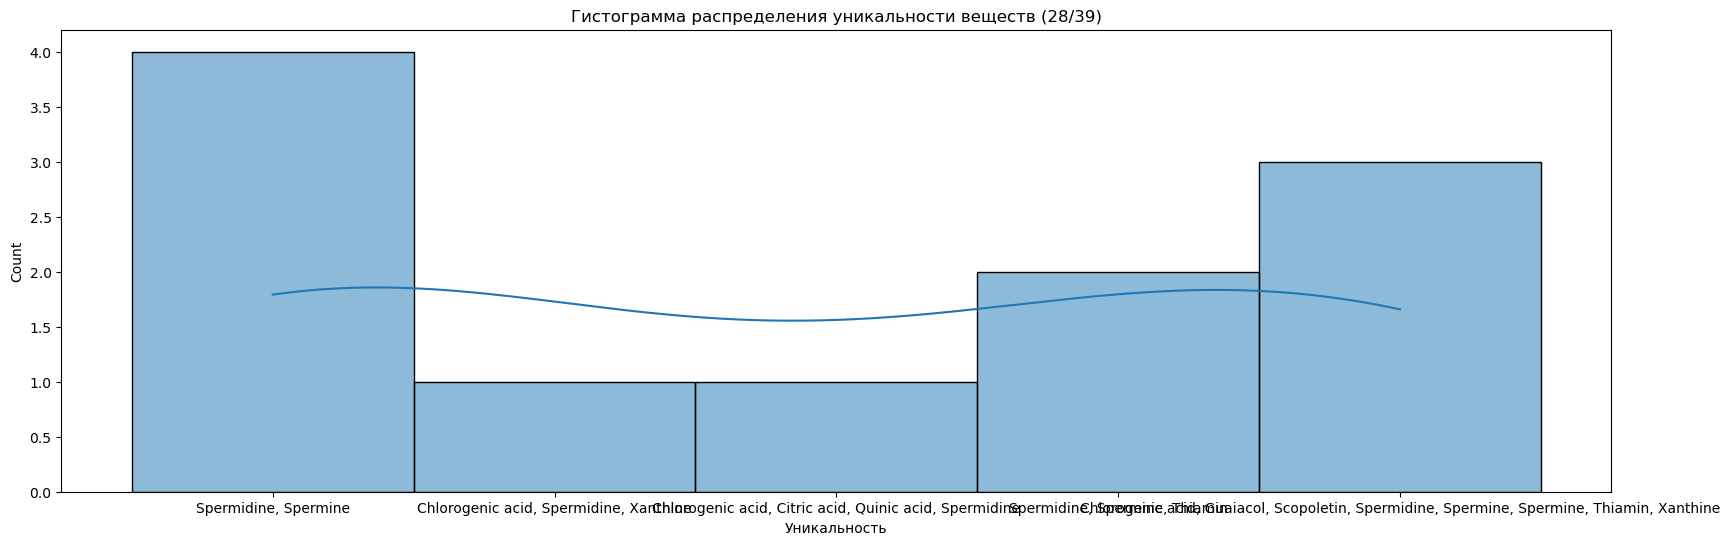

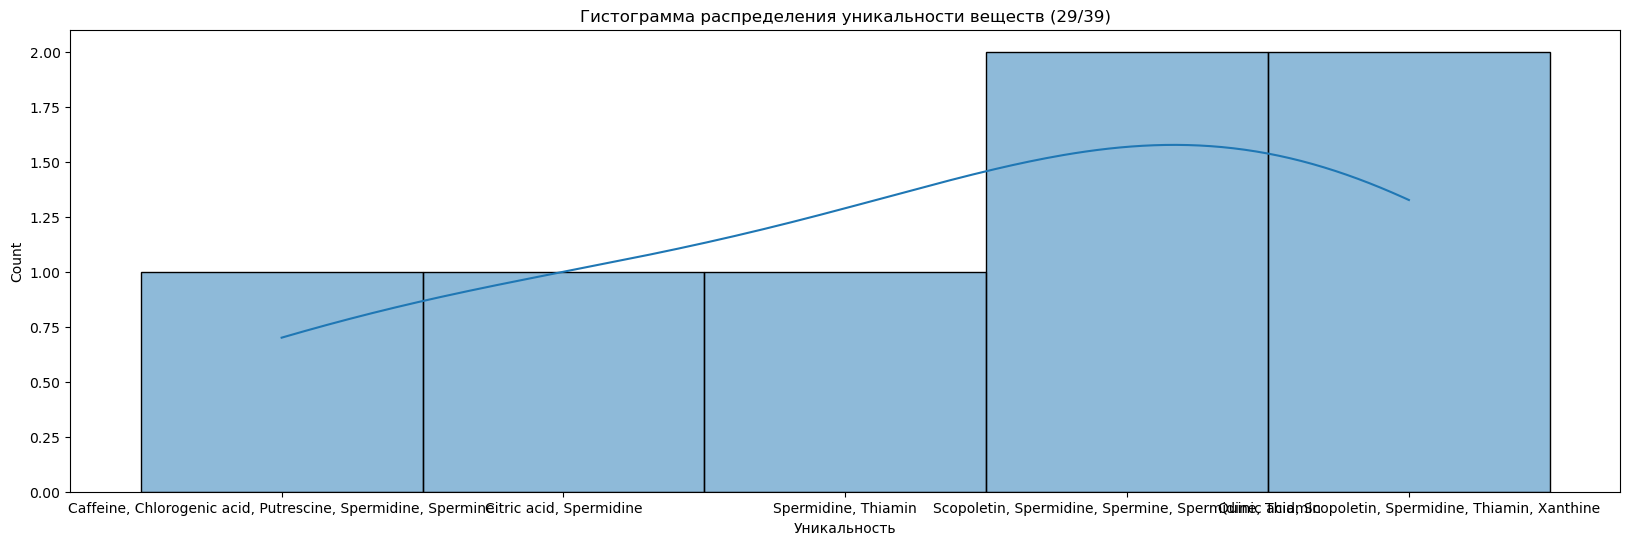

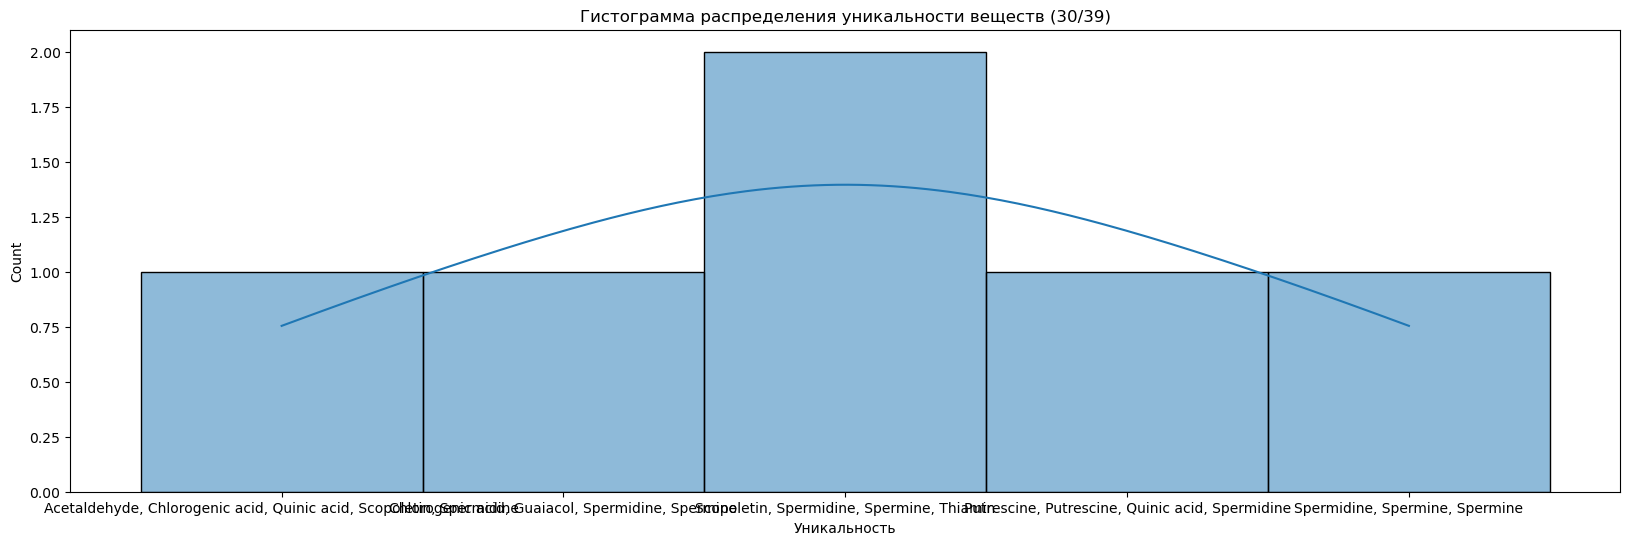

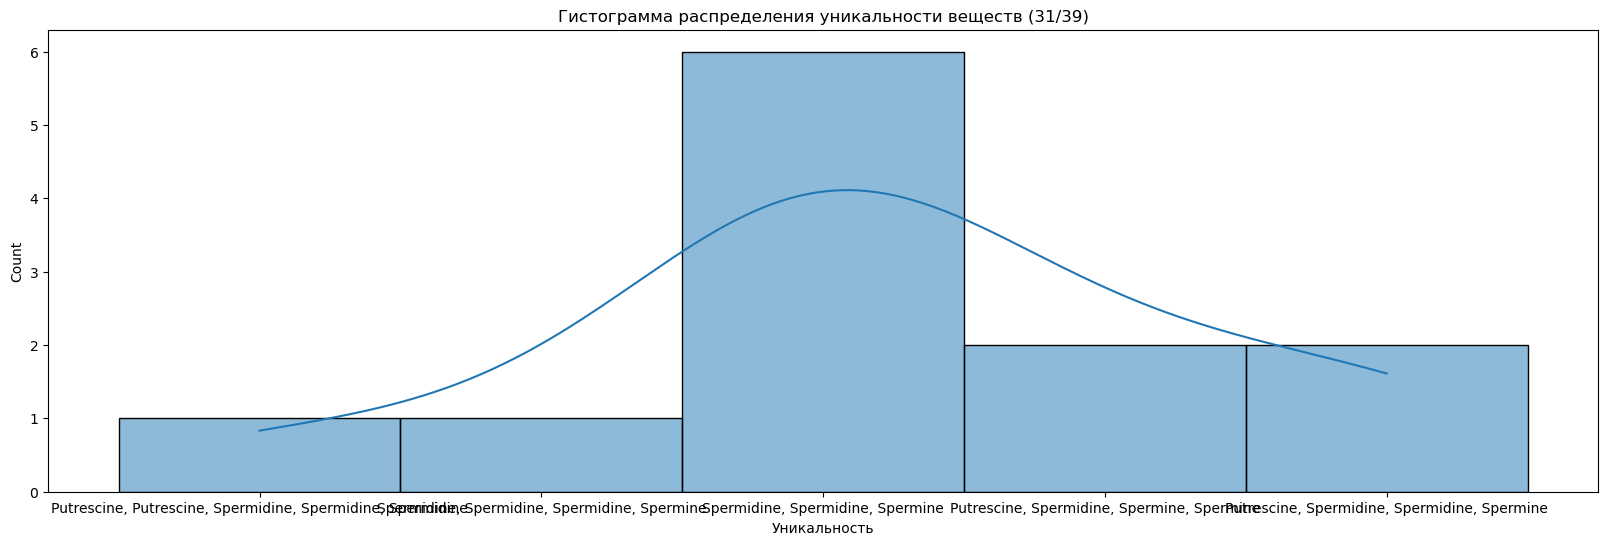

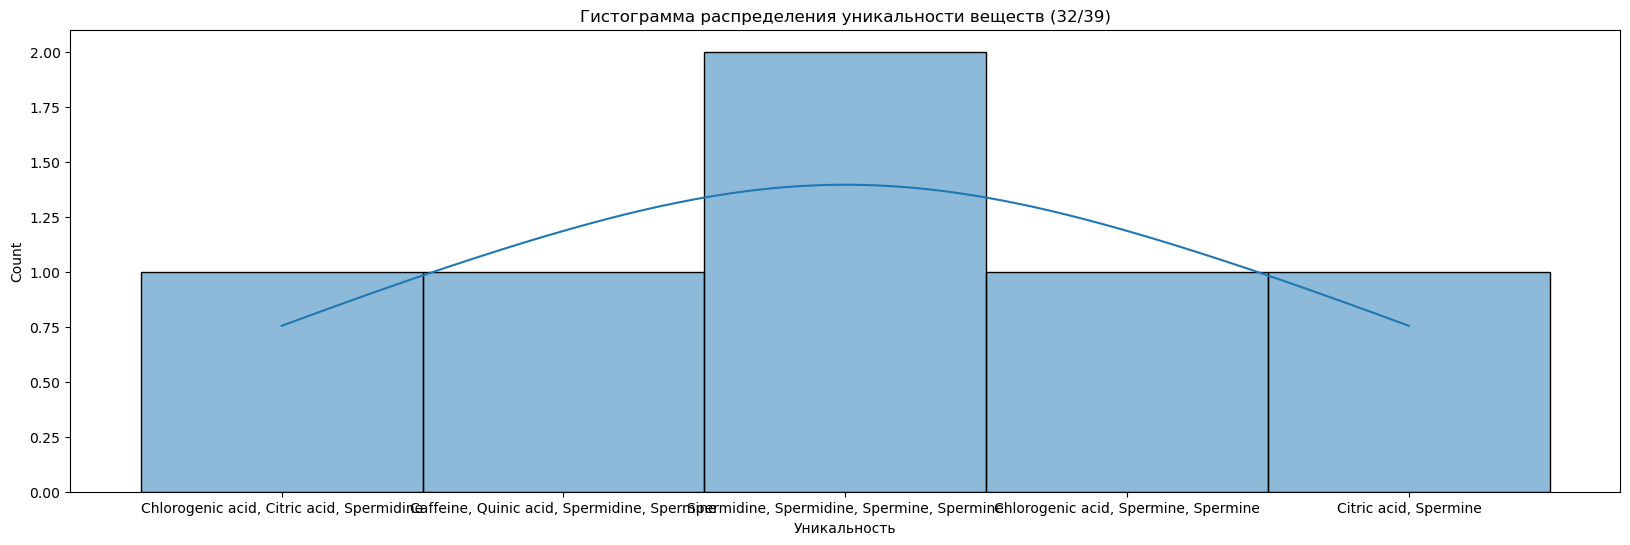

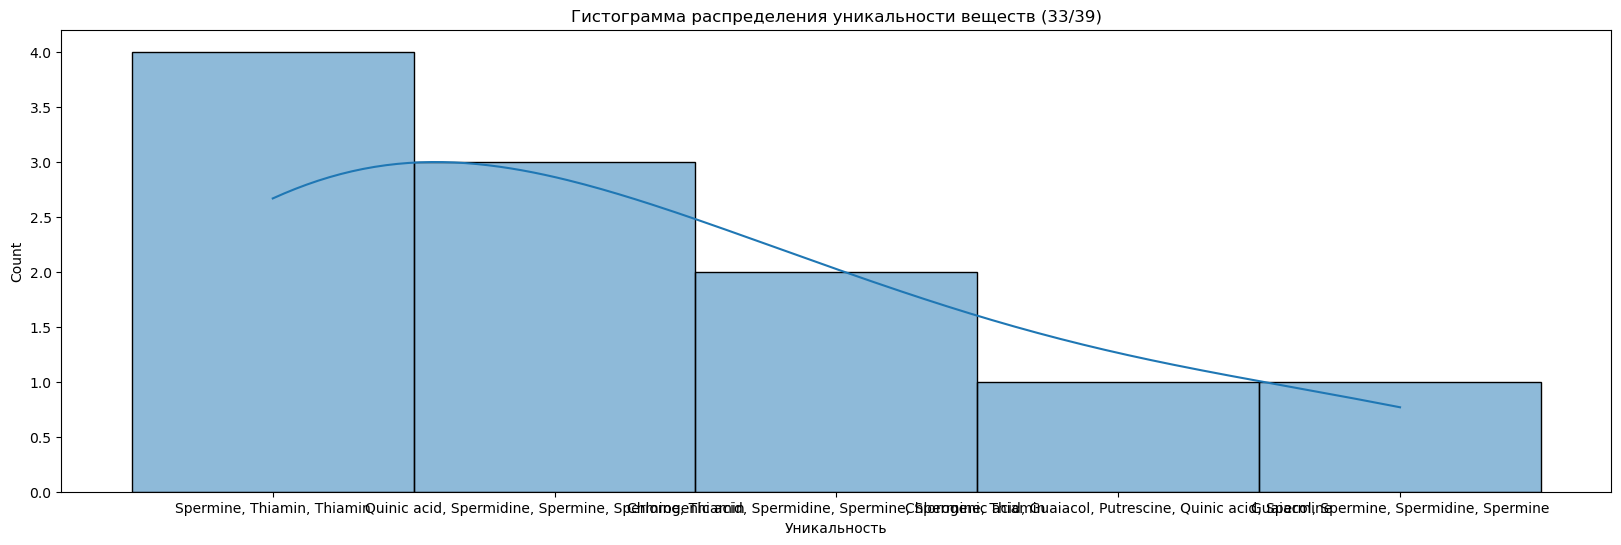

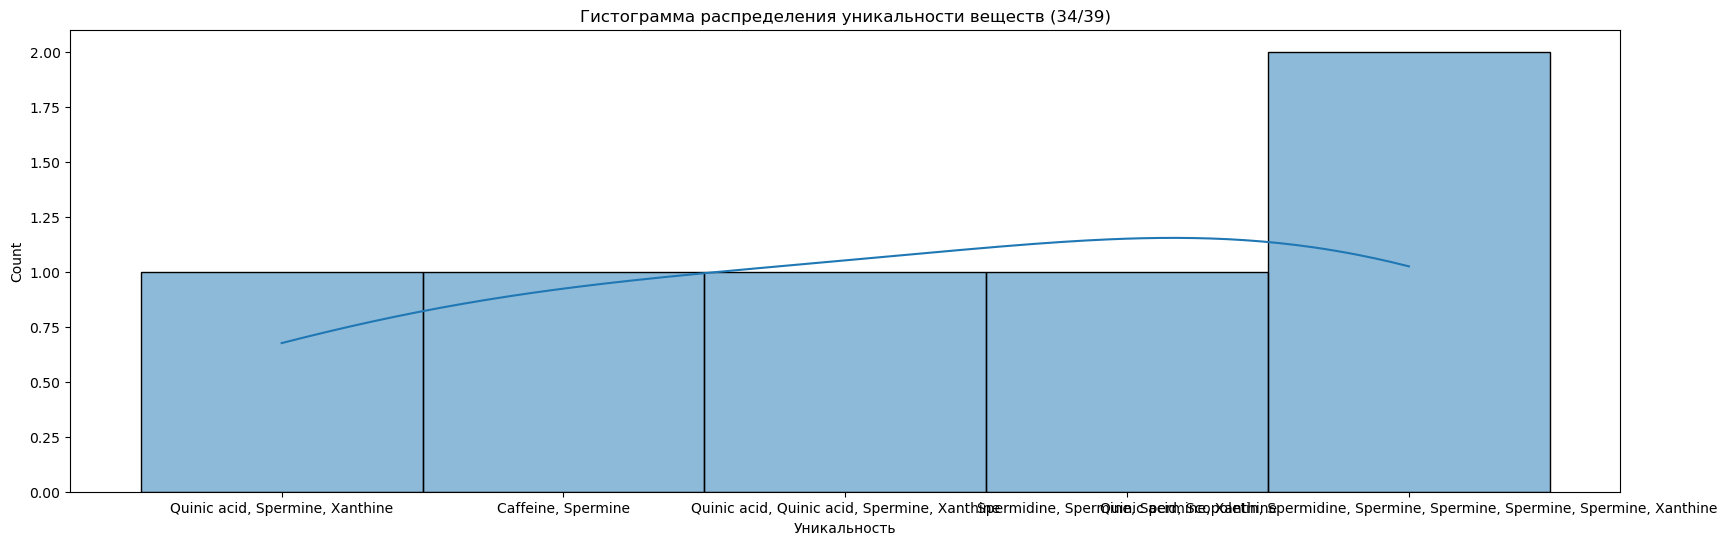

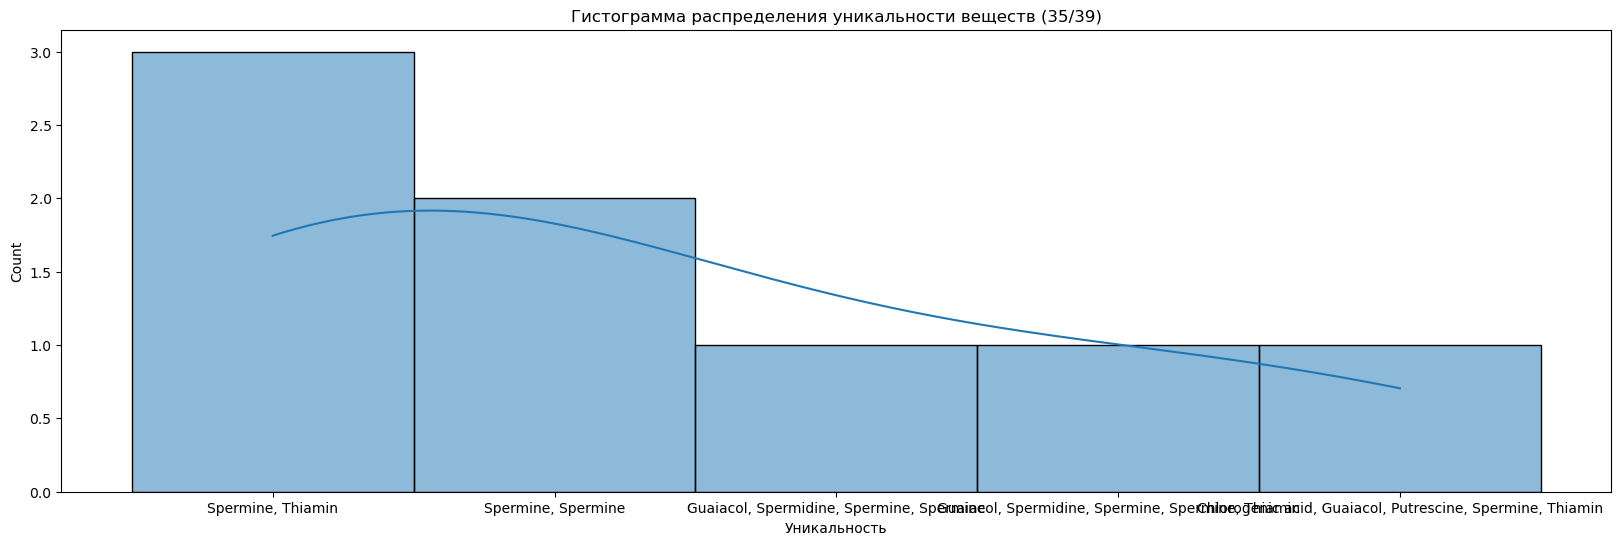

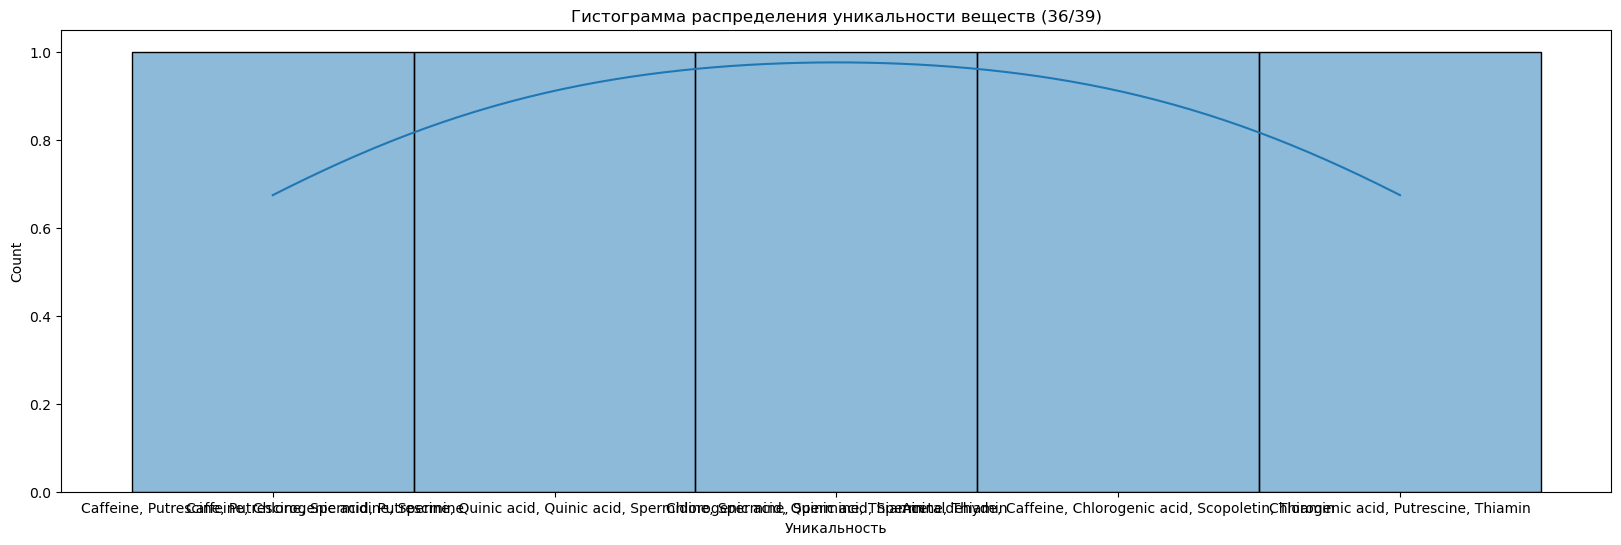

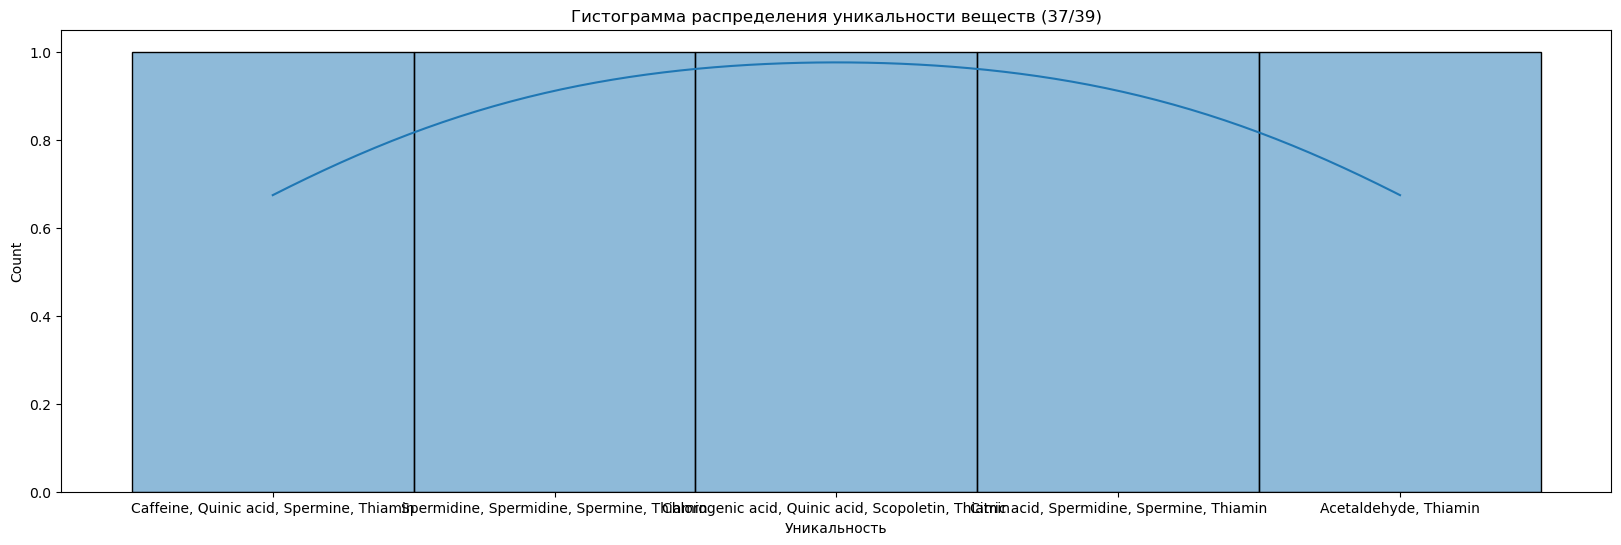

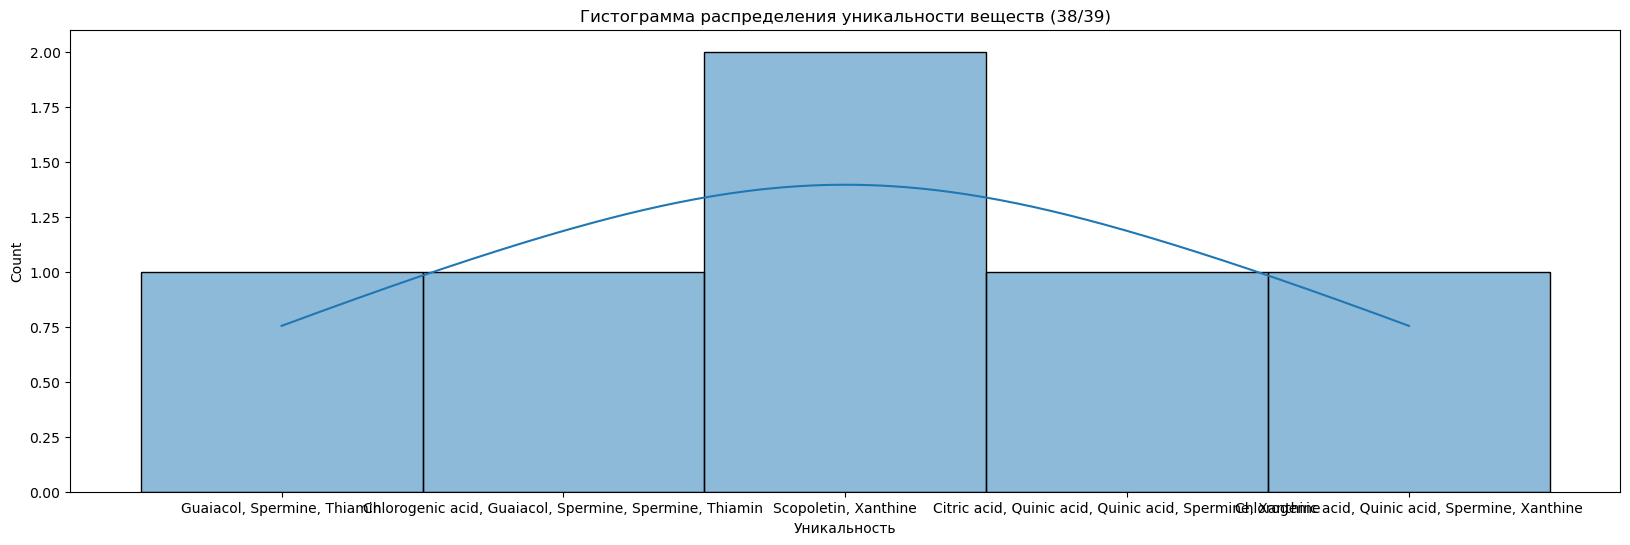

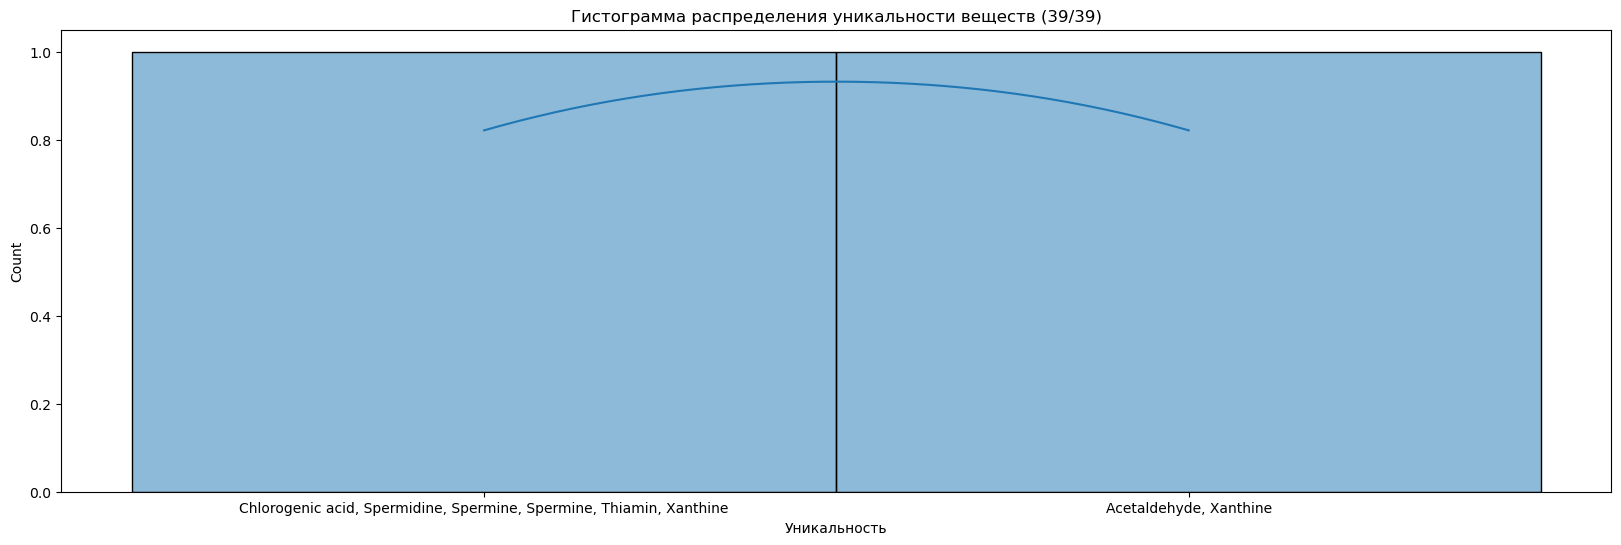

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Боксплоты для сравнения интенсивности веществ
plt.figure(figsize=(20, 6))
sns.boxplot(x='Название вещества', y='Экспериментальная интенсивность', data=results)
plt.title('Боксплоты интенсивности веществ')
plt.show()

# Гистограмма распределения интенсивности веществ
plt.figure(figsize=(20, 6))
sns.histplot(results['Экспериментальная интенсивность'], bins=50, kde=True)
plt.title('Гистограмма распределения интенсивности веществ')
plt.show()

# Диаграмма рассеяния частоты и интенсивности веществ
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Частота', y='Экспериментальная интенсивность', hue='Название вещества', data=results)
plt.title('Диаграмма рассеяния частоты и интенсивности веществ')
plt.show()

# Получаем уникальные значения уникальности веществ
unique_uniqueness = results['Уникальность'].unique()

# Разбиваем данные на несколько графиков
n_plots = len(unique_uniqueness) // 5 + 1
for i in range(n_plots):
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(x='Уникальность', y='Экспериментальная интенсивность', data=results[results['Уникальность'].isin(unique_uniqueness[i*5:(i+1)*5])])
    plt.title(f'Боксплоты уникальности веществ ({i+1}/{n_plots})')
    plt.show()

# Гистограмма распределения уникальности веществ
n_plots = len(unique_uniqueness) // 5 + 1
for i in range(n_plots):
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.histplot(results['Уникальность'][results['Уникальность'].isin(unique_uniqueness[i*5:(i+1)*5])], bins=50, kde=True)
    plt.title(f'Гистограмма распределения уникальности веществ ({i+1}/{n_plots})')
    plt.show()
		